In [1]:
# ancilliary utility modules
import dataUtls  # source in repository
import osOps  # see github.com/romstroller/FileTools

Initialized ancilliary: datUtls


In [2]:
import importlib

dataUtls = importlib.reload( dataUtls )
osOps = importlib.reload( osOps )

Initialized ancilliary: datUtls


### OBJECTIVE
This report is a broad exploration of World Factbook data from the US Central 
Intelligence Agency, seeking to provide general point-of-interest insights on 
key datapoints in areas including health, gender, economy and environment, both 
directly from the sample and deriving new features through   
These __  maximum-minimum bar plots ("top tens"), and correlated-
feature scatter plots. 

The report implements data processing techniques including expression matching, 
correlation analysis, and z-score and probability density analysis for outliers.  

**Some example datapoints...**
- What countries have, at the same time, the most adults overweight and the 
most children underweight?
- 2
- 3
- 4

### DATA: acquisition, cleaning and feature engineering

In [3]:
# authenticate, download and load kaggle dataset
dfOR = osOps.OsKit().getKaggleSet( 'lucafrance', 'the-world-factbook-by-cia' )

Waiting for dataset download
Latest: the-world-factbook-by-cia.zip
Got DF from extracted dSet at:
 C:\Users\romstroller\PYC\ciaFactBook\data_or\countries.csv


In [4]:
# display data type-count
print( f"Data type-count: {dataUtls.typeCount( dfOR )}" )

Data type-count: [(dtype('O'), 1044), (dtype('float64'), 10)]


#### State of information

- *[The World Factbook by CIA](https://www.kaggle.com/datasets/lucafrance/the-world-factbook-by-cia)
 (owner: Luca Franceschini, available at Kaggle.com)*

The objective concerns only the features which have a primary value that can be
included in numeric operations. The dataset is documented to have been acquired
by browser extraction, and contains a substantial amount of noise or extraneous 
information, in inconsistent format. Pattern matching is further complicated by 
the presence of historical data in the same cell, and variations of scale within 
many features.

Processing extracts the primary numeric value to float-type, and omits features
with null values beyond a minimal threshold (initially, the dataset is 74% 
null). For clarity, source code for cleaning operations is in the ancillary 
module. Sufficient processing has been undertaken only to serve observations
about the features included in the analysis.

In [5]:
# Num-parsing dict, regex: r'([+-]?\d{1,3}(?:,\d{3})*(?:\.\d+)?|\d*\.\d+|\d+)'
dfFbDict = dataUtls.generateMatchDct( dfOR )

# isolate clean float from number-match records
dataUtls.isolateClean( dfFbDict )

# generate dataframe from clean feature data
dfFloat = dataUtls.getCleanDF( dfFbDict, dfOR )

# enforce non-nan threshold ( av. dense + .5 sDev rounded ), convert numeric
dfColsClean = dataUtls.getNumericNonNan( dfFloat )

# review cleaned dataframe
print( dataUtls.cleanReport( dfOR, dfColsClean, 'loaded', 'clean' ) )

loaded shape: (258, 1054)
    NAN-density: 73.81% (200708 NaN in 271932 values)
clean shape: (258, 249)
    NAN-density: 22.14% (14221 NaN in 64242 values)



In [6]:
# Manual analysis: enforce has valid primary number value, locate scale var'nce 
# dataUtls.runScaleAnalysis(dfColsClean, cleanReman)

# Load completed scale/drop analysis
dropFeats, scaleNotes = dataUtls.loadSDdata()

# apply drop to flagged features
dfDropped = dataUtls.omitDropped( dfColsClean, dropFeats )

# adjust scale-variant values to unify scale
df, cleanCountries = dataUtls.flattenScale(
    dfDropped, dfFbDict, scaleNotes, dfOR, dropFeats )

# drop summative observation
df, popRs = dataUtls.popRows_byFtVal( df, 'Country', [ 'World' ] )

# numericise country col, get ref dct
dfN, ctrDct, ctrDct_R = dataUtls.numCtry( df )

# review numericised dataframe
print( dataUtls.cleanReport( dfColsClean, dfN, 'clean', 'numericised' ) )

# return "df" for maxima-minima analysis, and retain dfN for stat funcs
df = dfN.copy()
df[ 'Country' ] = df[ 'Country' ].replace( ctrDct )

clean shape: (258, 249)
    NAN-density: 22.14% (14221 NaN in 64242 values)
numericised shape: (256, 201)
    NAN-density: 20.99% (10800 NaN in 51456 values)



#### OUTLIER ANALYSIS
Rather than clipping or smoothing as in many machine learning purposes, this 
report is especially interested in retaining and presenting genuine outliers 
(the sample maximums and minimums for various features). Here, outlier analysis 
is used to determine that outliers are not obviously the result of errors in 
the data.

For example, here we confirm that the highly differentiated probability density
of the 'Geography: Area - total' feature (strongly skewed toward the minimum, 
with many larger countries of singular size creating a "platykurtic" or very
flattened upper tail ) corresponds to observations described in the original 
data ("outliers" Russia and Antarctica are simply big!)

In [7]:
# identify outliers with z-score standardization
zThresh = dataUtls.getDF_ZThresh  # For showing observations above z-score
pDensity = dataUtls.showPDens  # display probability distrib. with fit

PROBABILITY DENSITY FOR:
Geography: Area - total


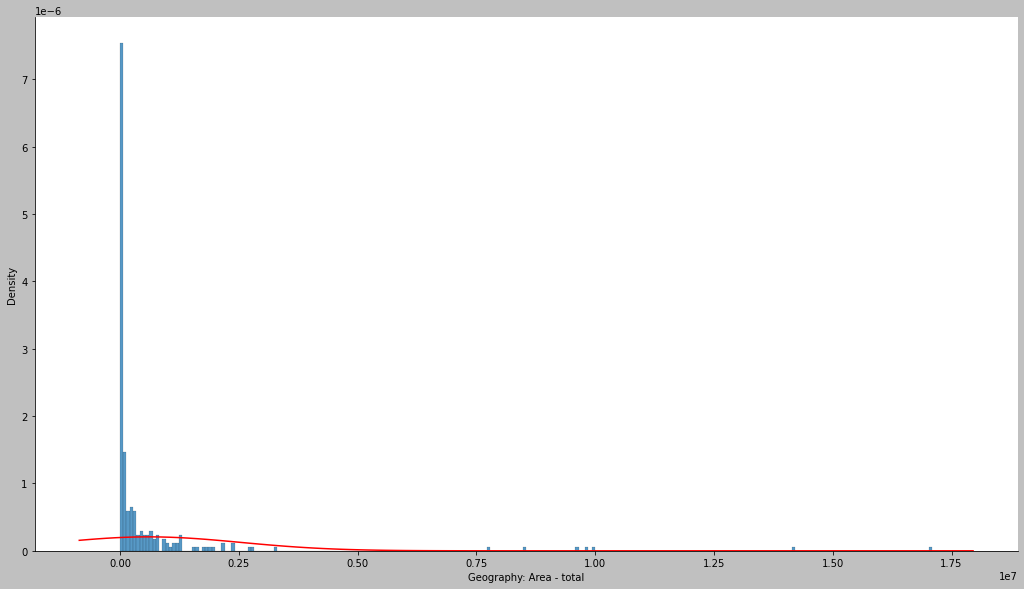

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
Geography: Area - total


CTRY_i         CTRY_n  Z_VAL        E_VAL               O_STR
183     191         Russia  8.560 17098242.000    17,098,242 sq km
7         7     Antarctica  7.056 14200000.000  14.2 million sq km
41       42         Canada  4.869  9984670.000     9,984,670 sq km
235     243  United States  4.790  9833517.000     9,833,517 sq km
46       47          China  4.667  9596960.000     9,596,960 sq km
30       31         Brazil  4.106  8515770.000     8,515,770 sq km
13       13      Australia  3.704  7741220.000     7,741,220 sq km

In [8]:
# visual Gaussian-fit check 
pDensity( dfN, 'Geography: Area - total' )

# checking with z-score 
zThresh( dfN, 'Geography: Area - total', 2.5, dfOR, ctrDct )

By contrast, though still with a minimum-skewed distribution: in **Military and 
Security: Military expenditures**, North Korea's dramatic, isolated prominence 
at the "most militarized" end turns out to be the result of extraction error. 
They do still remain the world leader for the period, at between 20-25% of GDP.

PROBABILITY DENSITY FOR:
Military and Security: Military expenditures


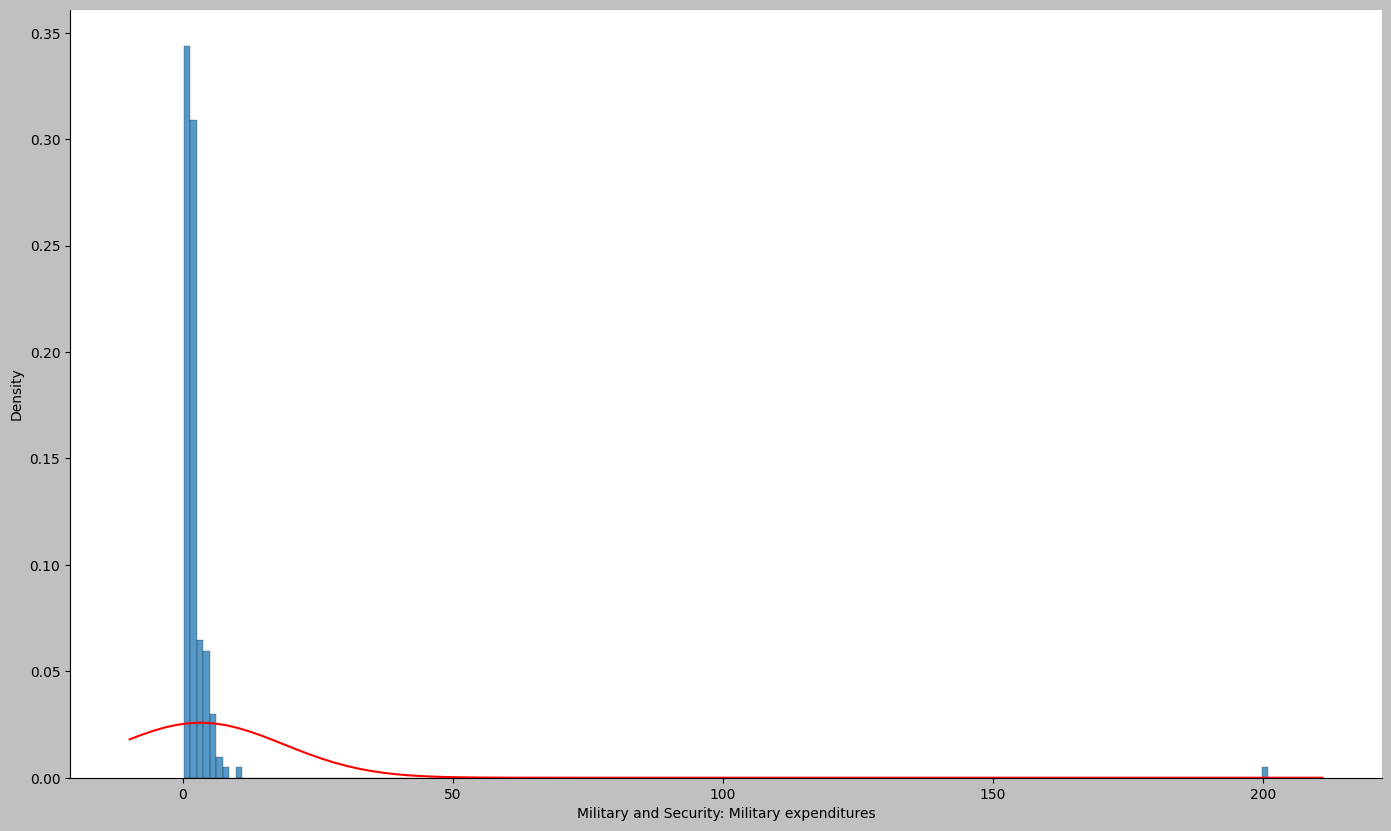

"between 2010 and 2019, military expenditures accounted for an estimated 20-25% of North Korea's GDP annually"


In [9]:
ft = 'Military and Security: Military expenditures'
pDensity( dfN, ft )
z = zThresh( dfN, ft, 0.228, dfOR, ctrDct, ret=True )
print( f"\"{[ b for a, b in z.O_STR.items() ][ 0 ]}\"" )

In [10]:
# # Random cycle though feature PD distributions
# fts = dfN.columns.to_list()
# pos = random.randint(1, len(fts) )
# pDensity( dfN, fts[pos] )
# zThresh( dfN, fts[pos], 2.5, dfOR, ctrDct )

# # zScore and g-fit with outliers excluded
# dfZ_area_e = zThresh( dfN, tArea, 2.5, dfOR, ctrDct, excl=True )
# pDensity( dfZ_area_e, 'E_VAL' )

### Exploration, Visualisation and Analysis
Reporting is broadly categorized into observations on:
1. Age, health and gender
2. Coal, Energy and Pollution
3. Economy
4. Geography and Environment

In [11]:
# dataUtls = importlib.reload( dataUtls )

# provide local access to required module data tools
showMax = dataUtls.showMaxima  # barplot for <=10 feature-max/min countries
pltSctr = dataUtls.plotScttr  # scatterplot distribution for feature pair
getRank = dataUtls.getRank  # return country's rank for value for feature
getVal = dataUtls.getVal  # return val for country for feature
getCorDct = dataUtls.getCorDct  # generate feature master correl. dict
getCTDict = dataUtls.getCThreshDct  # get dict for correlations at threshold
getTRep = dataUtls.getThreshReport  # report correlations-at-threshold
repCorr = dataUtls.repCorrel  # report correlation for feature pair
difsFld = dataUtls.showDiffsFilled  # For corrThreshDct, omit NaN-only diffs
fSet = lambda x, y: frozenset( [ x, y ] )  # shorten frozenset call

#### Feature maxima
The highest and lowest values for features compiled by the CIA's World Factbook 
provide a convenient global view on important aspects of humanity and the 
environment. Some caution is necessary before interpreting these summaries 
due to some issues of accuracy around conflagration of time period (the CIA
resource mixes the latest reporting year, which can vary by decade or more).

#### Correlations
Perfect correlations (of significance -1 or 1) are rarely informative, in that 
they identify effectively identical, or duplicate, features. For this reason, 
they can be useful for reducing unnecessary dimensionality in large datasets.
 
Strong correlations will tend to be more self-evident (for example, "Total 
area" being near-perfectly correlated to "Total land", with some noise caused 
by variable water-area), but still provide an empirical, observational basis 
for testing assumptions. Scatter plots are useful for identifying or 
demonstrating where a clear pattern, like a linear correlation, is present, and 
also for an alternative view on observations made with different techniques.

***

In [12]:
# generate correlation significance between all features 
corrDct = getCorDct( df )

Compiled 19900 correlations


In [13]:
# Check perfect correlations. Confirmed duplicates, drop
for i in (perfC:= getCTDict( 1, corrDct, df )): 
    print( f"{perfC[i]['corr']=}:\n{perfC[i]['baseName']=}"
    f"\n{perfC[i]['compName']=}\n" )
    corrDct.pop( i )

print( 'Dropped duplicate features' )

perfC[i]['corr']=1.0:
perfC[i]['baseName']='Geography: Land use - agricultural land'
perfC[i]['compName']='Environment: Land use - agricultural land'

perfC[i]['corr']=1.0:
perfC[i]['baseName']='Geography: Land use - other'
perfC[i]['compName']='Environment: Land use - other'

perfC[i]['corr']=1.0:
perfC[i]['baseName']='Environment: Urbanization - urban population'
perfC[i]['compName']='People and Society: Urbanization - urban population'

perfC[i]['corr']=1.0:
perfC[i]['baseName']='Environment: Urbanization - rate of urbanization'
perfC[i]['compName']='People and Society: Urbanization - rate of urbanization'

perfC[i]['corr']=1.0:
perfC[i]['baseName']='Economy: Unemployment, youth ages 15-24 - total'
perfC[i]['compName']='People and Society: Unemployment, youth ages 15-24 - total'

perfC[i]['corr']=1.0:
perfC[i]['baseName']='Economy: Unemployment, youth ages 15-24 - male'
perfC[i]['compName']='People and Society: Unemployment, youth ages 15-24 - male'

perfC[i]['corr']=1.0:
perfC[i]['

In [14]:
# Examine near-perfect threshold (likely still duplicates or self-evident)
thresh_9_9_8 = getCTDict( 0.998, corrDct, df )
checkDifs_9_9_8 = difsFld( thresh_9_9_8, df )


CORRELATION FOR FEAT-PAIR [10, 76]
IN THRESHOLD +-=[ 0.998-inf ] 
CORR: 0.9999999999999999
BASE: Geography: Land use - forest
COMP: Environment: Land use - forest

[10, 76]: DIFFERENCES ALL NaN


CORRELATION FOR FEAT-PAIR [1, 2]
IN THRESHOLD +-=[ 0.998-inf ] 
CORR: 0.9995056827871487
BASE: Geography: Area - total
COMP: Geography: Area - land
160 Non-NaN diffs for [1, 2]. First 3:



CORRELATION FOR FEAT-PAIR [41, 42]
IN THRESHOLD +-=[ 0.998-inf ] 
CORR: 0.9984123657153035
BASE: People and Society: Infant mortality rate - total
COMP: People and Society: Infant mortality rate - male
225 Non-NaN diffs for [41, 42]. First 3:


In [15]:
# print a particular correlation report:
# print( f"{getTRep( thresh_9_9_9, fSet(10, 76) )}" )
# [20, 44](c-0.82): higher youth dependency, lower life expectancy at birth 

# For threshold 0.995-0.999
# thresh_995_999 = getCTDict( 0.800, corrDct, df, out_lim=0.850 )
# checkDifs_995_998 = difsFld( thresh_995_999, df )

# # T10 cycle
# start = 167
# cycleT10(  df, start, 1 )
# zThresh( df, totArea, 2.5, dfOR, ctrDct )
# start +=1

***
#### AGE, HEALTH AND GENDER

- Neat curvilinear distribution between **percent pop. over 64** and
**percent population under 15** showing a clear negative relationship.
- Likewise, in a positive trend, the strong association of **higher birthrate**
with **bigger proportion of 15-24yo's** rapidly decreases after the birthrate 
hits around 20%; after this point, that segment is relatively stable for higher 
birthrates. 

Feats: [ People and Society: Age structure - 65 years and over ]
       [ People and Society: Age structure - 0-14 years ]


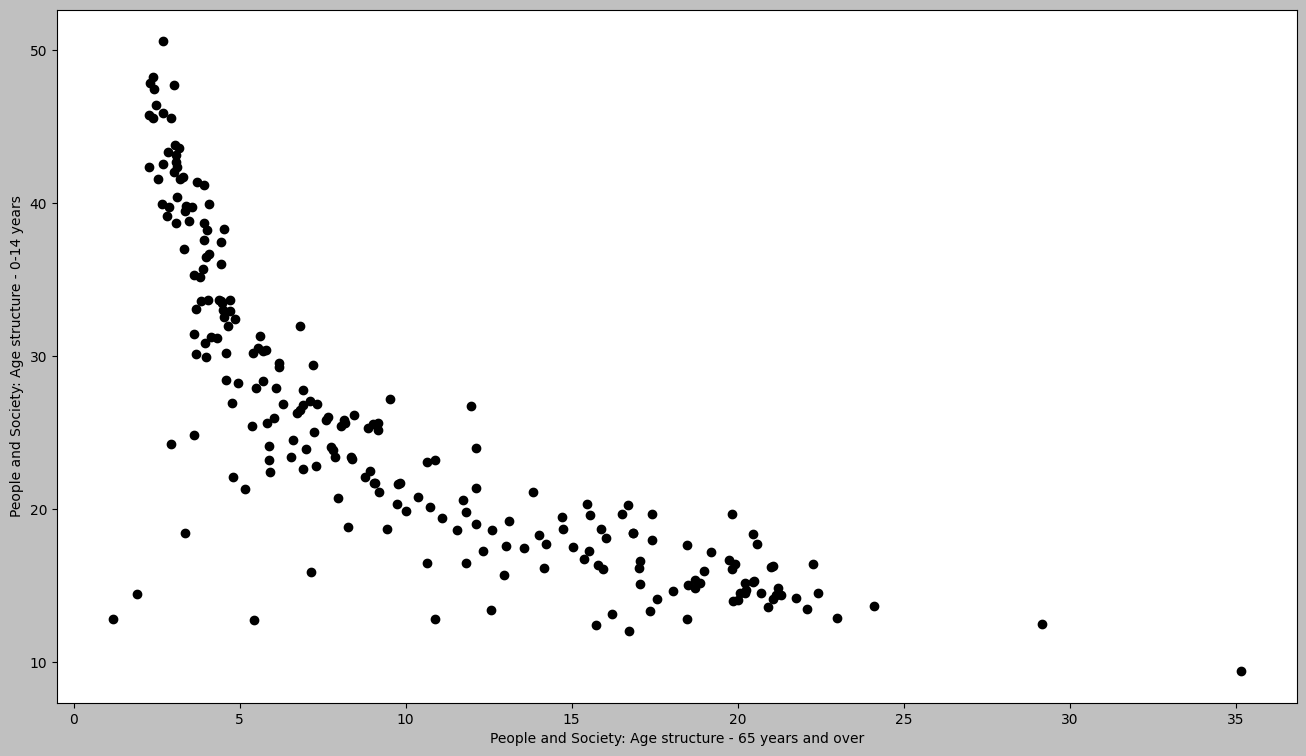

Feats: [ People and Society: Birth rate ]
       [ People and Society: Age structure - 15-24 years ]


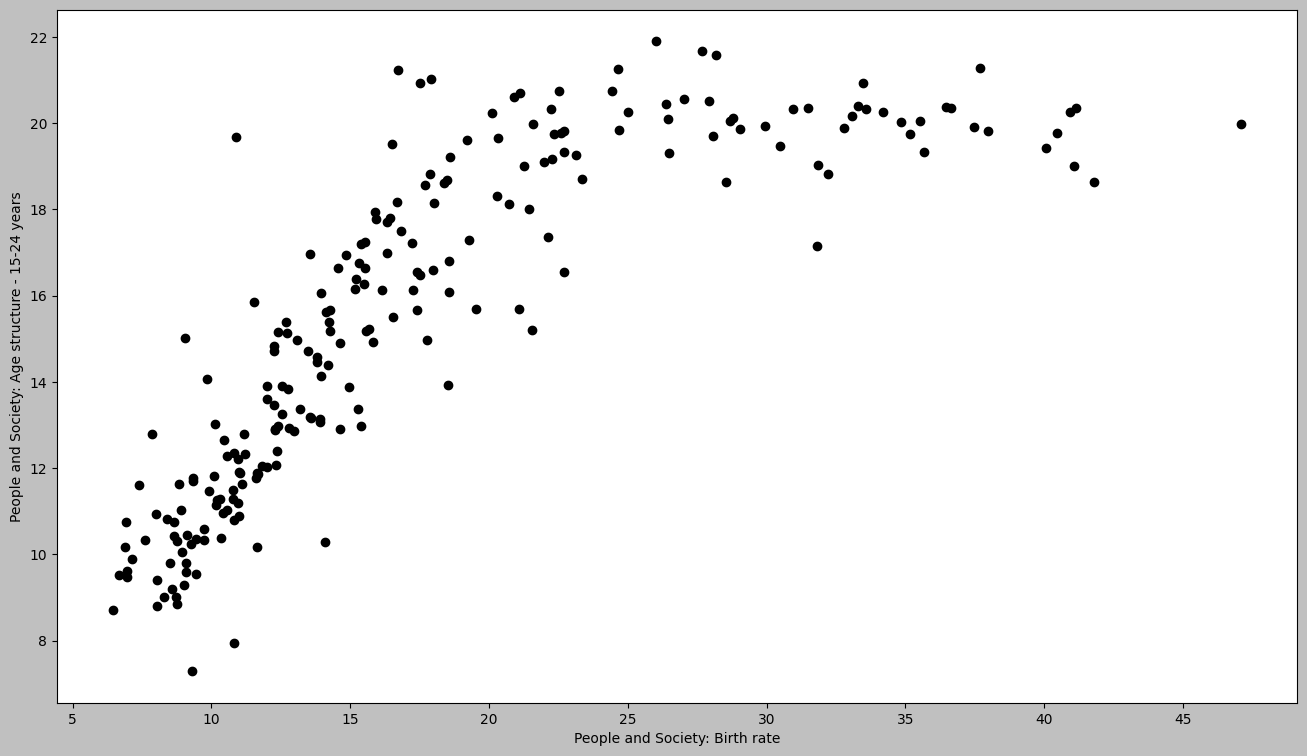

In [16]:
pltSctr( df, [
    'People and Society: Age structure - 65 years and over',
    'People and Society: Age structure - 0-14 years' ] )

pltSctr( df, [
    'People and Society: Birth rate',
    'People and Society: Age structure - 15-24 years' ] )

***
- Arab gulf countries' **sex ratio weighting** toward men is startling by the
global distribution, particularly Qatar & the Unite Arab Emirates.
Note we can see strong support for 
[Fisher's principle](https://en.wikipedia.org/wiki/Fisher%27s_principle) - sex 
ratio is leptokurtic, closely gathered around the one-to-one ratio.

PROBABILITY DENSITY FOR:
People and Society: Sex ratio - total population


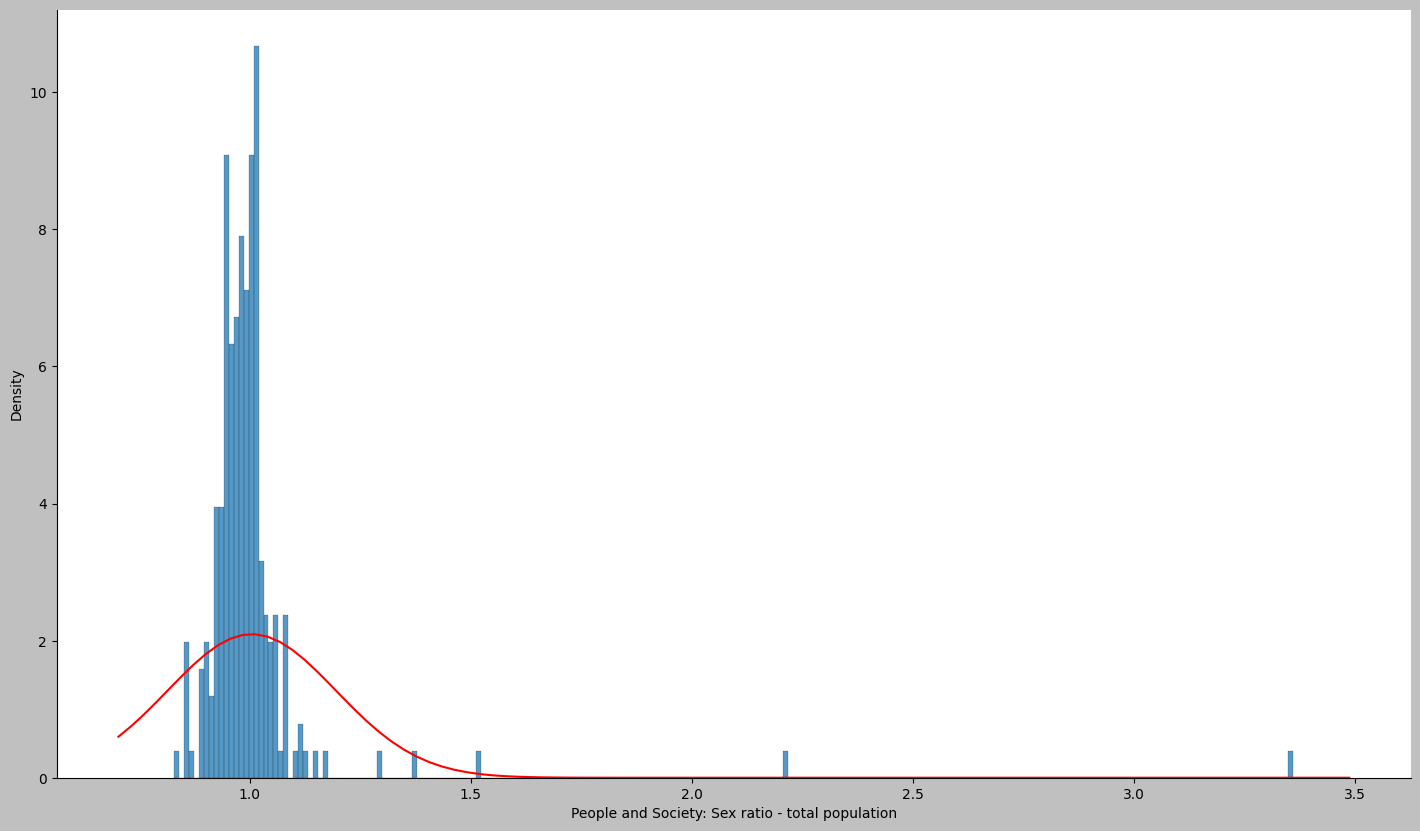

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
People and Society: Sex ratio - total population


CTRY_i                CTRY_n  Z_VAL  E_VAL  \
163     189                 Qatar 12.365  3.360   
212     241  United Arab Emirates  6.327  2.210   
14       17               Bahrain  2.704  1.520   

                               O_STR  
163  3.36 male(s)/female (2022 est.)  
212  2.21 male(s)/female (2022 est.)  
14   1.52 male(s)/female (2022 est.)

People and Society: Sex ratio - 25-54 years


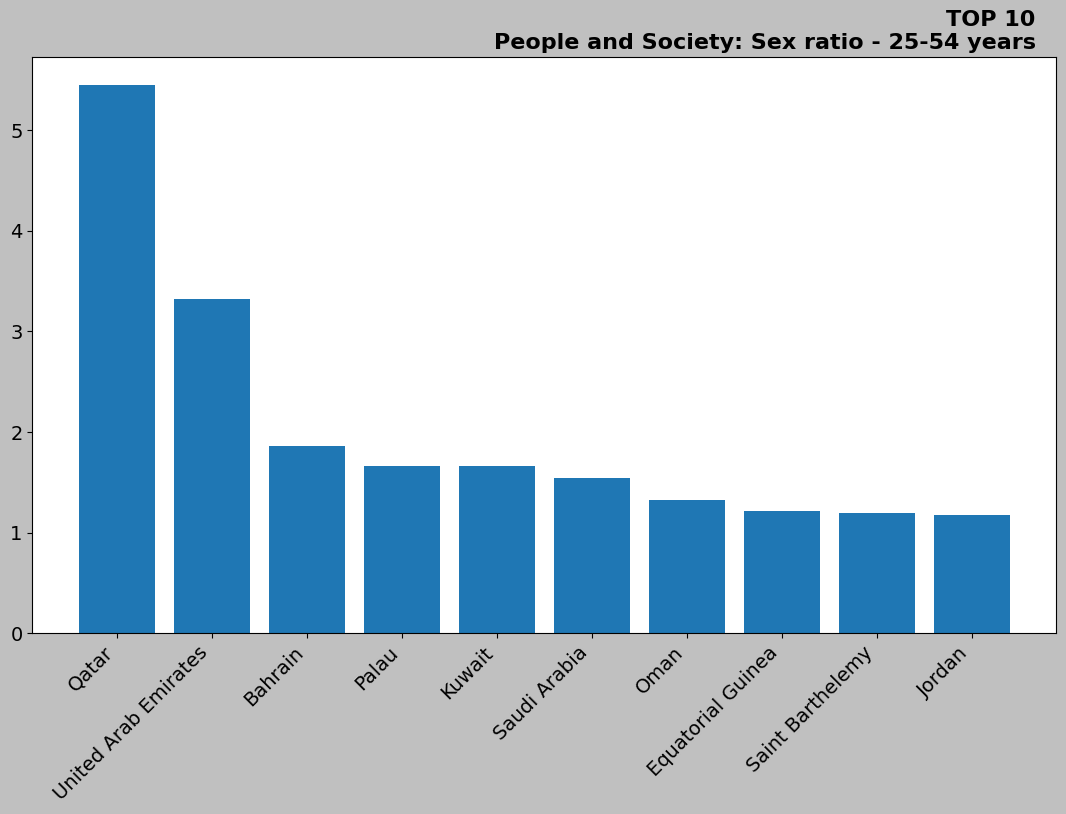

People and Society: Sex ratio - 55-64 years


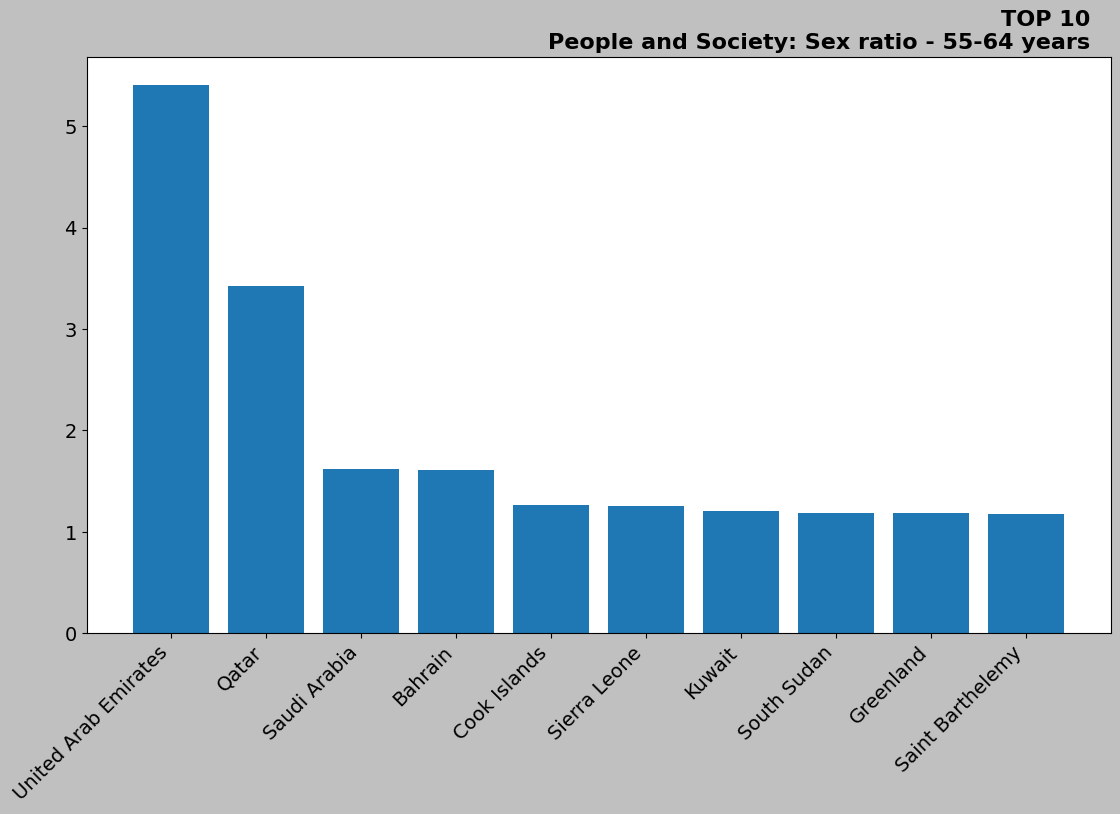

In [17]:
ft = 'People and Society: Sex ratio - total population'
pDensity( dfN, ft )
zThresh( dfN, ft, 2.5, dfOR, ctrDct )

showMax( 'People and Society: Sex ratio - 25-54 years', df )
showMax( 'People and Society: Sex ratio - 55-64 years', df )

At the same time, both have (by good measure) the highest proportion of
total population that is 25-54 years old.

People and Society: Age structure - 25-54 years


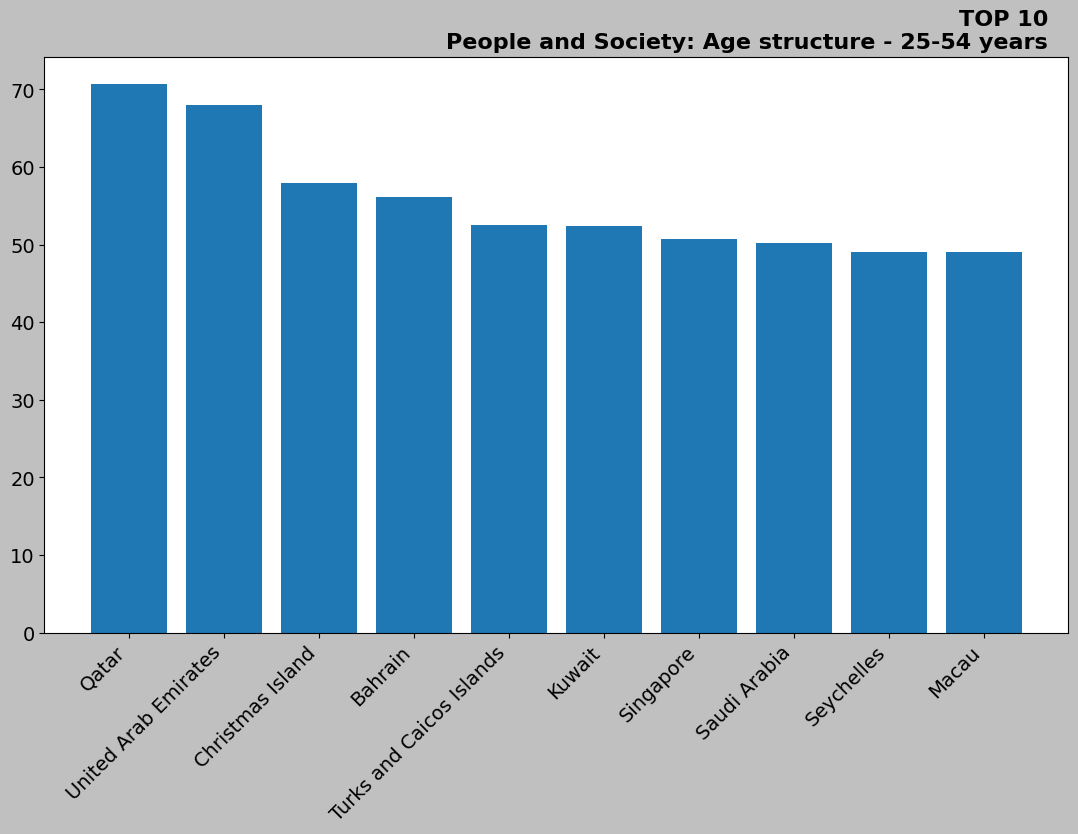

In [18]:
showMax( 'People and Society: Age structure - 25-54 years', df )

Interesting combination - one can imagine a dominating social discourse might 
concern the relation of older men to working-age adults.
***
Some more points on **aging populations:** 

- in Palau and North Korea, there are more than twice as many old women as 
old men.
- with older populations, the rate of urbanization decreases
- with older populations, the number of physicians, and of broadband 
subscriptions, increases 

People and Society: Sex ratio - 65 years and over


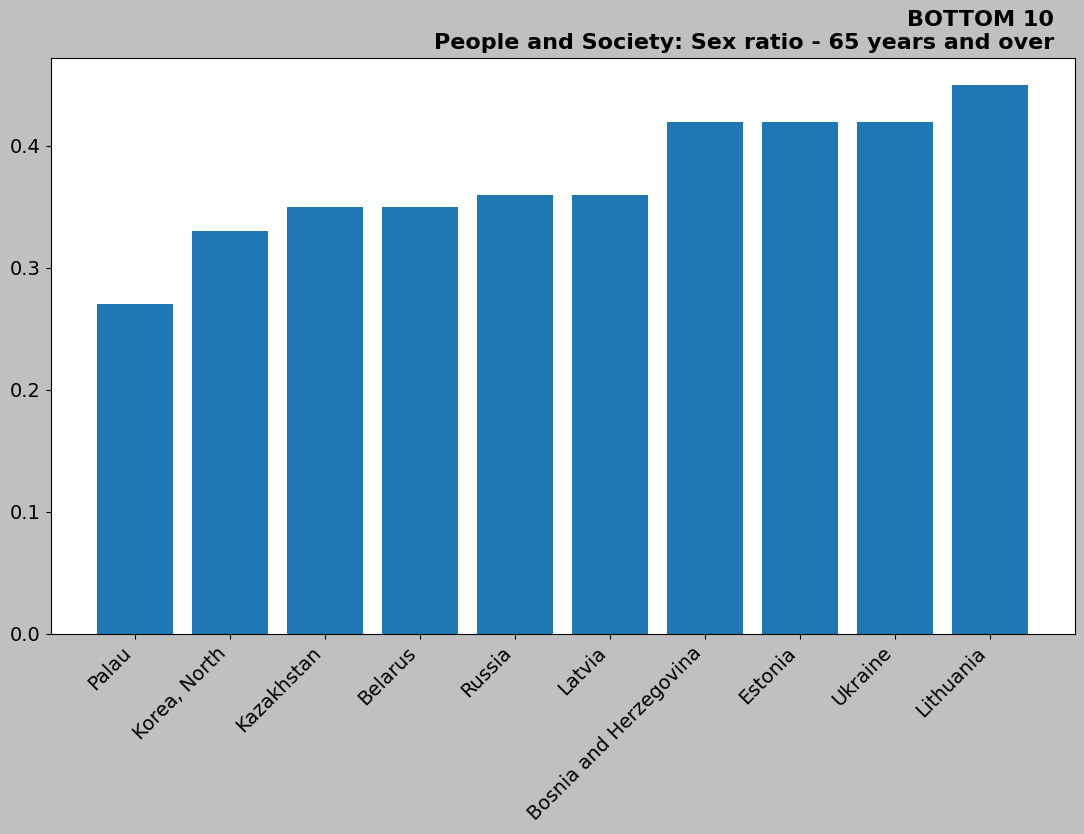

Feats: [ People and Society: Age structure - 55-64 years ]
       [ People and Society: Urbanization - rate of urbanization ]


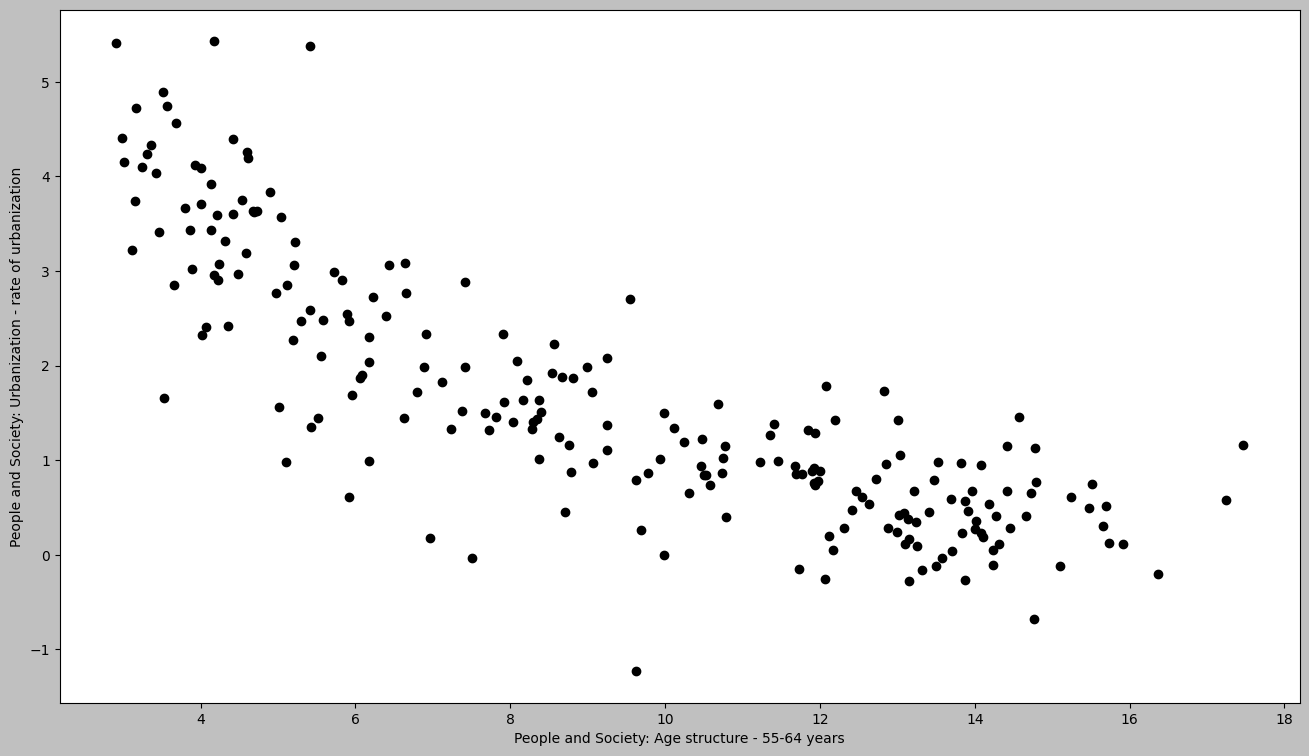

Feats: [ People and Society: Age structure - 55-64 years ]
       [ Communications: Broadband - fixed subscriptions - subscriptions per 100 inhabitants ]


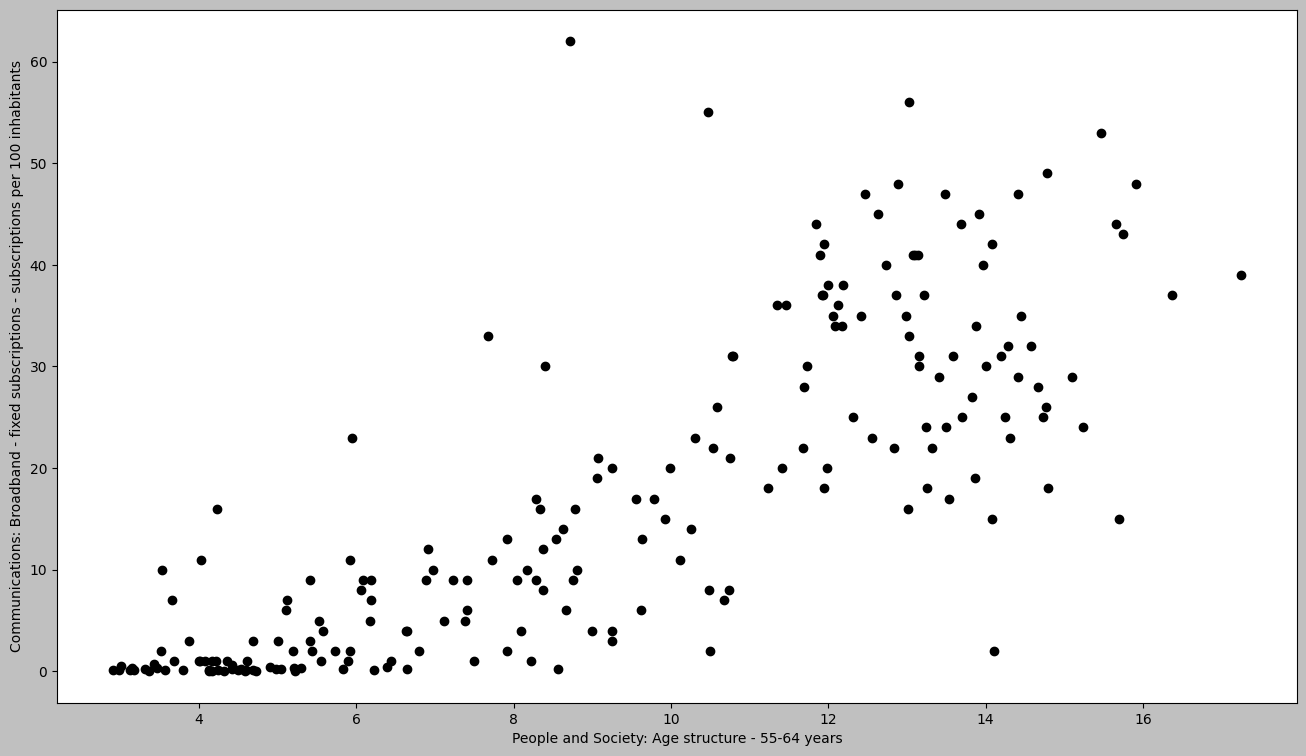

Feats: [ People and Society: Median age - total ]
       [ People and Society: Physicians density ]


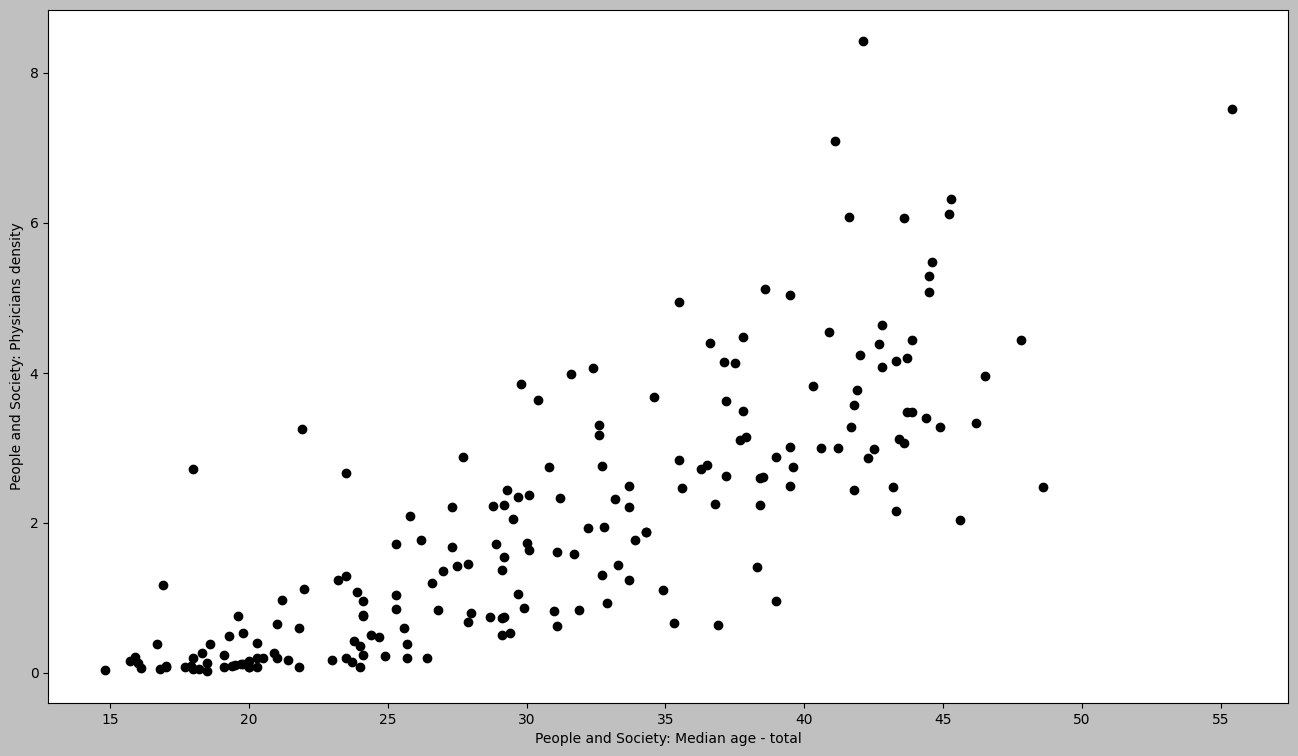

In [19]:
showMax( 'People and Society: Sex ratio - 65 years and over', df, asc=True )

pltSctr( df, [
    'People and Society: Age structure - 55-64 years',
    'People and Society: Urbanization - rate of urbanization' ] )
pltSctr( df, [
    'People and Society: Age structure - 55-64 years',
    f'Communications: Broadband - fixed subscriptions - '
    f'subscriptions per 100 inhabitants' ] )
pltSctr( df, [
    'People and Society: Median age - total',
    f'People and Society: Physicians density' ] )

***
- Some suprise might arise from the data on **Health Expenditure** - despite the 
highest costs for *individuals* in the OECD (see 
[here](https://en.wikipedia.org/wiki/Health_care_prices_in_the_United_States) 
for example), the US Government is spending more on health than the rest of the 
world (Tuvalu excepted. Along with other island states in this top-ten, 
expenditure proportions might be considered less significant given the 
susceptibility of comparably small budgets to weighting.)

People and Society: Current Health Expenditure


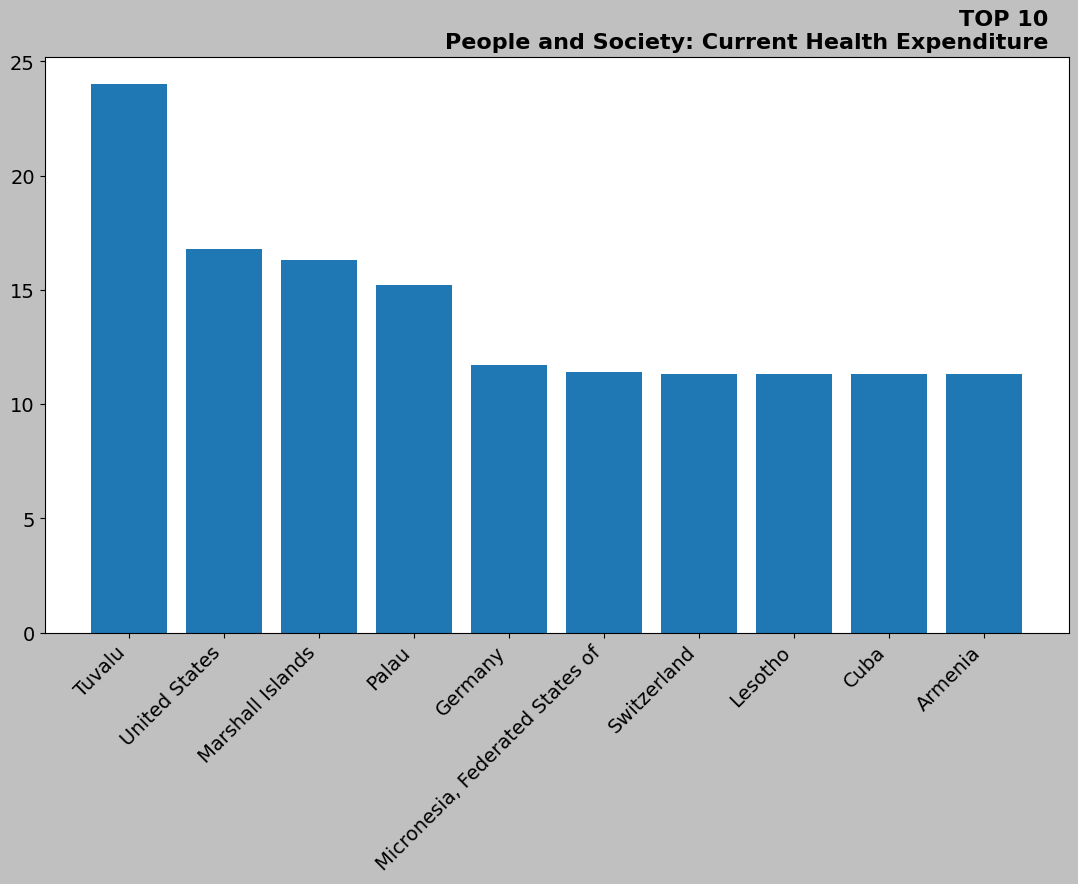

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
People and Society: Current Health Expenditure


CTRY_i            CTRY_n  Z_VAL  E_VAL         O_STR
174     238            Tuvalu  5.874 24.000    24% (2019)
179     243     United States  3.452 16.800  16.8% (2019)
105     147  Marshall Islands  3.284 16.300  16.3% (2019)
129     177             Palau  2.914 15.200  15.2% (2019)

In [20]:
# People and Society: Current Health Expenditure
# Surprised to see US near the top with the impression given by private health 
# costs.
showMax( ft := 'People and Society: Current Health Expenditure', df )
# Only one country in t10 expenditure is also in t10 physician density (Cuba)

zThresh( dfN, ft, 2.5, dfOR, ctrDct )

***
- Highly interesting to see Monaco leading the top-ten for **Physician 
density** while at the same time trailing in the very bottom for **Health 
expenditure**. It could only be surmrised that citizens are privately funding 
most of their healthcare. 
- There are surprisingly zero nations from the Anglosphere here; 
more data would be needed to probe the following question: with fewer 
physicians per individual, is there a measurable failure of preventative 
care that might have been afforded by the access and familiary that 
community-embedded physicians might provide?

People and Society: Physicians density


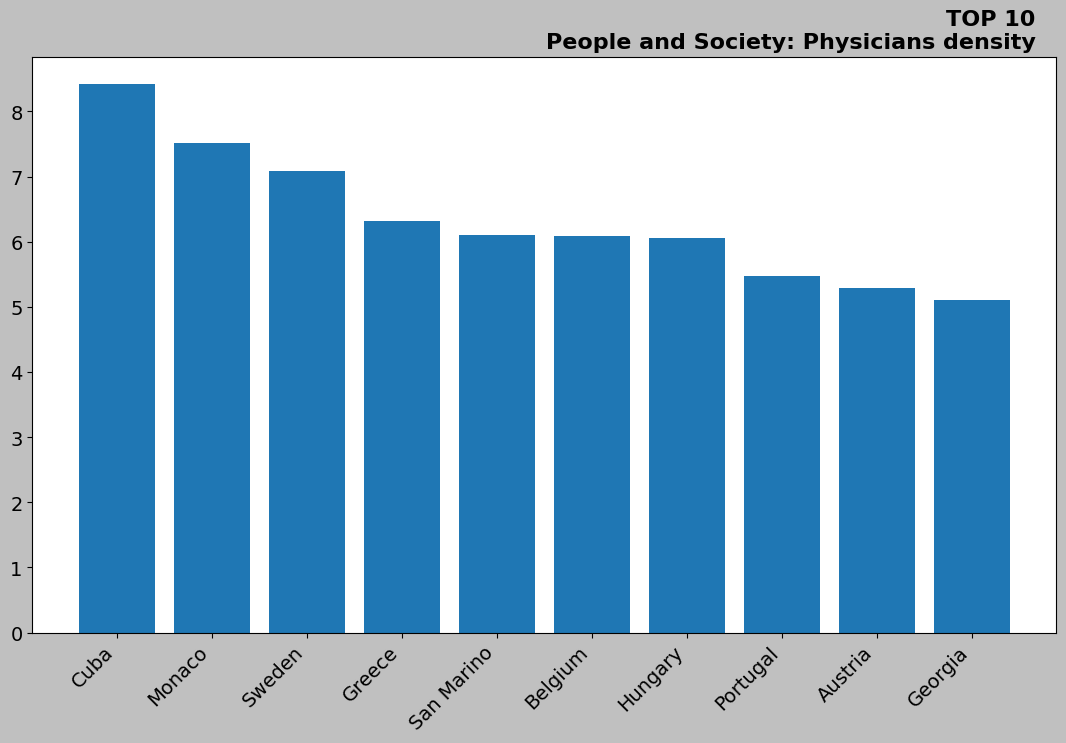

People and Society: Current Health Expenditure


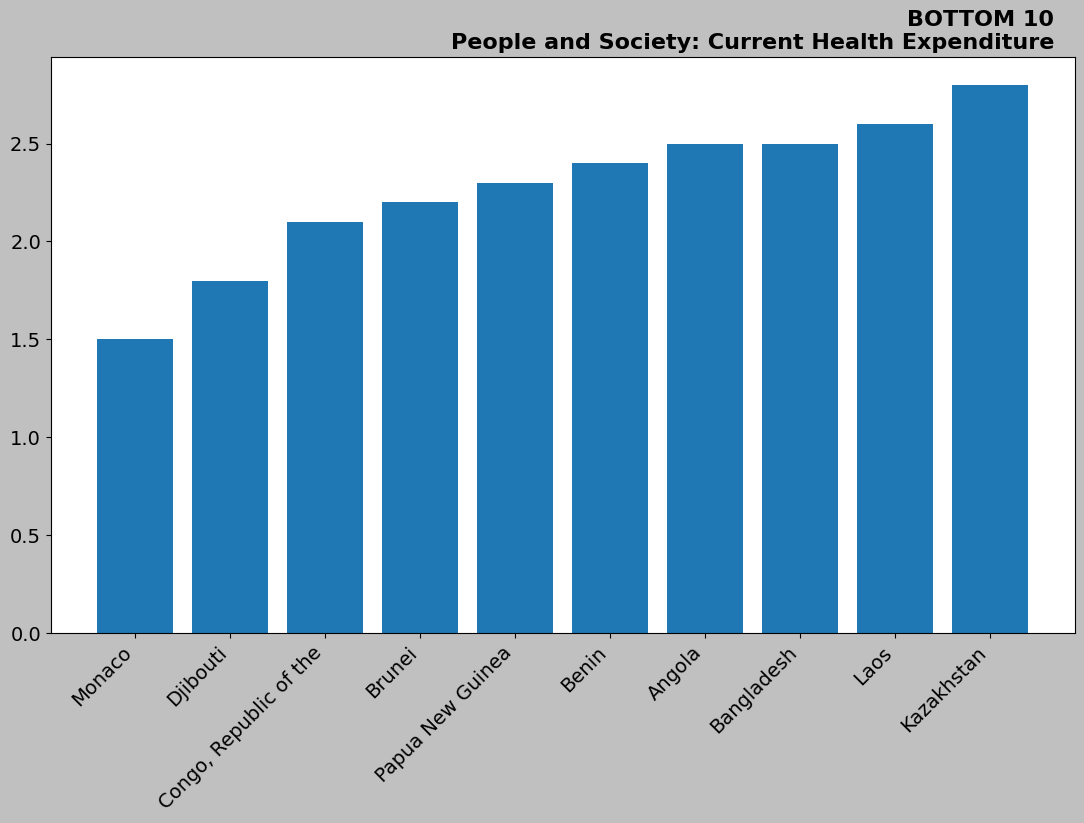

In [21]:
showMax( 'People and Society: Physicians density', df )
showMax( 'People and Society: Current Health Expenditure', df, asc=True )

***
- Southern African nations exclusively form the t10 **percent of population 
living with HIV/AIDs**

People living with HIV/AIDs as percentage of population


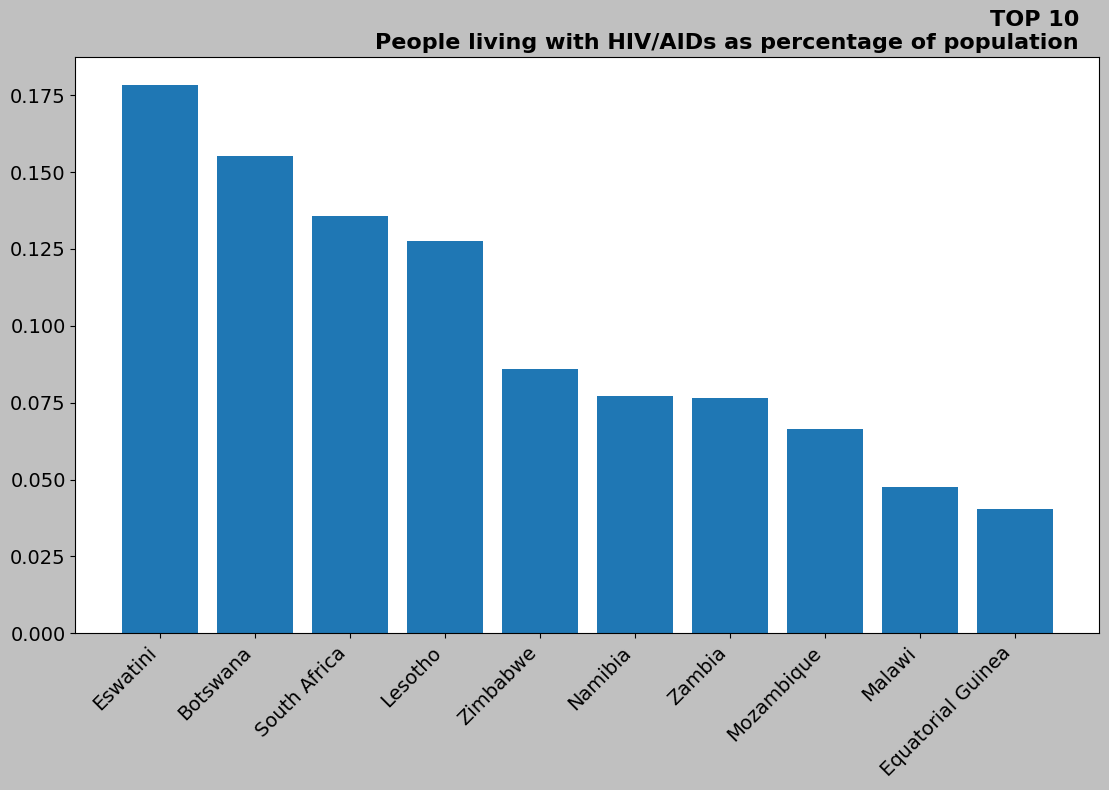

In [22]:
df[ 'People living with HIV/AIDs as percentage of population' ] = (
    df[ 'People and Society: HIV/AIDS - people living with HIV/AIDS' ] /
    df[ 'People and Society: Population' ])
showMax( 'People living with HIV/AIDs as percentage of population', df )


- Exploring what is the **lowest-HIV prevalence among S.A. populations**?

People living with HIV/AIDs as percentage of population


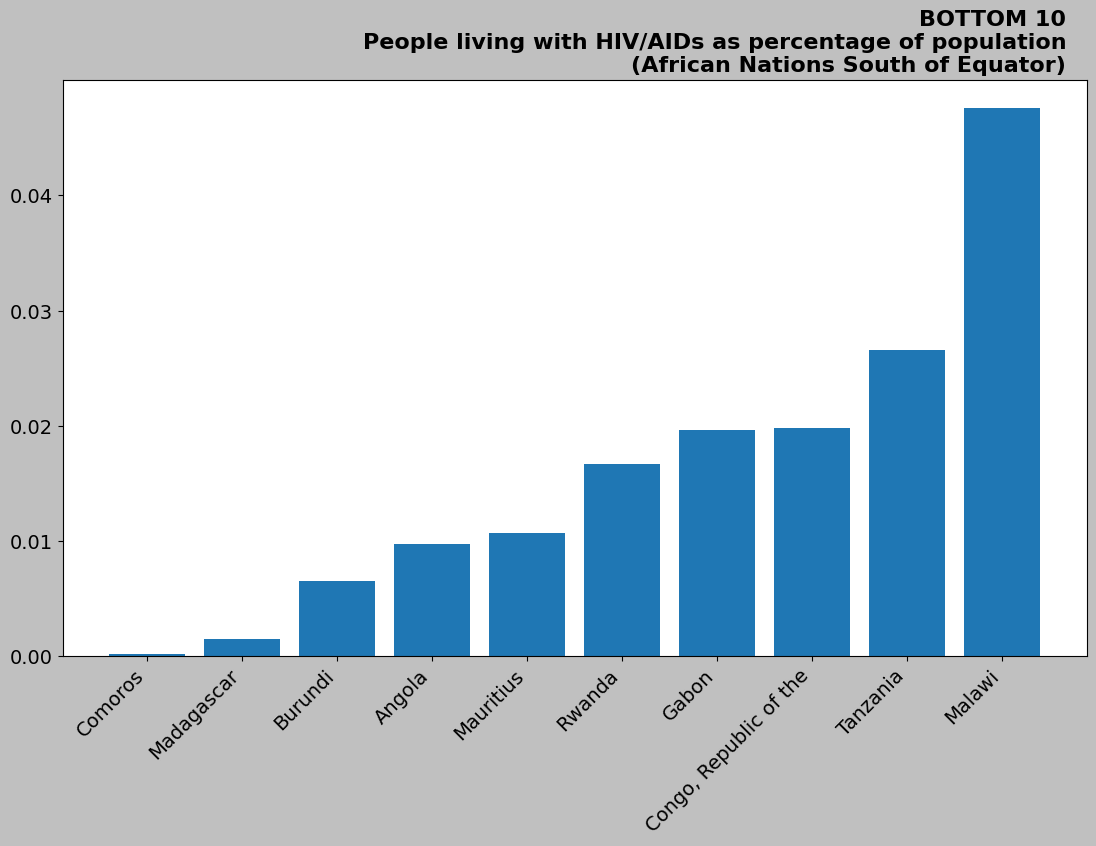

In [23]:
# 
sthEquatAfrica = dfOR[
    (dfOR[ "Geography: Map references" ] == "Africa")
    & (dfOR[ "Geography: Geographic coordinates" ].str.contains( "S" )
       ) ].Country

showMax( 'People living with HIV/AIDs as percentage of population',
    df[ df[ 'Country' ].isin( sthEquatAfrica ) ], asc=True,
    sub="African Nations South of Equator" )

- For the countries that are not islands, Angola - being large, and close to 
the HIV/AIDs epicentre, appears to have some form of strongly inhibiting factor.
A look at recent history identifies a cause for the low prevalence: civil war. 

> The 27-year civil war in Angola, lasting from 1975 until 2002, kept the spread 
> of HIV to a minimum due to large parts of the country being inaccessible to 
> people infected with the virus. During the civil war, individuals from 
> neighboring countries such as Zambia, Botswana, and Zimbabwe (all countries 
> with high prevalence rates of HIV) were also not allowed to come into the 
> country, which played a significant role in controlling the spread of HIV.
> [(source: Wikipedia)](https://en.wikipedia.org/wiki/HIV/AIDS_in_Angola#History)

***
- **Gender and Tobacco usage**: nearly half the people in Nauru and Burma smoke.
However, when limited to females, European nations remain in the t10, while
the Asia-Pacific nations Burma, Kiribati, Timor Leste, PNG and Indonesia 
disappear (the men are the smokers). </br> </br> The Islands pattern is 
strikingly reversed for Nauru, where it is female smoking alone which places it 
at number one, with male smoking at 140th place!

With value of [ 47.8 ], Nauru is 140th-highest for:
'People and Society: Tobacco use - male'
(out of total 256 ranked)
People and Society: Tobacco use - total


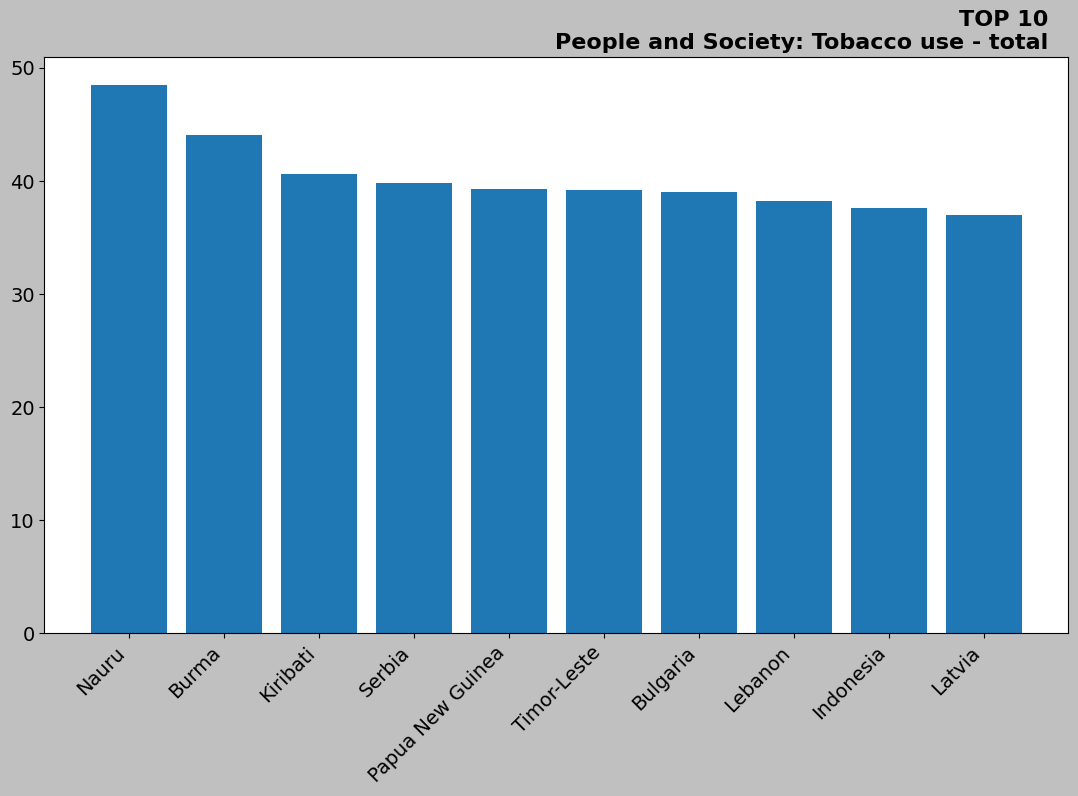

People and Society: Tobacco use - male


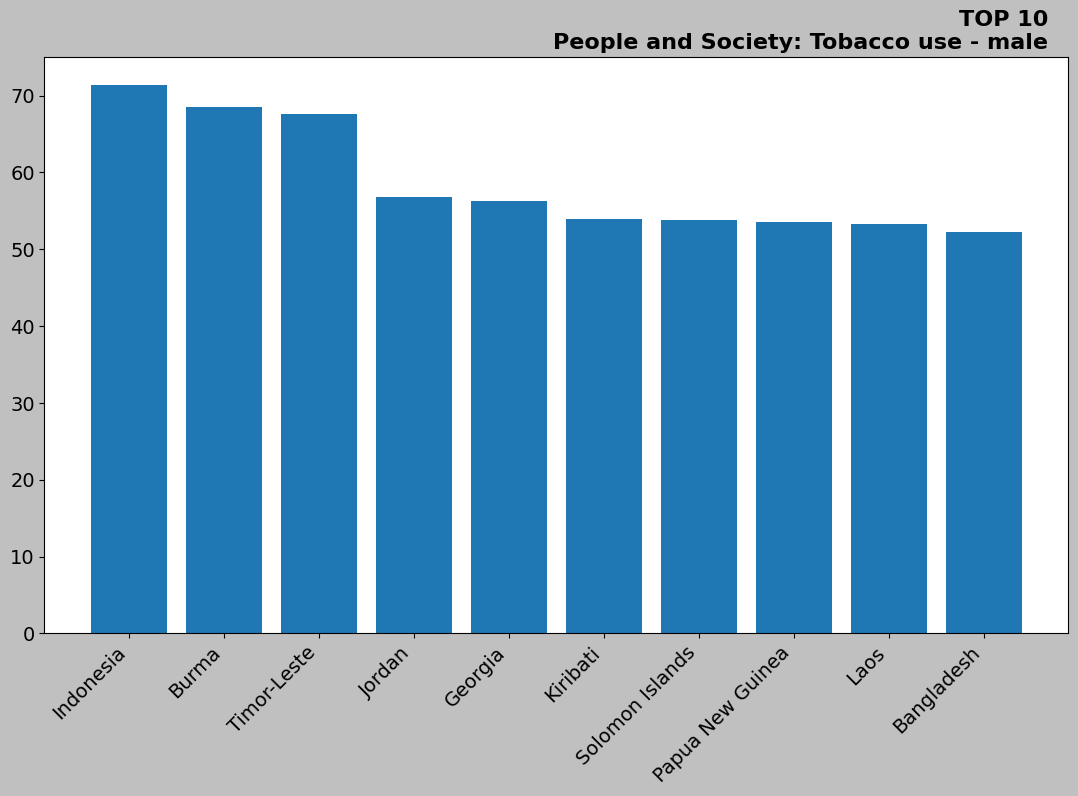

People and Society: Tobacco use - female


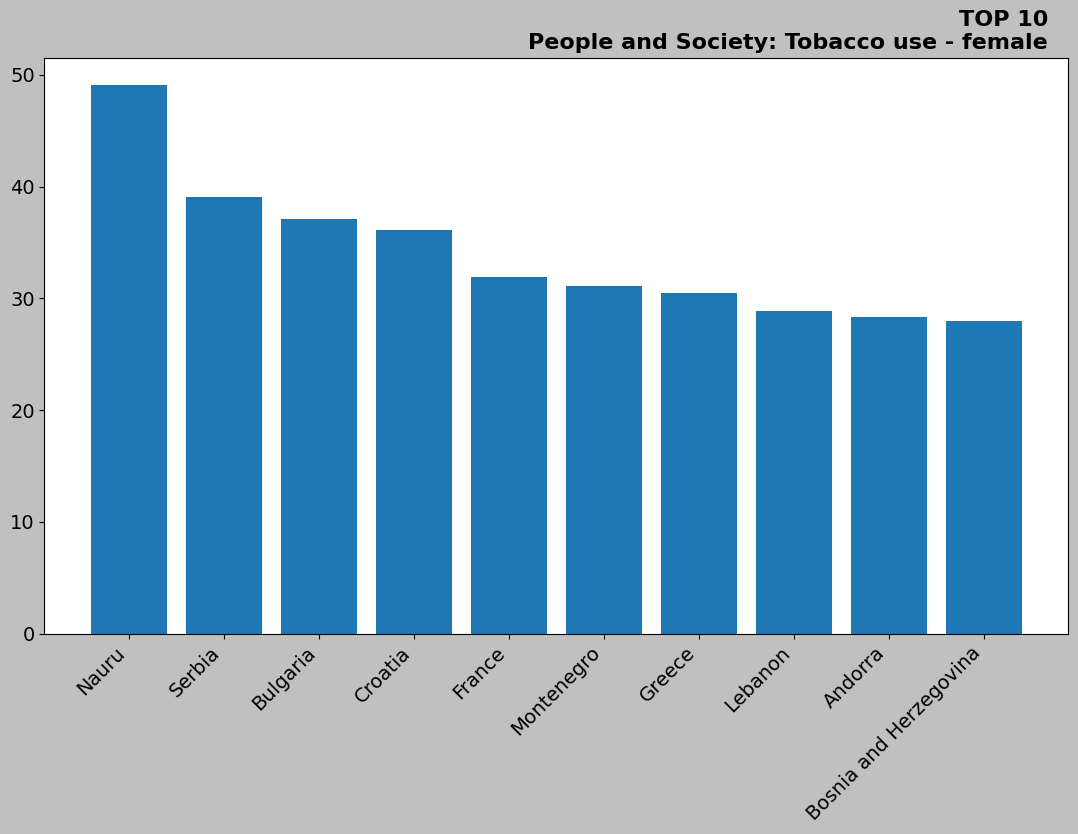

In [24]:
getRank( df, 'Nauru', 'People and Society: Tobacco use - male' )
showMax( 'People and Society: Tobacco use - total', df )
showMax( 'People and Society: Tobacco use - male', df )
showMax( 'People and Society: Tobacco use - female', df )

# No Smoking:
# showMax( 'People and Society: Tobacco use - total', df, asc=True )



***
- **Generational weight disparity**: where is there the highest observations 
for both adult obesity prevalence and children 4 years and under who are 
underweight? </br> </br> These maxima are limited to the seven nations 
reporting **above-mean observations** for both features.

Generational weight disparity


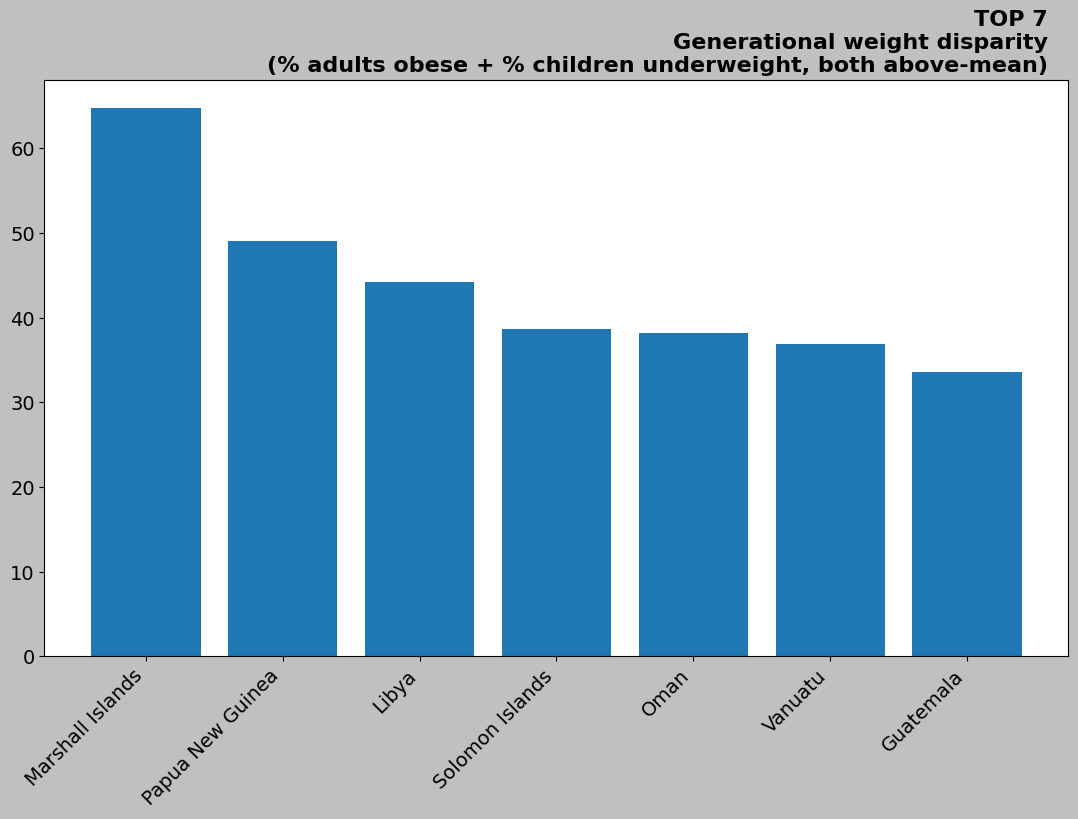

In [25]:
uFeat = 'People and Society: Children under the age of 5 years underweight'
oFeat = 'People and Society: Obesity - adult prevalence rate'

df[ 'Generational weight disparity' ] = (df[ uFeat ] + df[ oFeat ])

aboveMeans = [ country for country in df[ 'Country' ] if (
    df.loc[ df[ 'Country' ] == country, uFeat ].iloc[ 0 ]
    >= df[ uFeat ].mean() and
    df.loc[ df[ 'Country' ] == country, oFeat ].iloc[ 0 ]
    >= df[ oFeat ].mean()) ]

showMax( 'Generational weight disparity',
    df[ df[ 'Country' ].isin( aboveMeans ) ],
    sub="% adults obese + % children underweight, both above-mean" )

***
- **Education disparities** - pat on the back for Australia: by a modest yet 
significant margin, has the largest percent total competing teriary, AND the 
position holds true for women as much as men.

People and Society: School life expectancy (primary to tertiary education) - total


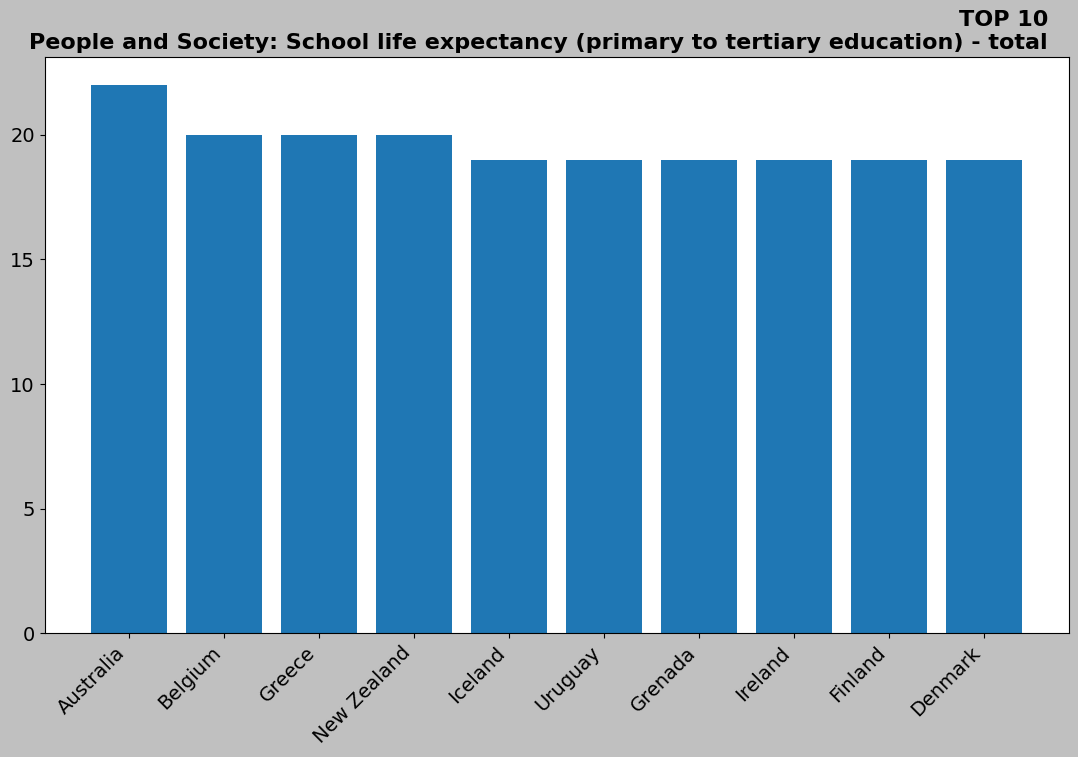

People and Society: School life expectancy (primary to tertiary education) - male


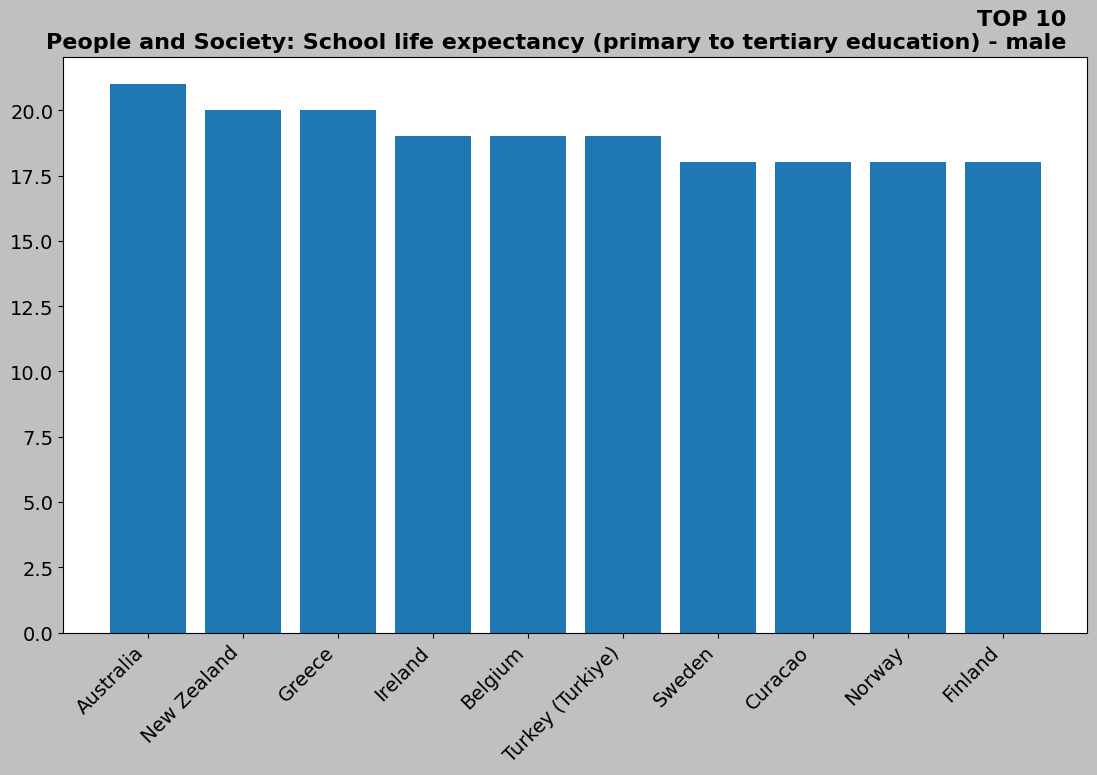

People and Society: School life expectancy (primary to tertiary education) - female


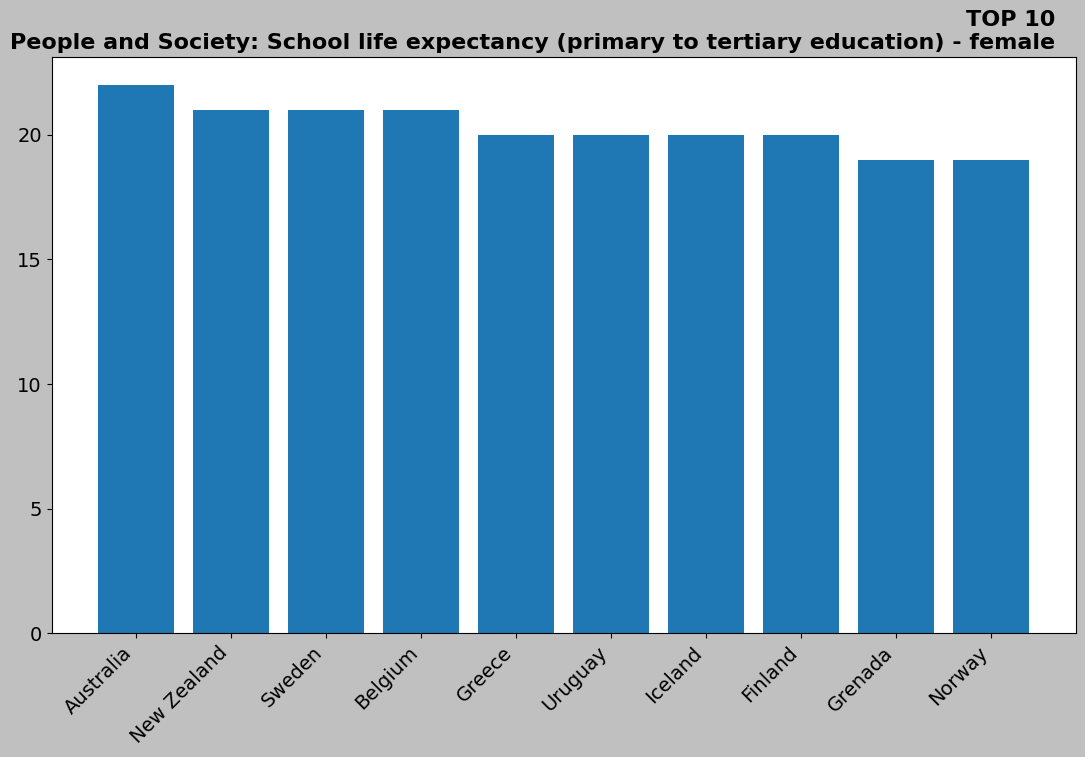

In [26]:
expectFeatStr = (
    "People and Society: School life expectancy (primary to tertiary "
    "education) -")
showMax( f'{expectFeatStr} total', df )
showMax( f'{expectFeatStr} male', df )
showMax( f'{expectFeatStr} female', df )


***
- **School-completion disparity in the sexes**: Liechtenstein stands out, 
having one of the highest GDPs per capita in the world. 

School completion disparity between sexes


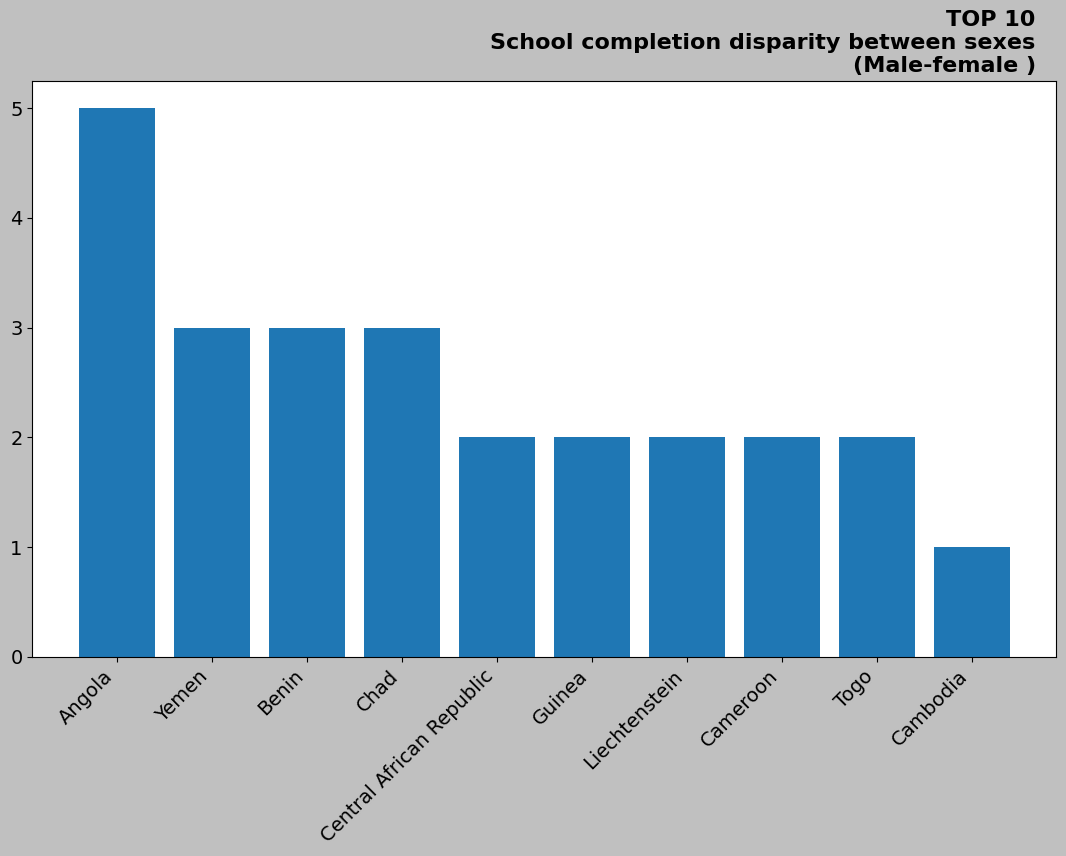

In [27]:
ft = 'School completion disparity between sexes'
df[ ft ] = (df[ f'{expectFeatStr} male' ] - df[ f'{expectFeatStr} female' ])
showMax( ft, df, sub="Male-female " )


***
- Most **emmigration**, and **populations in greatest contraction**: two very 
strong categories: either islands (esp. Pacific), or eastern Europe

People and Society: Net migration rate


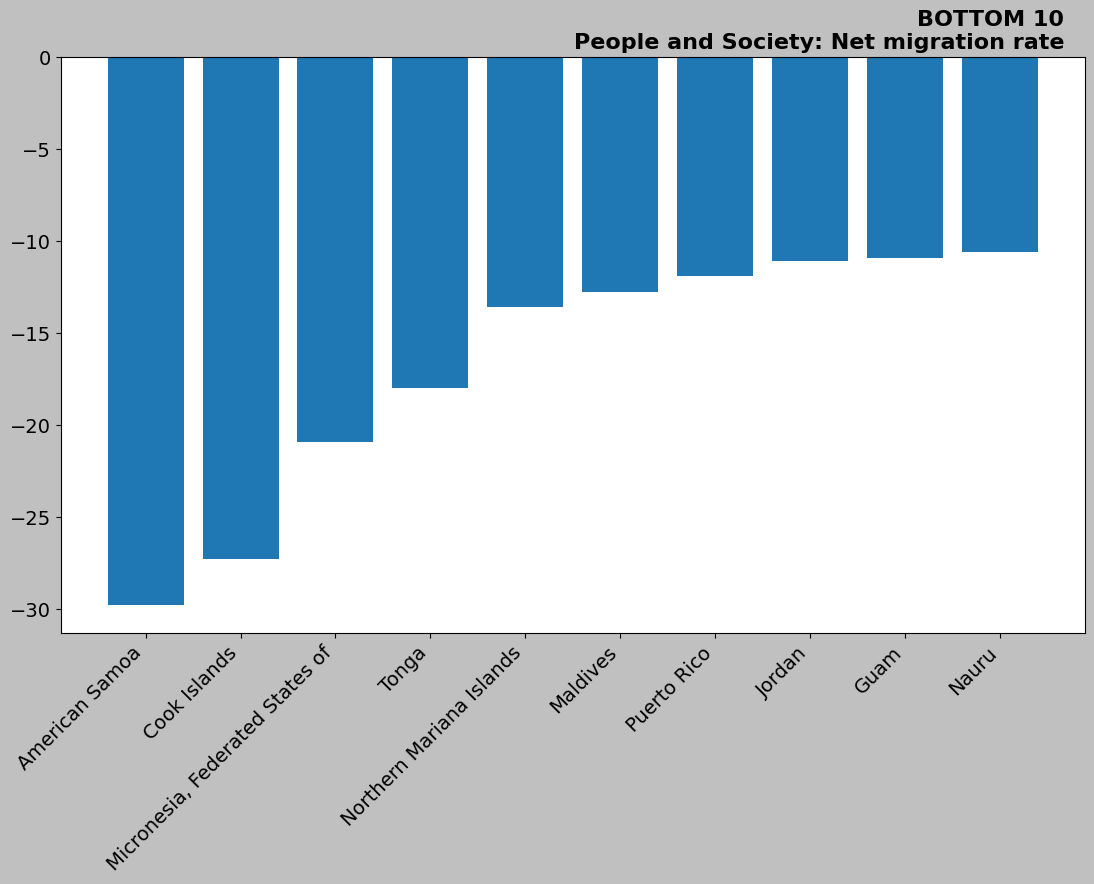

People and Society: Population growth rate


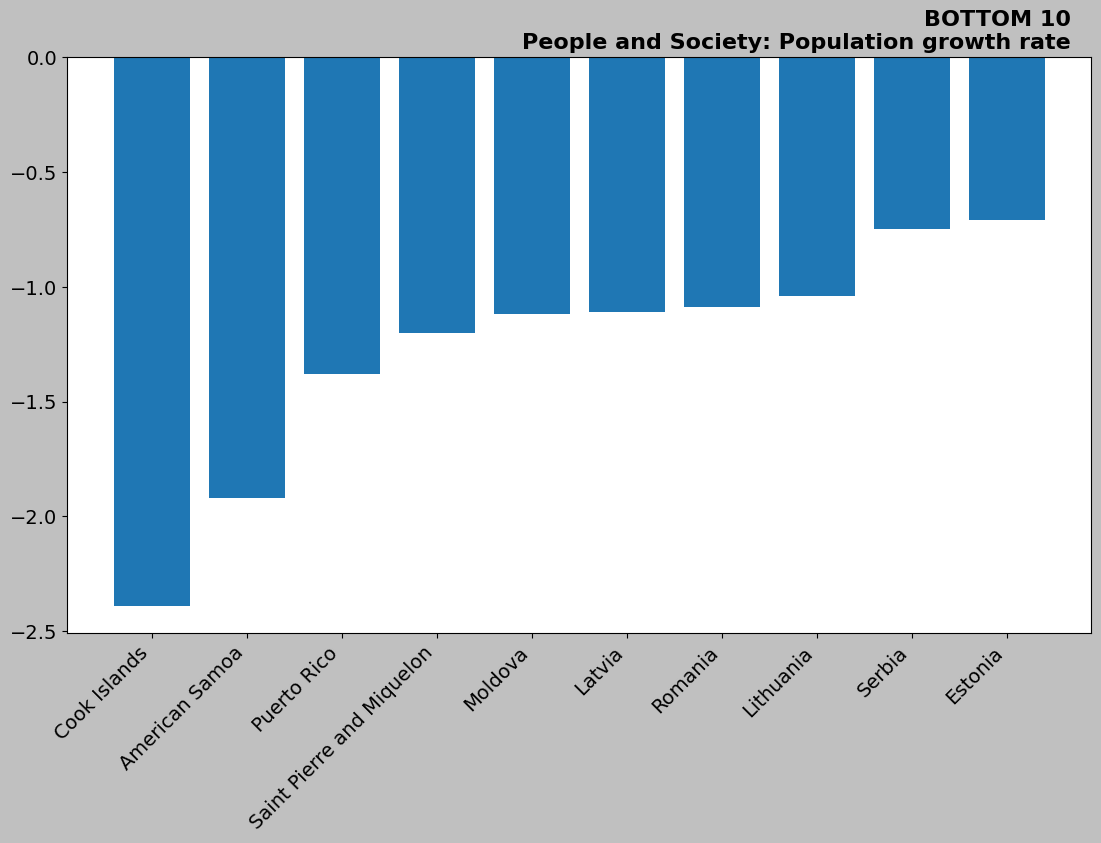

In [28]:

showMax( 'People and Society: Net migration rate', df, asc=True )
showMax( 'People and Society: Population growth rate', df, asc=True )

***
### COAL, ENGERY AND POLLUTION
#### Not a glitch: China's appetite
Just for scale, this is what the production of the top-ten coal producers looks 
like. 

Energy: Coal - Production


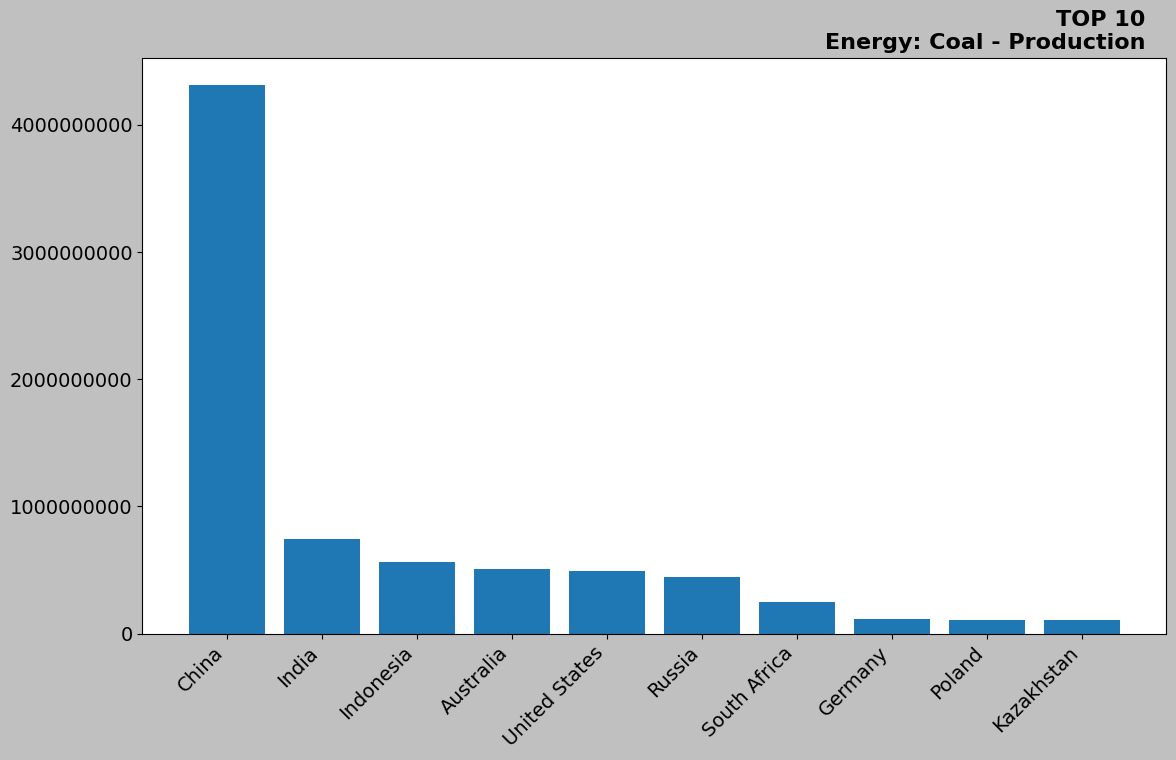

Z_SCORES OUTSIDE >+/<-[ 0.06 ] for non-NaNs in:
Energy: Coal - Production


CTRY_i         CTRY_n  Z_VAL          E_VAL  \
40       47          China 13.894 4314681000.000   
88      107          India  2.288  743214000.000   
89      108      Indonesia  1.704  563728000.000   
9        13      Australia  1.510  504051000.000   
201     243  United States  1.481  495130000.000   
..      ...            ...    ...            ...   
110     135        Liberia -0.128          0.000   
109     134        Lesotho -0.128          0.000   
108     133        Lebanon -0.128          0.000   
107     132         Latvia -0.128          0.000   
120     146          Malta -0.128          0.000   

                                       O_STR  
40     4,314,681,000 metric tons (2020 est.)  
88   743.214 million metric tons (2020 est.)  
89   563.728 million metric tons (2020 est.)  
9    504.051 million metric tons (2020 est.)  
201   495.13 million metric tons (2020 est.)  
..                                       ...  
110                0 metric tons (2020 est.)  
109                0 metric tons (2020 est.)  
108                0 metric tons (2020 est.)  
107                0 metric tons (2020 est.)  
120                0 metric tons (2020 est.)  

[202 rows x 5 columns]

Energy: Coal - Consumption


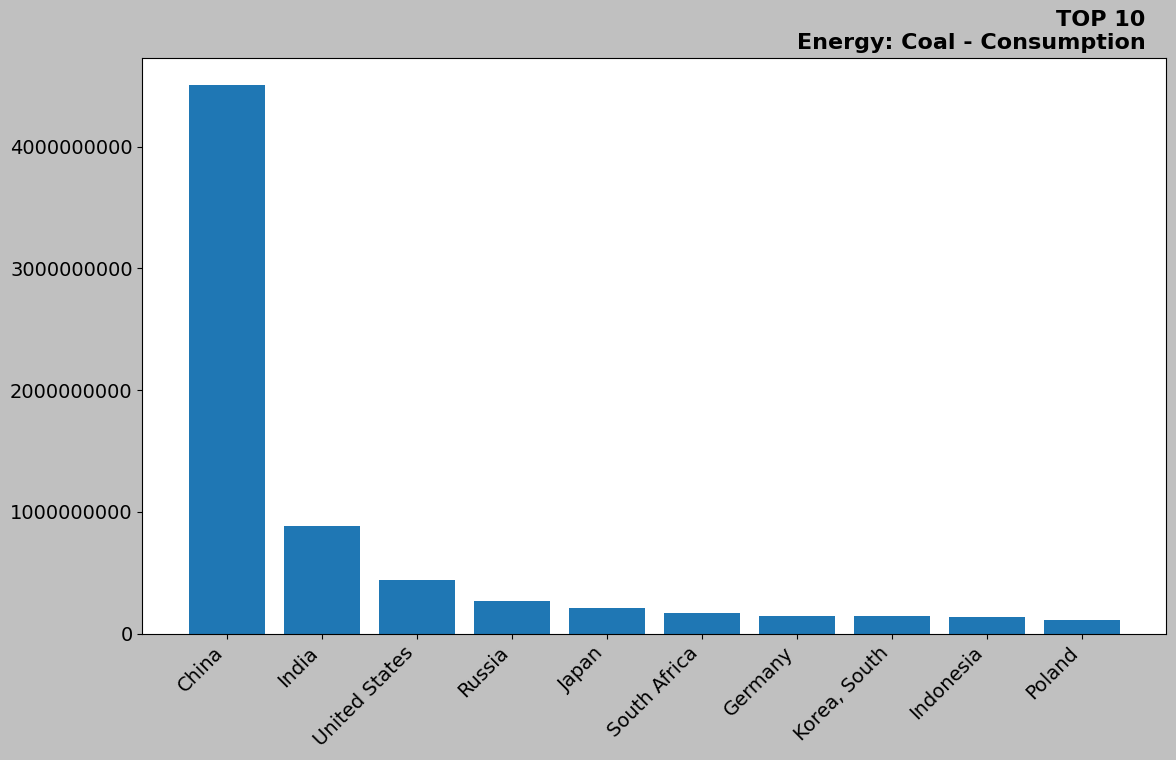

Z_SCORES OUTSIDE >+/<-[ 0.06 ] for non-NaNs in:
Energy: Coal - Consumption


CTRY_i             CTRY_n  Z_VAL          E_VAL  \
40       47              China 14.082 4506387000.000   
88      107              India  2.666  883979000.000   
201     243      United States  1.273  441968000.000   
156     191             Russia  0.718  266038000.000   
96      117              Japan  0.545  210882000.000   
..      ...                ...    ...            ...   
53       66           Dominica -0.120          0.000   
132     161              Nauru -0.120          0.000   
128     157         Montserrat -0.120          0.000   
58       71  Equatorial Guinea -0.120          0.000   
42       52            Comoros -0.120          0.000   

                                       O_STR  
40     4,506,387,000 metric tons (2020 est.)  
88   883.979 million metric tons (2020 est.)  
201  441.968 million metric tons (2020 est.)  
156  266.038 million metric tons (2020 est.)  
96   210.882 million metric tons (2020 est.)  
..                                       ...  
53                 0 metric tons (2020 est.)  
132                0 metric tons (2020 est.)  
128                0 metric tons (2020 est.)  
58                 0 metric tons (2020 est.)  
42                 0 metric tons (2020 est.)  

[201 rows x 5 columns]

In [29]:
showMax( 'Energy: Coal - Production', df )
zThresh( dfN, 'Energy: Coal - Production', 0.06, dfOR, ctrDct )
showMax( 'Energy: Coal - Consumption', df )
zThresh( dfN, 'Energy: Coal - Consumption', 0.06, dfOR, ctrDct )

# compare: Energy: Electricity - Consumption

- The only nation falling outside three standard deviations of the mean, falls 
outside by around ***fourteen*** standard deviations. More astonishingly, China 
remains a net importer - they consume this and more. 
- From production to consumption, Australia disappears down to 199th in the 
world; quite a feat for the fourth-largest producer, whereas the rest of the 
top ten producers are in the top ten consumers (excepting Kazakhstan, who drops 
out similarly as consumer to 197th).

In [30]:
# update this to return a percap or perGDP ranking.
getRank( df, 'Australia', 'Energy: Coal - Consumption' )
getRank( df, 'Kazakhstan', 'Energy: Coal - Consumption' )

With value of [ 99048000.0 ], Australia is 199th-highest for:
'Energy: Coal - Consumption'
(out of total 256 ranked)
With value of [ 74819000.0 ], Kazakhstan is 197th-highest for:
'Energy: Coal - Consumption'
(out of total 256 ranked)


Some figures in greater detail:

In [31]:
prodFeat = 'Energy: Coal - Production'
consFeat = 'Energy: Coal - Consumption'

chinaProd = df[ df.Country == 'China' ][ prodFeat ].sum()
chinaCsmp = df[ df.Country == 'China' ][ consFeat ].sum()

notChinaProd = df[ df.Country != 'China' ][ prodFeat ].sum()
notChinaCsmp = df[ df.Country != 'China' ][ consFeat ].sum()

# get longest string length to pad report field
pad = (max( [ len( str( i ) )
    for i in [ chinaProd, notChinaProd, chinaCsmp, notChinaCsmp ] ] ))

print( f"PRODUCTION: China's production is "
       f"[ {(chinaProd / notChinaProd):,.2f} ] times that of the rest of world\n"
       f"   [ {chinaProd:>{pad},.2f} ]: China's coal production\n"
       f"   [ {notChinaProd:>{pad},.2f} ]: rest of world combined\n" )
print( f"\nCONSUMPTION: China's consumption is "
       f"[ {(chinaCsmp / notChinaCsmp):,.2f} ] times the size\n"
       f"of the rest of world combined.\n"
       f"   [ {chinaCsmp:>{pad},.2f} ]: China's coal consumption\n"
       f"   [ {notChinaCsmp:>{pad},.2f} ]: rest of world combined\n" )

PRODUCTION: China's production is [ 1.09 ] times that of the rest of world
   [ 4,314,681,000.00 ]: China's coal production
   [ 3,972,154,000.00 ]: rest of world combined


CONSUMPTION: China's consumption is [ 1.28 ] times the size
of the rest of world combined.
   [ 4,506,387,000.00 ]: China's coal consumption
   [ 3,532,889,000.00 ]: rest of world combined



***
- We can get an image of a country's **relationship with coal** if we look at the 
combined production and imports in ratio to exports. Where this ratio is above 
one, a country has exported above the total produced and imported, meaning it 
has sold reserves. Refining further to only the countries whose coal exports 
are above the world-mean, we can see who has a strong reliance on coal exports. 
</br> </br> In order, the refinement exludes Venezuela, Belarus and Eswatini such that 
Russia, South Africa and the Phillipines entered the t10 "sellers"

Coal: Exports-to-Total-Holdings ratio


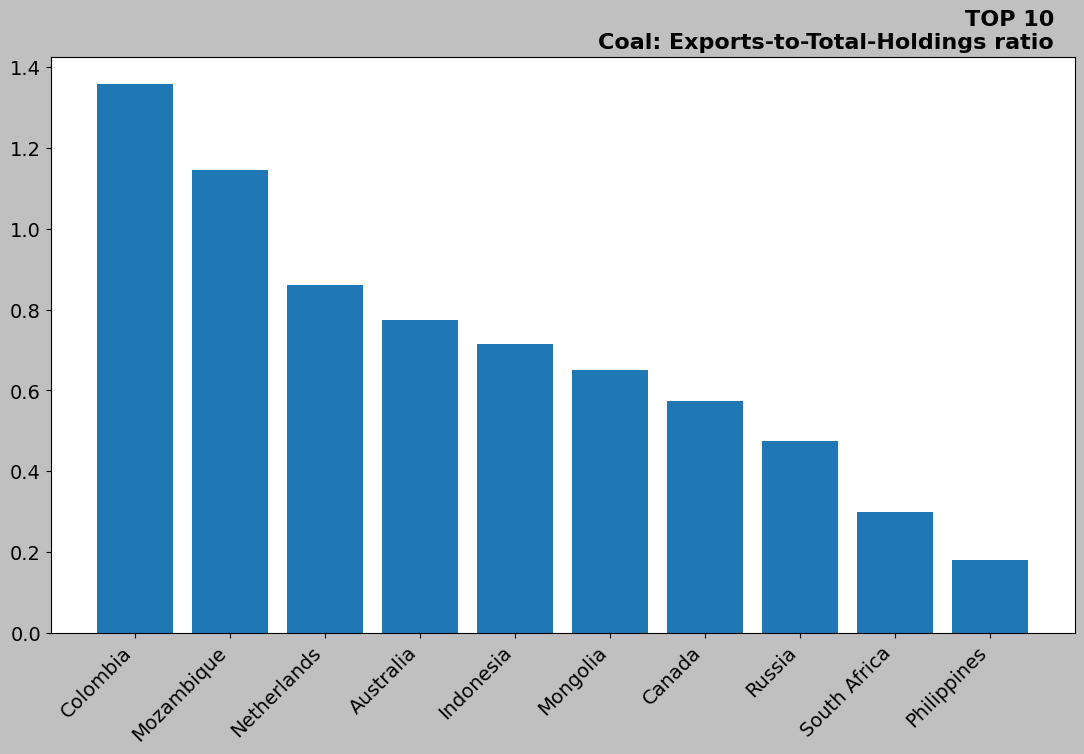

In [32]:
df[ 'Coal: Exports-to-Total-Holdings ratio' ] = (
    df[ 'Energy: Coal - Exports' ] /
    (df[ 'Energy: Coal - Production' ] +
     df[ 'Energy: Coal - Imports' ]))

aboveMeans = [ country for country in df[ 'Country' ] if (
    df.loc[ df[ 'Country' ] == country, 'Energy: Coal - Exports' ].iloc[ 0 ]
    >= df[ 'Energy: Coal - Exports' ].mean()) ]

showMax( 'Coal: Exports-to-Total-Holdings ratio',
    df[ df[ 'Country' ].isin( aboveMeans ) ] )

Naturally, on the topic of coal, a look at the top CO2 emitters:

CO2 EMISSIONS

Environment: Air pollutants - carbon dioxide emissions


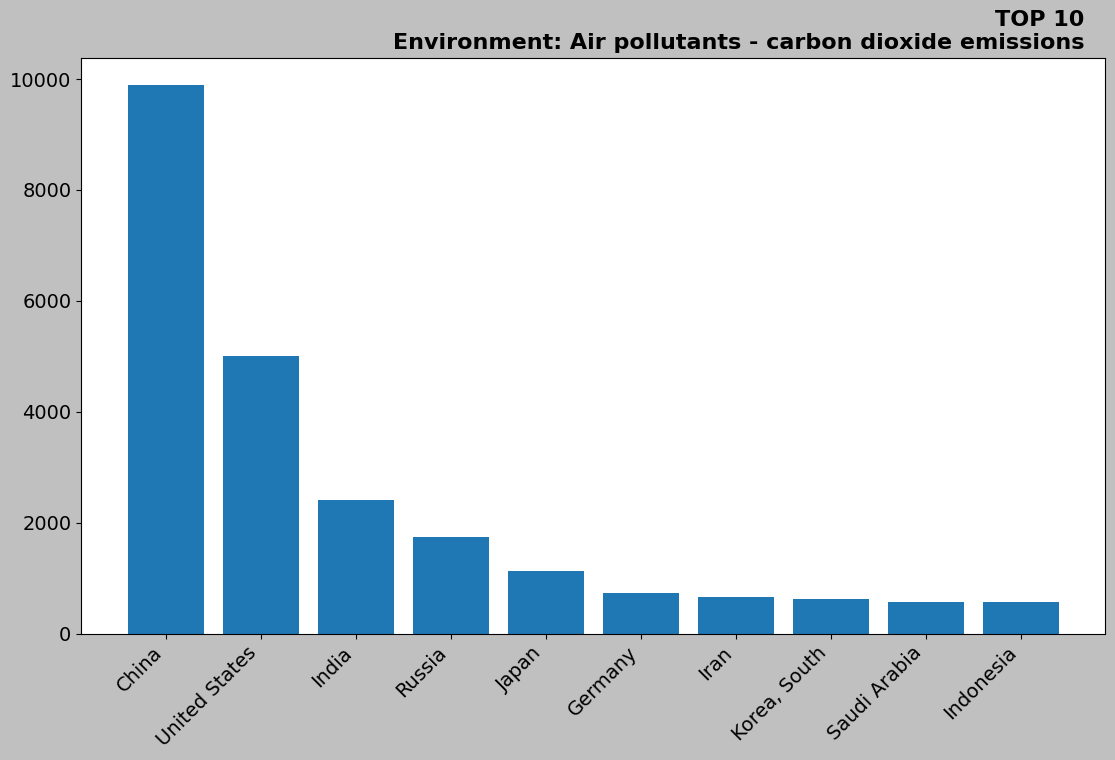

Feats: [ Energy: Coal - Consumption ]
       [ Energy: Carbon dioxide emissions - From coal and metallurgical coke ]


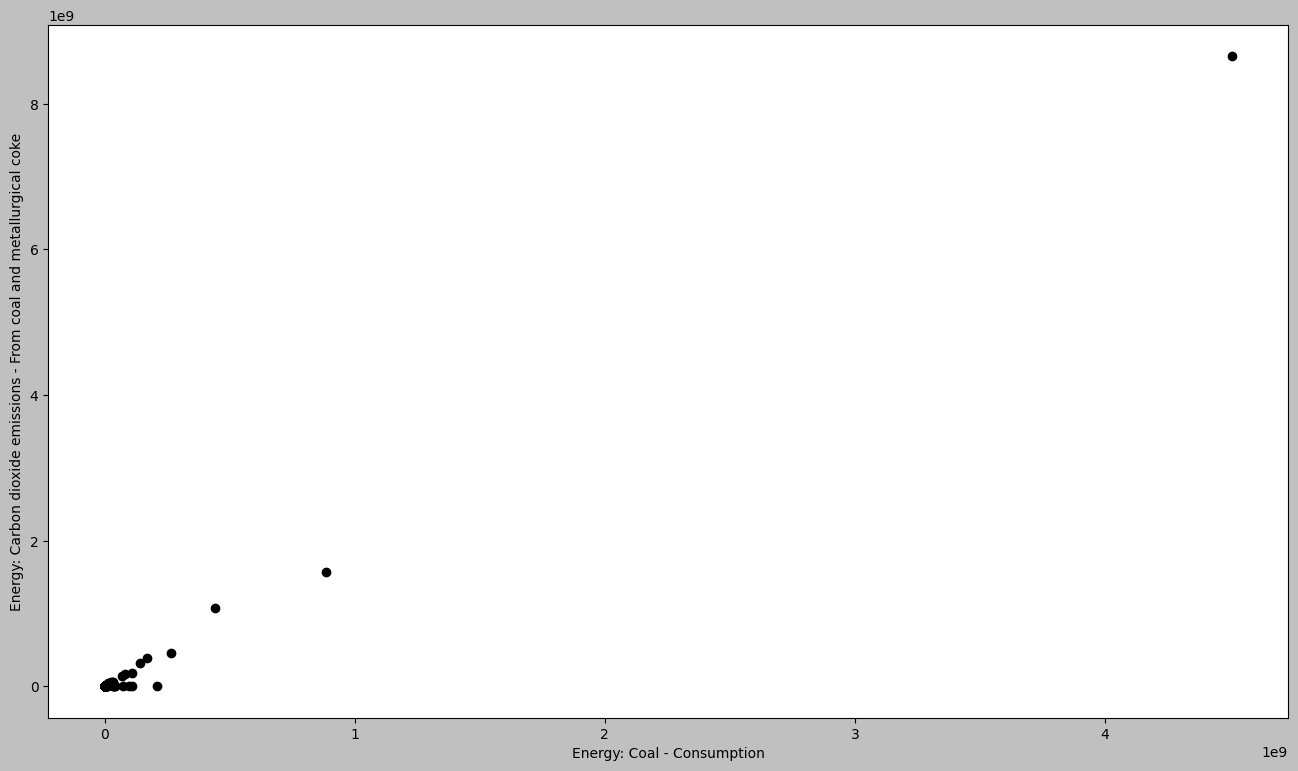

Coal/Metalurgical CO2 emissions BY Coal consumption


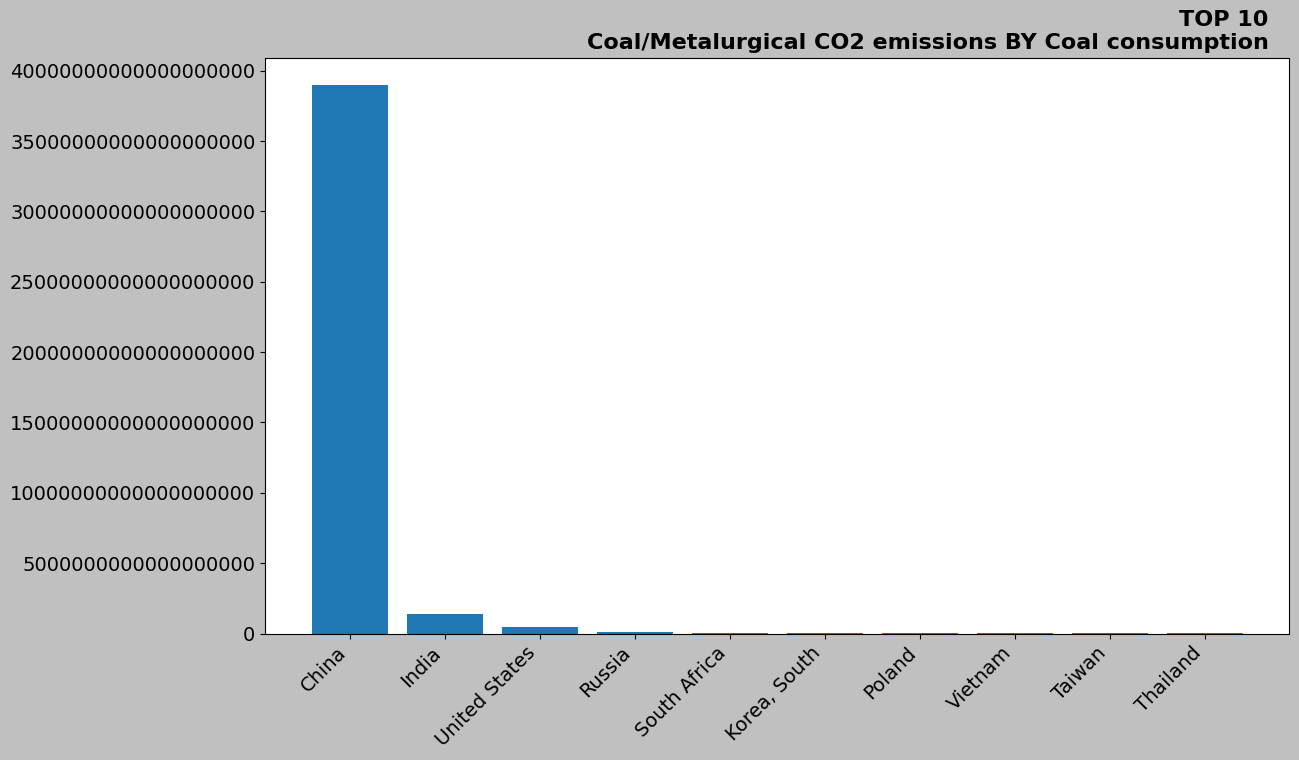

Coal/Metalurgical CO2 emissions PER Coal consumption


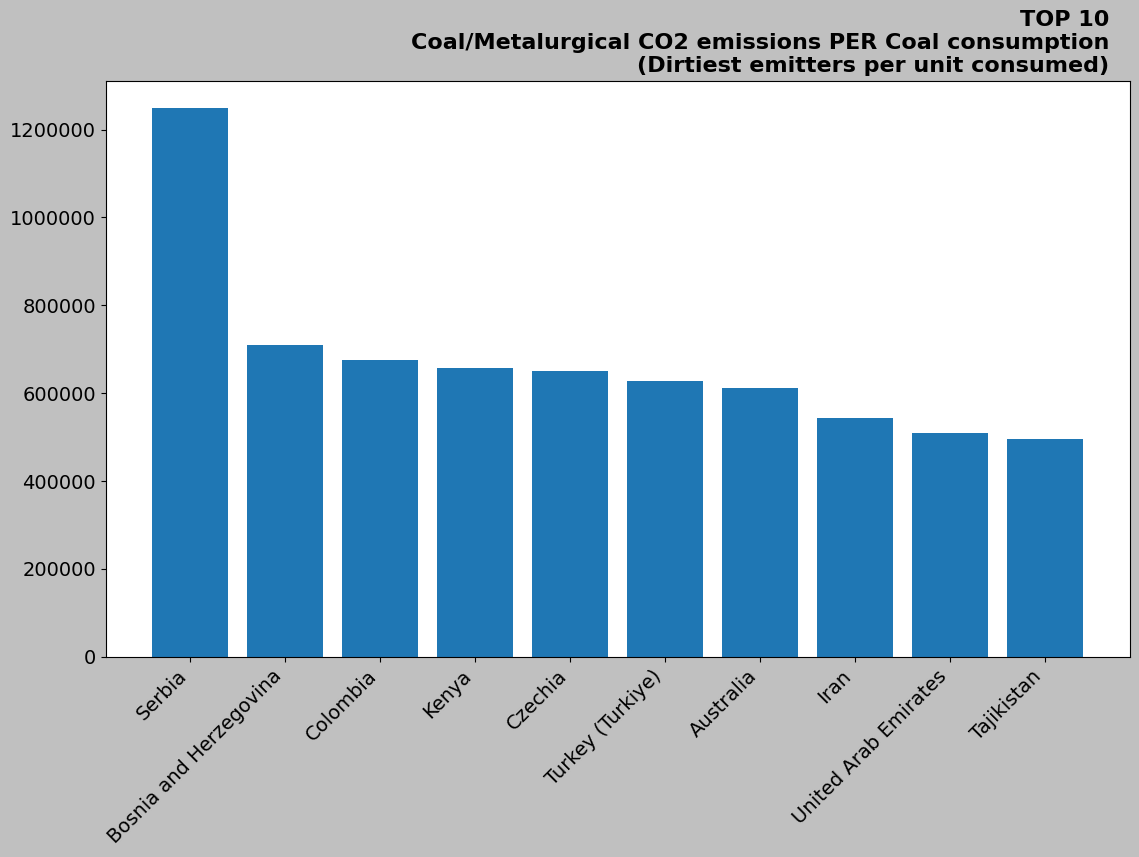

Coal/Metalurgical CO2 emissions PER Coal consumption


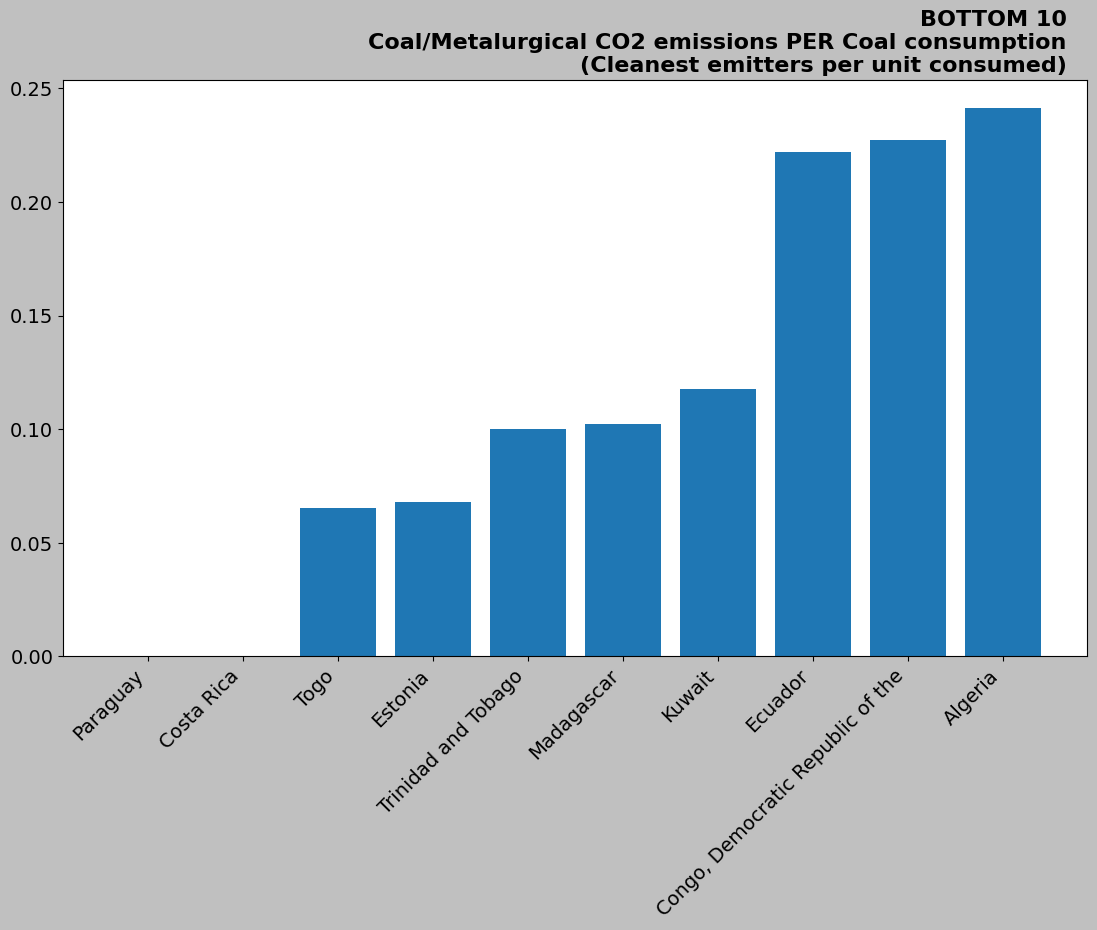

With value of [ 1000.0 ], Costa Rica is 110th-highest for:
'Energy: Carbon dioxide emissions - From coal and metallurgical coke'
(out of total 256 ranked)


With value of [ 0.0 ], Costa Rica is 0th-highest for:
'Energy: Coal - Consumption'
(out of total 256 ranked)
TIED WITH 85 COUNTRIES


With value of [ 3000.0 ], Paraguay is 111th-highest for:
'Energy: Carbon dioxide emissions - From coal and metallurgical coke'
(out of total 256 ranked)


With value of [ 0.0 ], Paraguay is 0th-highest for:
'Energy: Coal - Consumption'
(out of total 256 ranked)
TIED WITH 85 COUNTRIES




In [33]:
showMax( 'Environment: Air pollutants - carbon dioxide emissions', df )
#   China leads by twice its nearest competitor, the US.
# Similar stats for Environment: Air pollutants - methane emission.

# The world's clustering for CO2 emissions vs coal consumption
#   China off in the distance
yFeat = 'Energy: Carbon dioxide emissions - From coal and metallurgical coke'
pltSctr( df, [ 'Energy: Coal - Consumption', yFeat ] )

# identifying the extremes (each x by common y). 
df[ 'Coal/Metalurgical CO2 emissions BY Coal consumption' ] = (
    df[ yFeat ] * df[ 'Energy: Coal - Consumption' ])

showMax( 'Coal/Metalurgical CO2 emissions BY Coal consumption', df )

# While we are looking at these features, an interesting insight:
#   Scoring the dirtiest coal consumption. Hi there Australia!

df[ 'Coal/Metalurgical CO2 emissions PER Coal consumption' ] = (
    df[ 'Energy: Coal - Consumption' ] / df[ yFeat ])

showMax( 'Coal/Metalurgical CO2 emissions PER Coal consumption', df,
    sub='Dirtiest emitters per unit consumed' )
showMax( 'Coal/Metalurgical CO2 emissions PER Coal consumption', df,
    sub='Cleanest emitters per unit consumed', asc=True )

# Missing data for costa rica and paraguay?  - go back and dropna
for country in [ "Costa Rica", "Paraguay" ]:
    for feat in [
        'Energy: Carbon dioxide emissions - From coal and metallurgical coke',
        'Energy: Coal - Consumption'
        ]: getRank( df, country, feat ); print( '\n' )


Kenya % Geothermal
In places where tectonic plates – consisting of the Earth's crust, and the 
upper mantle – are being pushed together or torn apart, this heat rises closer 
to the surface. One such place is Africa's Great Rift Valley, which runs 
7,000km (4,350 miles) across the eastern side of the continent.

Energy: Electricity generation sources - Geothermal


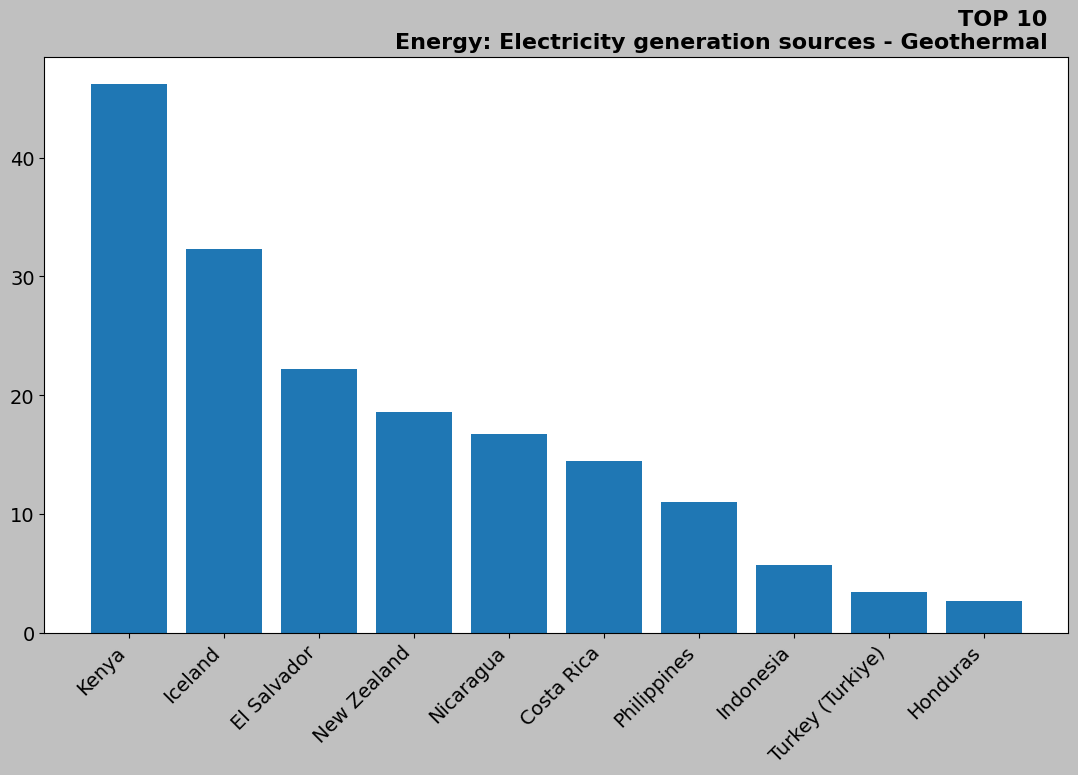

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
Energy: Electricity generation sources - Geothermal


CTRY_i       CTRY_n  Z_VAL  E_VAL  \
99      123        Kenya  9.733 46.200   
87      106      Iceland  6.749 32.300   
56       70  El Salvador  4.580 22.200   
135     166  New Zealand  3.807 18.600   
136     167    Nicaragua  3.399 16.700   
45       57   Costa Rica  2.927 14.500   

                                             O_STR  
99   46.2% of total installed capacity (2020 est.)  
87   32.3% of total installed capacity (2020 est.)  
56   22.2% of total installed capacity (2020 est.)  
135  18.6% of total installed capacity (2020 est.)  
136  16.7% of total installed capacity (2020 est.)  
45   14.5% of total installed capacity (2020 est.)

In [34]:
ft = 'Energy: Electricity generation sources - Geothermal'
showMax( ft, df )
_ = zThresh( dfN, ft, 2.5, dfOR, ctrDct )

#### ECONOMY

Feats: [ Economy: Budget - revenues ]
       [ Economy: Budget - expenditures ]


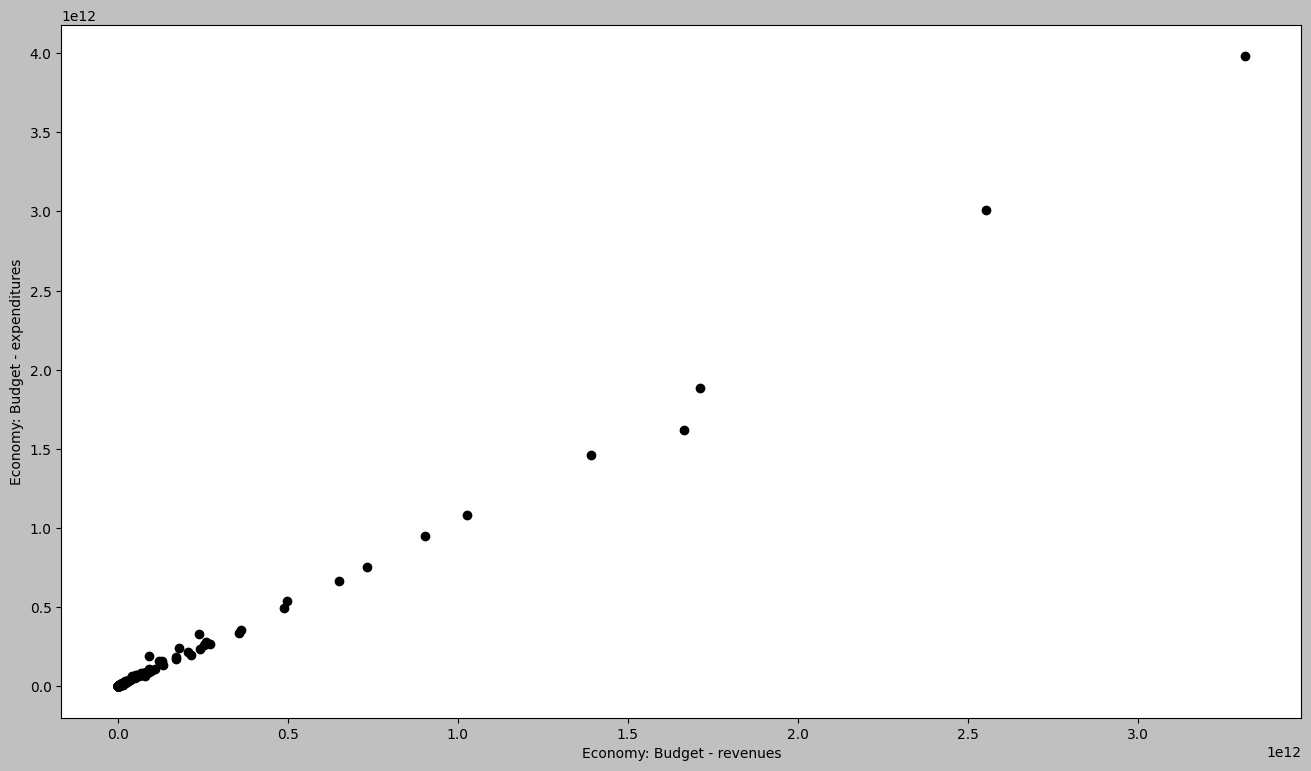

Economy: Real GDP (purchasing power parity)


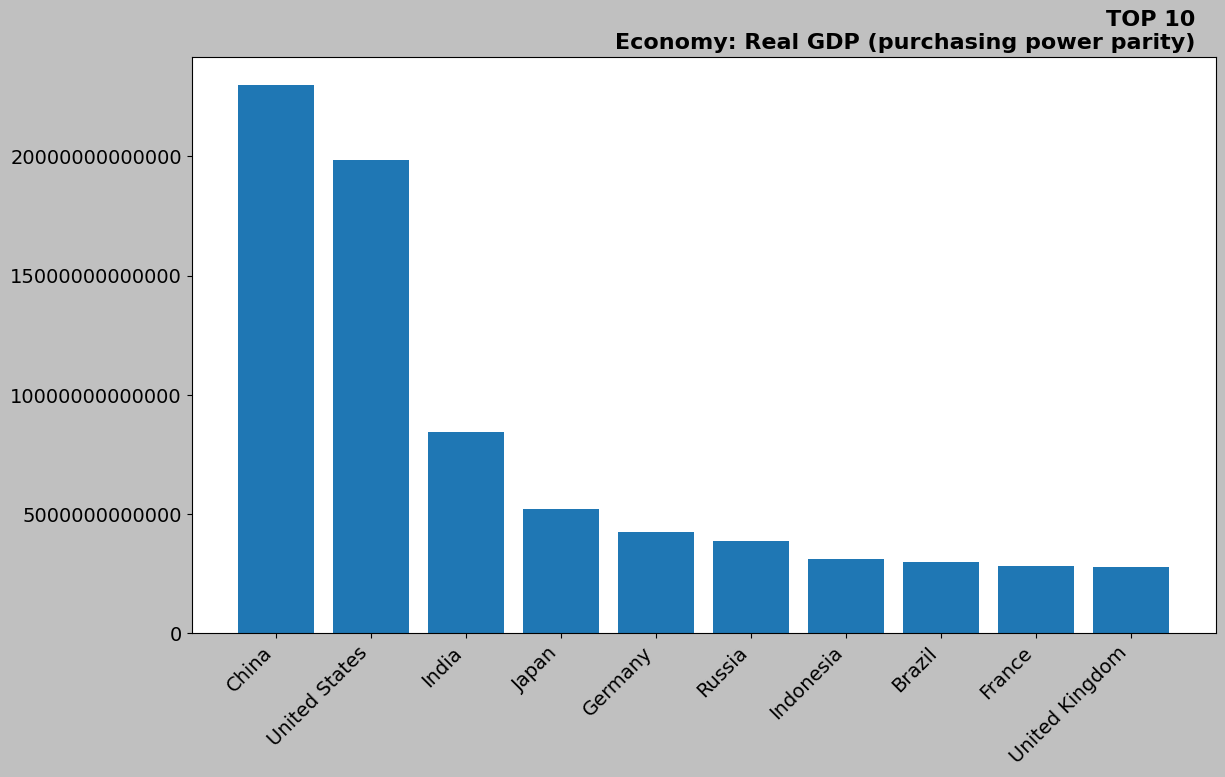

Economy: Real GDP (purchasing power parity)


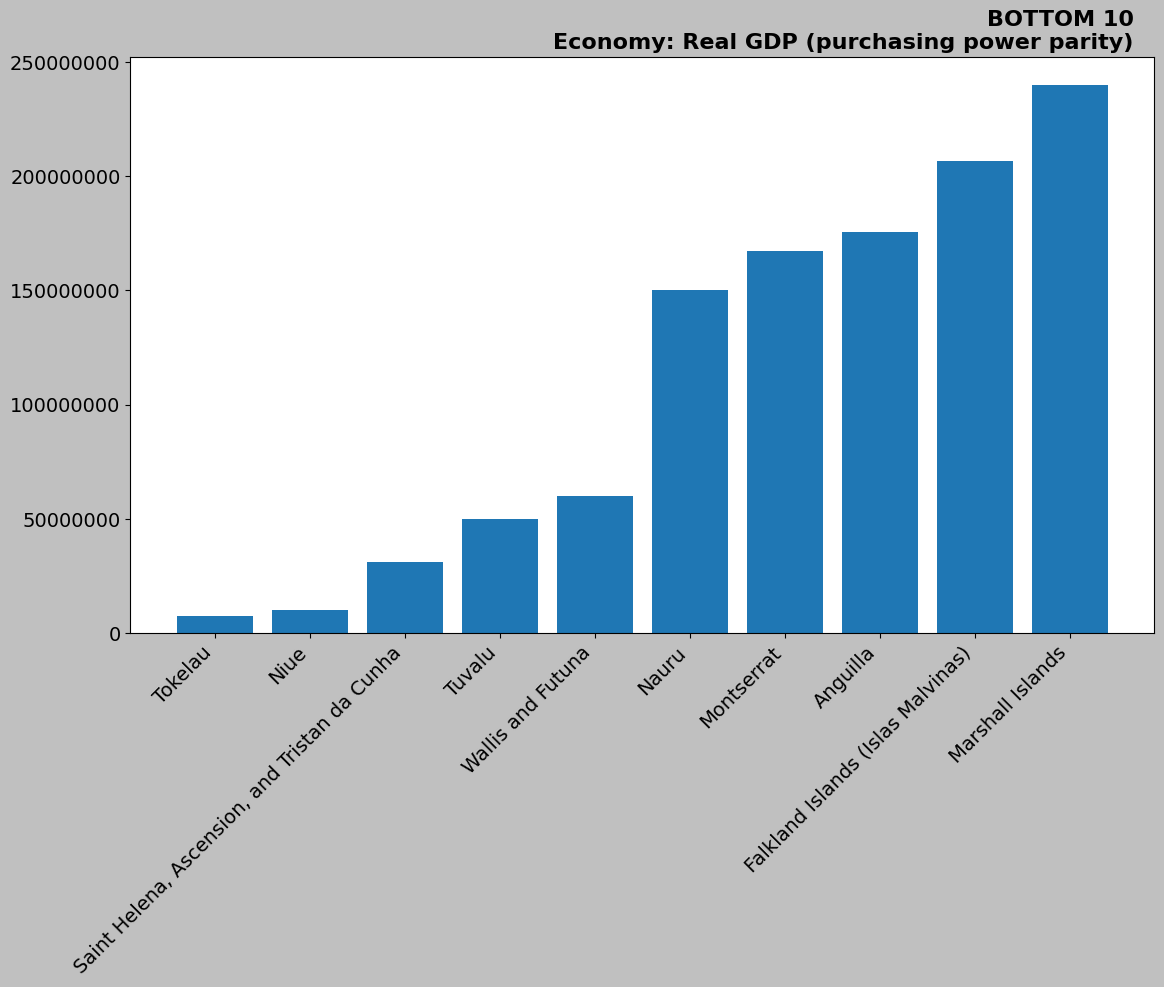

Economy: GDP - composition, by sector of origin - services


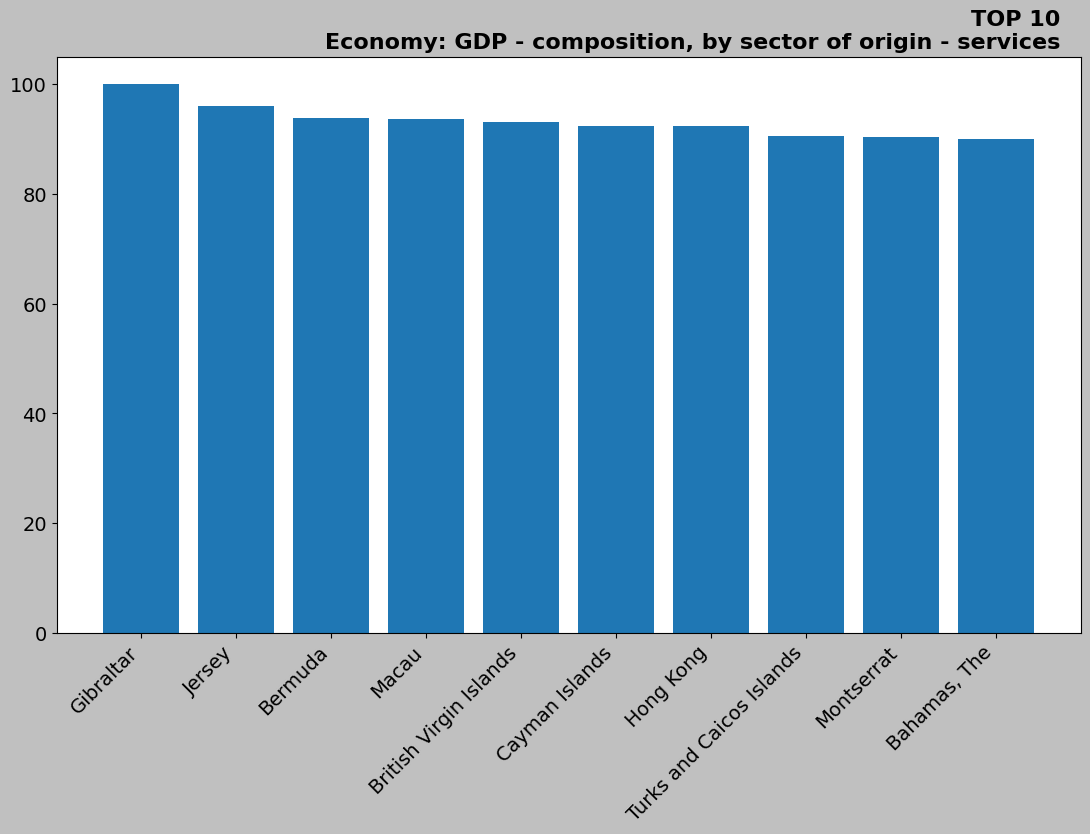

Economy: GDP - composition, by end use - household consumption


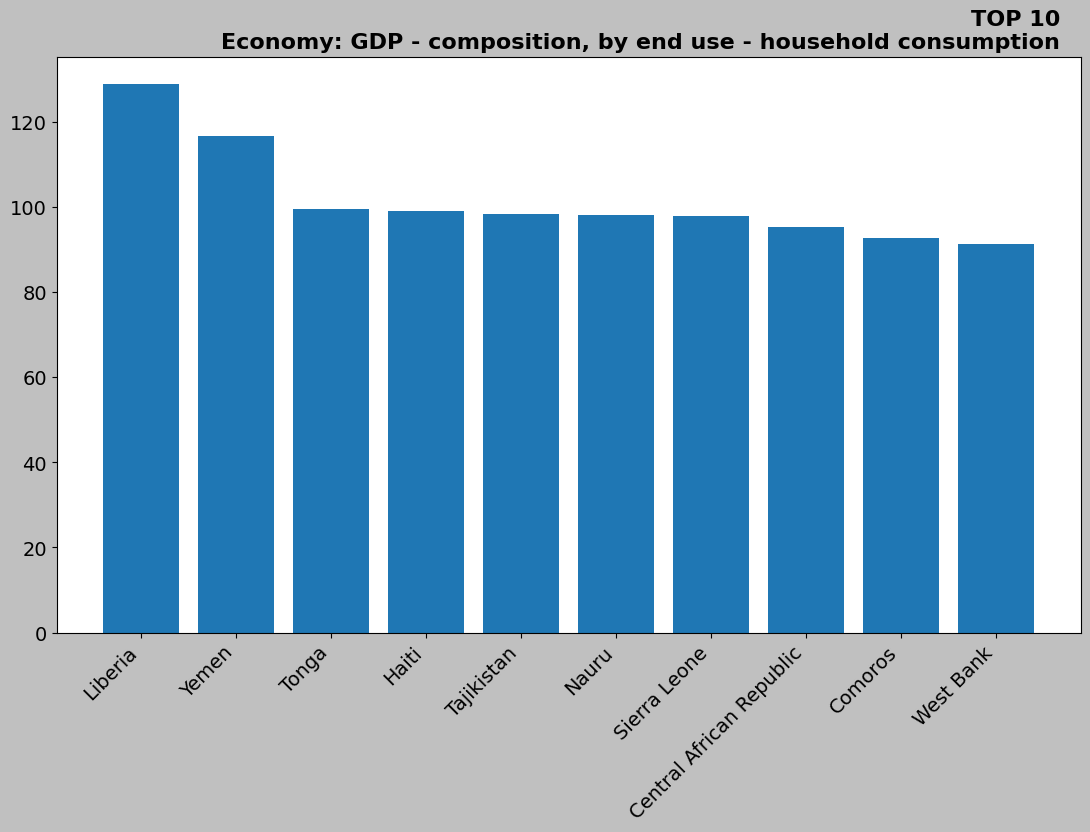

Economy: GDP - composition, by end use - household consumption


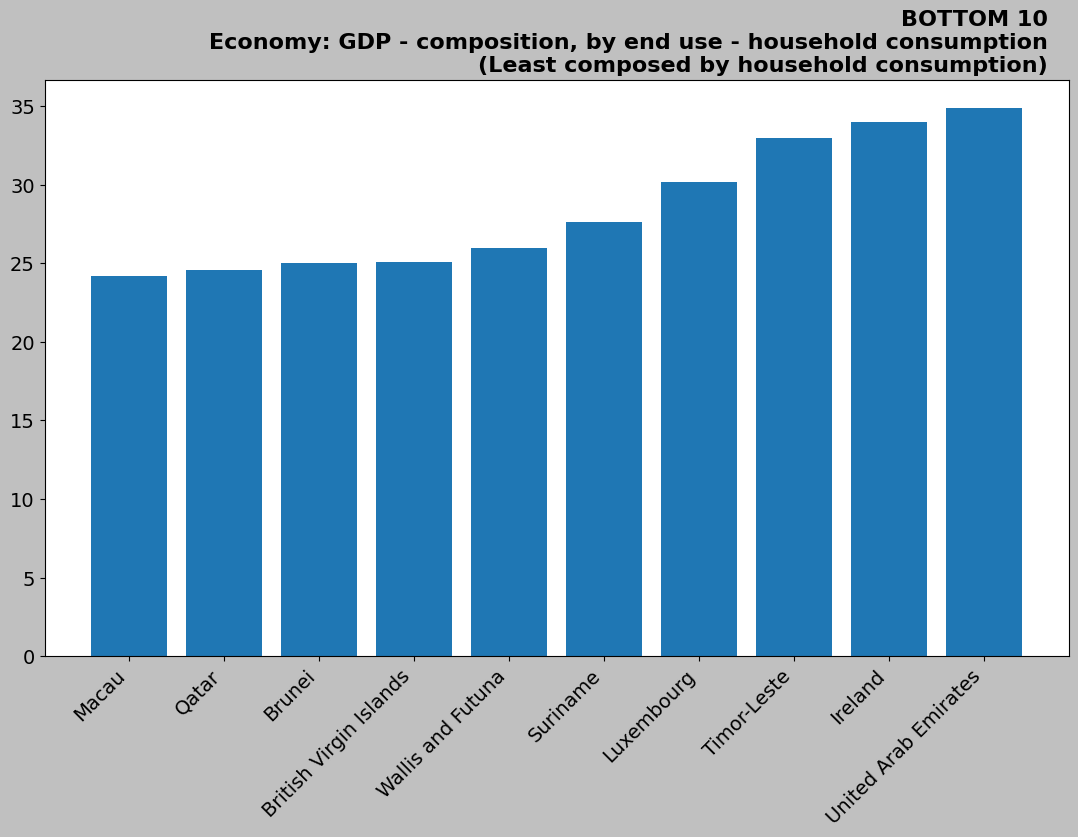

Economy: Inflation rate (consumer prices)


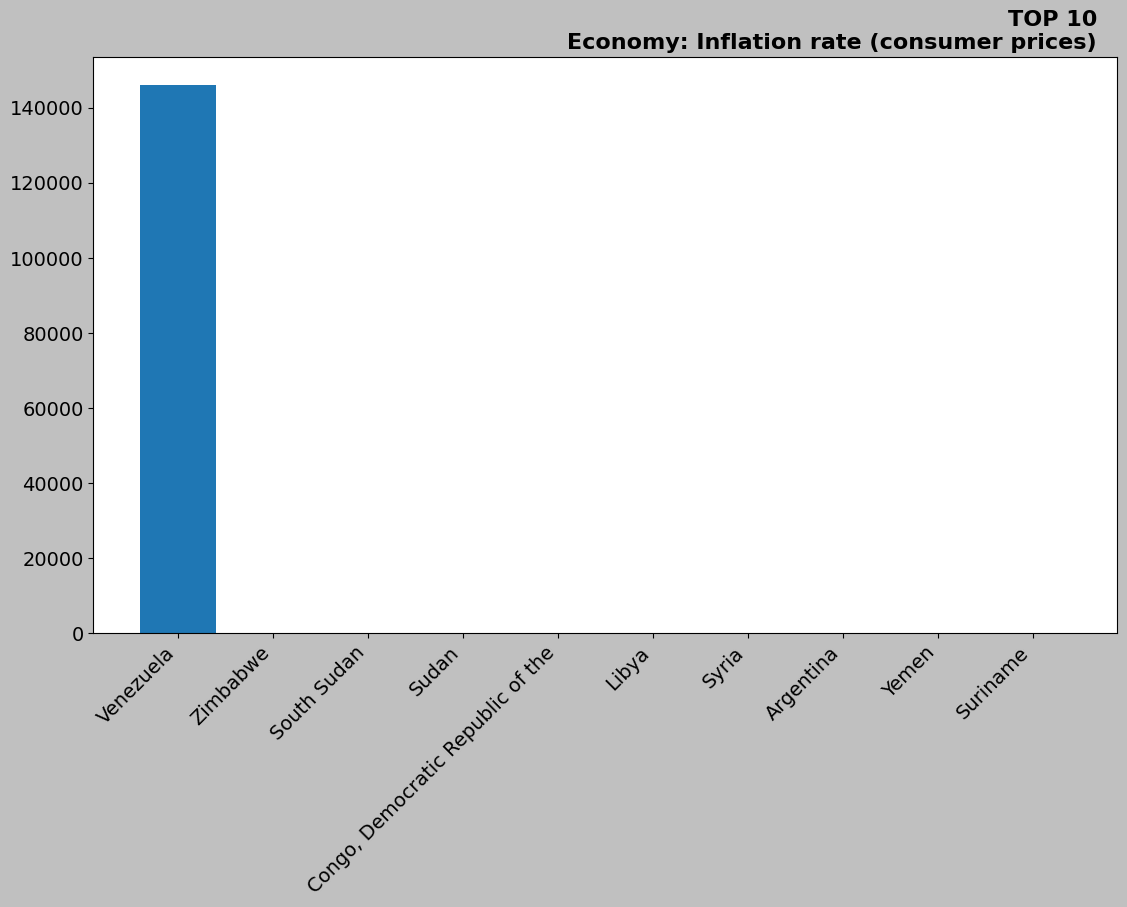

Economy: Inflation rate (consumer prices)


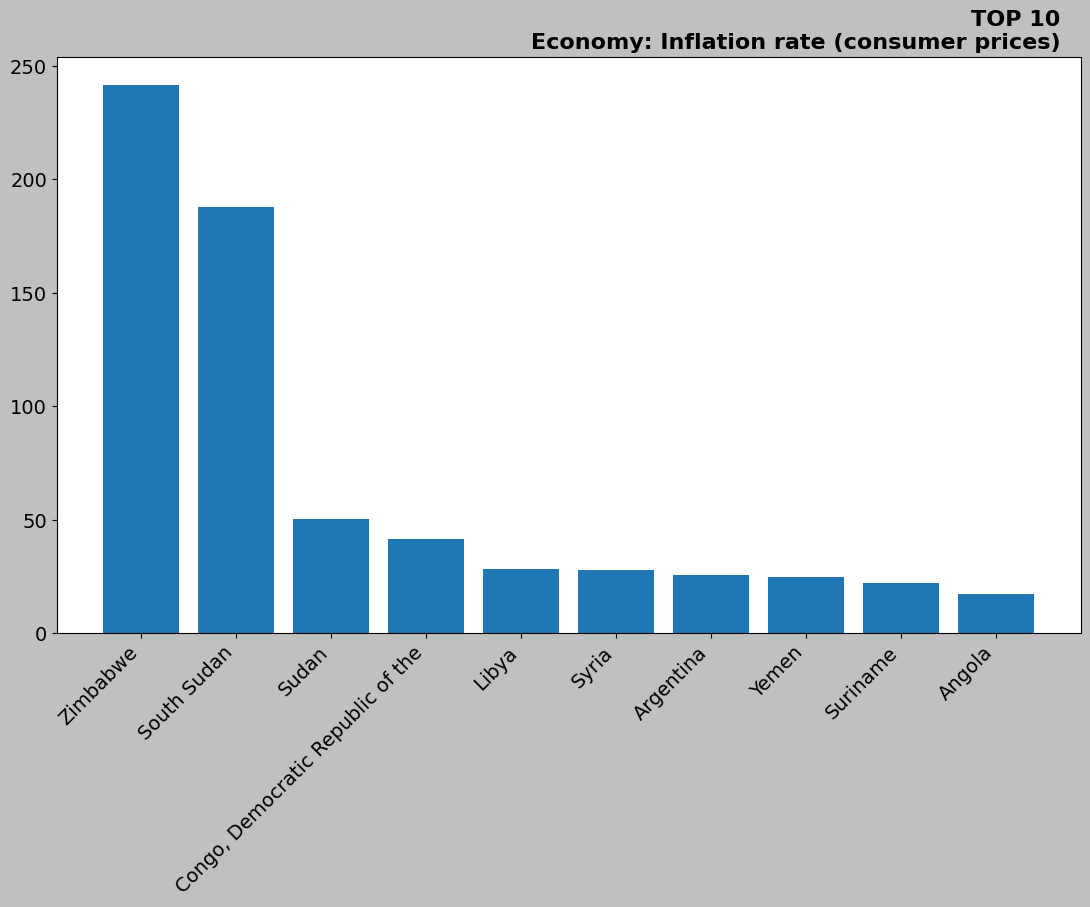

Economy: Inflation rate (consumer prices)


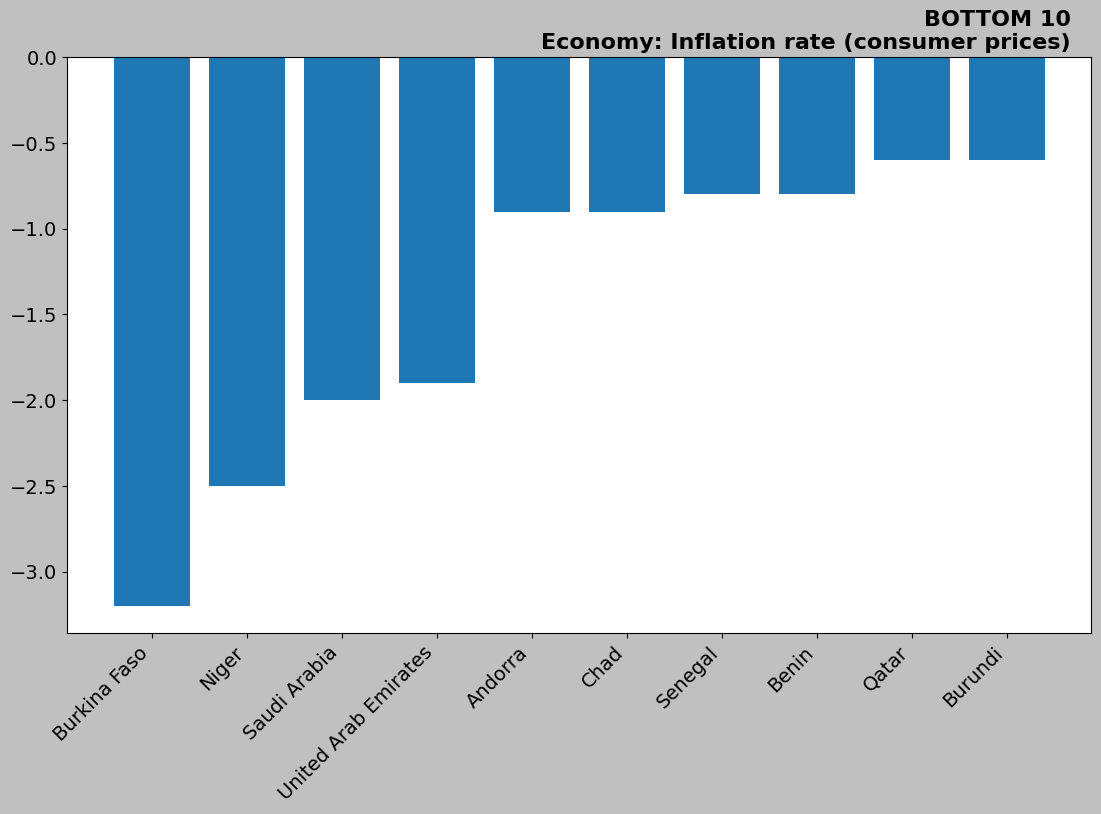

In [35]:
# If you tend to assume that countries usually spend close to what they make in 
#   revenue, take confidence from seeing how both rise together in 
#   very close proportion all the way from lowest to highest.
pltSctr( df, [
    'Economy: Budget - revenues',
    'Economy: Budget - expenditures' ] )

# GDP
showMax( 'Economy: Real GDP (purchasing power parity)', df )
showMax( 'Economy: Real GDP (purchasing power parity)', df, asc=True )
# Economy: Real GDP growth rate
# Economy: Real GDP per capita
# Economy: GDP (official exchange rate)
# Niue, Tokelau and Monstserrat consistenlty coming up in econ-B10s

# Interesting: which sovereignties pay the bills almost entirely from desk-work?
showMax( 'Economy: GDP - composition, by sector of origin - services', df )

# GDP driven by household spending. Interesting enough, but how can Liberia and 
#   Yemen be >100%?
# Economy: GDP - composition, by end use - household consumption
showMax( 'Economy: GDP - composition, by end use - household consumption', df )
showMax( 'Economy: GDP - composition, by end use - household consumption',
    df, asc=True, sub="Least composed by household consumption" )
# Economy: GDP - composition, by end use - government consumption
# Economy: GDP - composition, by end use - investment in fixed capital
# Economy: GDP - composition, by end use - investment in inventories

# Again, many places have >100% GDP from exports:
# Economy: GDP - composition, by end use - exports of goods and services
# on this topic: Maldives is a startling sole-case of GDP from G-S imports.
#   Economy: GDP - composition, by end use - imports of goods and services

# Inflation
#   Venezuela dwarfs the world.
showMax( 'Economy: Inflation rate (consumer prices)', df )
showMax( 'Economy: Inflation rate (consumer prices)',
    df[ df[ 'Country' ] != 'Venezuela' ] )  # without Venezueal
showMax( 'Economy: Inflation rate (consumer prices)', df, asc=True )

Labour force as a percentage of population


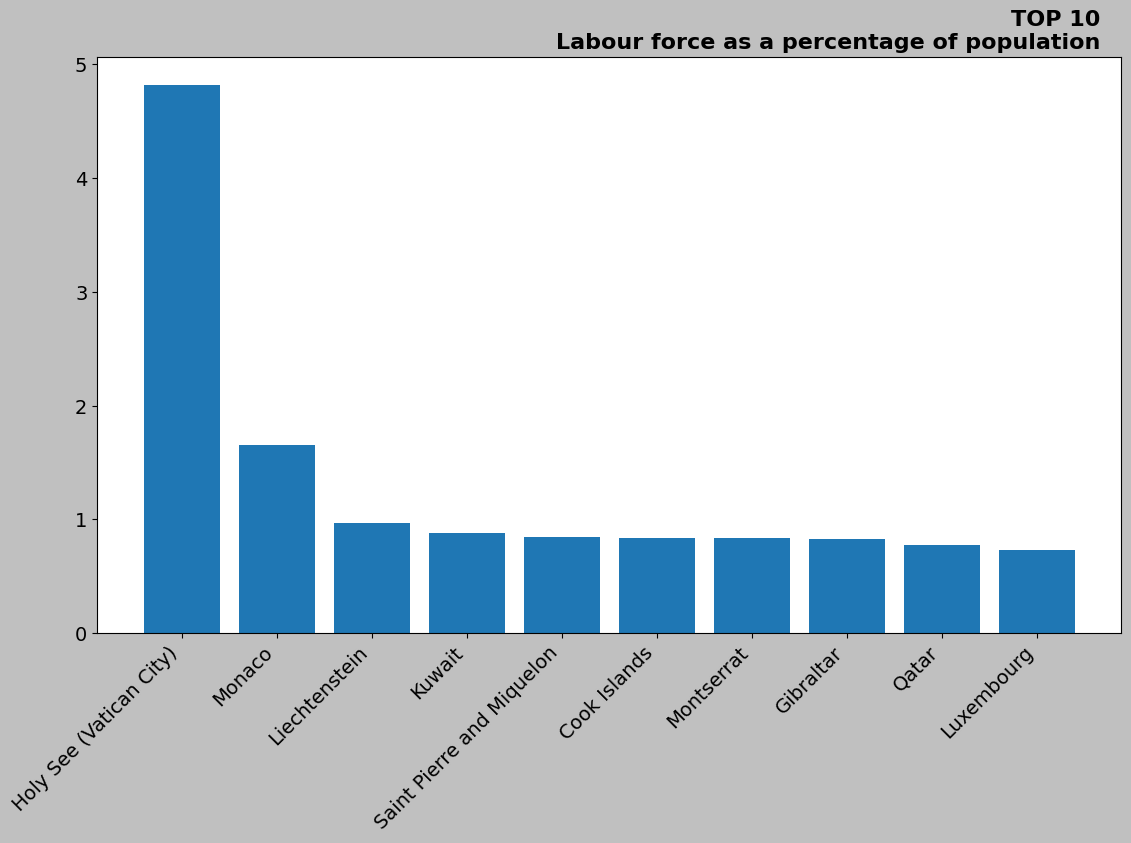

Labour force as a percentage of population


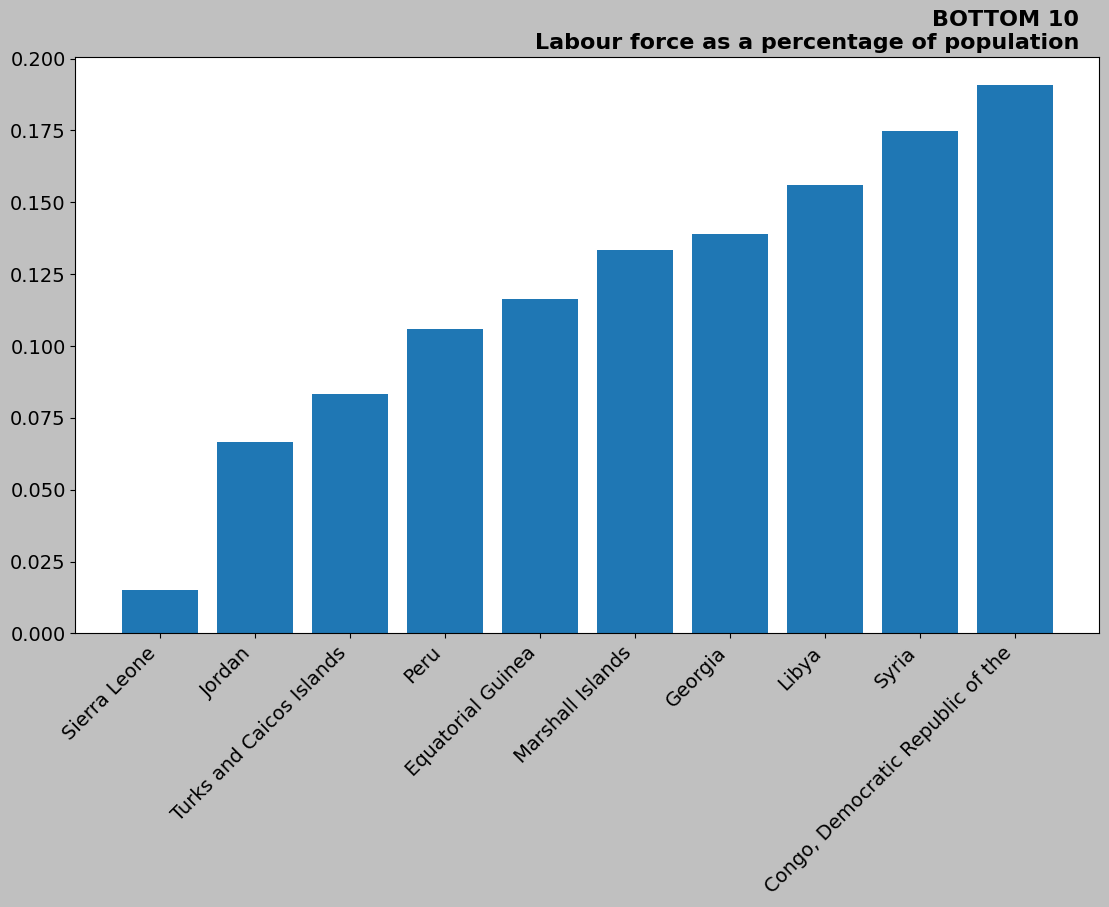

In [36]:
# compare with pop: Economy: Labor force
# Labour force as a percentage of population. 
# LForce obviously includes migrant workers. 
df[ 'Labour force as a percentage of population' ] = (
    df[ 'Economy: Labor force' ] /
    df[ 'People and Society: Population' ])

showMax( 'Labour force as a percentage of population', df )
showMax( 'Labour force as a percentage of population', df, asc=True )
# In these countries, even including cross-border commuters, there is less than
#   0.2 of a "labour force" indiv. for every indiv. counted in the population.

Economy: Labor force - by occupation - agriculture


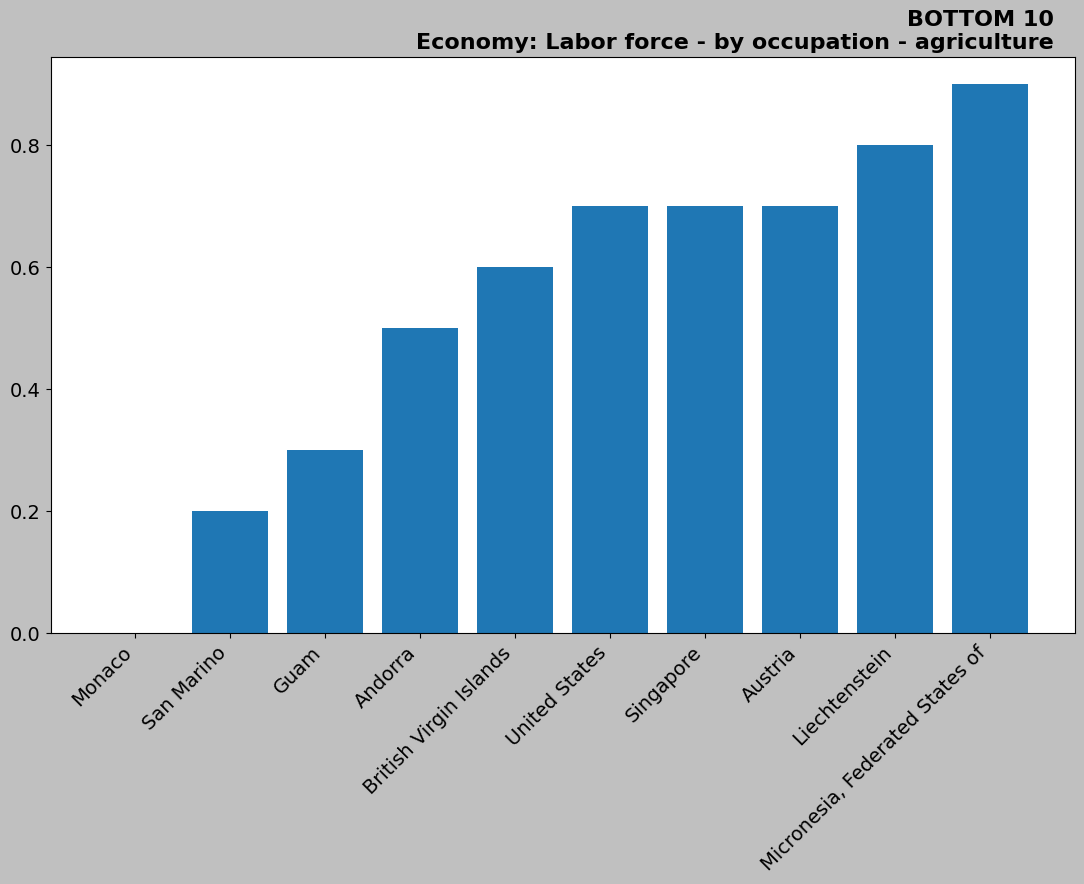

Agriculture: GDP composition to labour


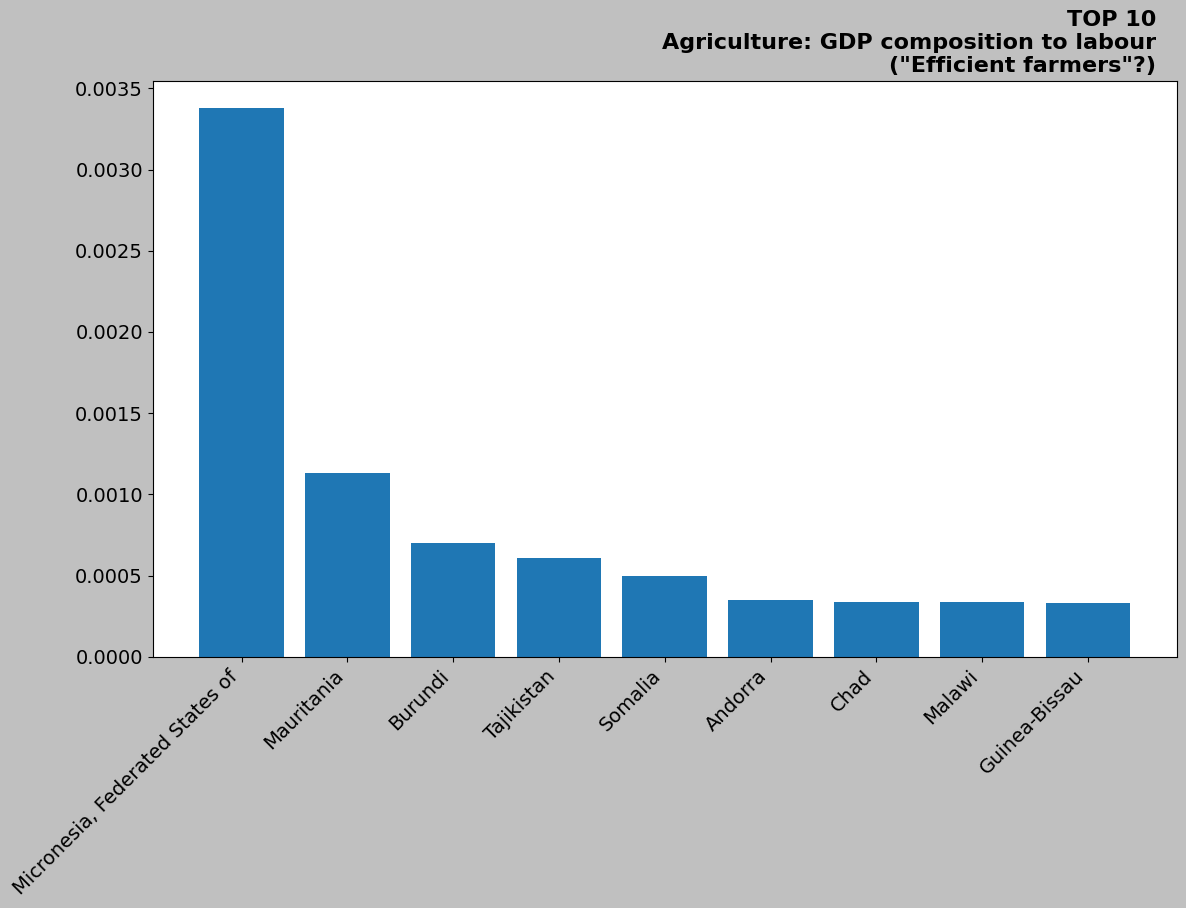

In [37]:
dfPop = df[ [
    'Country',
    'People and Society: Population',
    'Economy: Labor force',
    'Economy: Labor force - by occupation - agriculture' ] ]

tongaLforce = dfPop[ dfPop[ 'Country' ] == "Tonga" ]

# Error in the data for Tonga (date taken as percent)
# Excluding Tonga, the surprise in the bottom ten is the USA - only ~0.7% of 
#   workers are in agriculture?
showMax( 'Economy: Labor force - by occupation - agriculture',
    df[ df[ 'Country' ] != "Tonga" ], asc=True )

# TONGA labour force stats all error (taken date as value)
# print(dfOR[ 'Economy: Labor force - by occupation - agriculture' ].loc[ dfOR[ 'Country' ] == 'Tonga' ].values[ 0 ])
# print(dfFbDict['Economy: Labor force - by occupation - agriculture']['matchedNums'])

# Leads to the question: who has the highest Agri-portion of GDP in ratio to
#   the Agri-portion of the labour force (an estimate of agri-automation?)

df[ 'Agriculture: GDP composition to labour' ] = ((
    df[ 'Economy: GDP - composition, by sector of origin - agriculture' ] /
    df[ 'Economy: GDP (official exchange rate)' ])) / ((
    df[ 'Economy: Labor force - by occupation - agriculture' ] /
    df[ 'Economy: Labor force' ]))

showMax( 'Agriculture: GDP composition to labour',
    df[ df[ 'Country' ] != "Tonga" ], sub="\"Efficient farmers\"?" )

Economy: Gini Index coefficient - distribution of family income


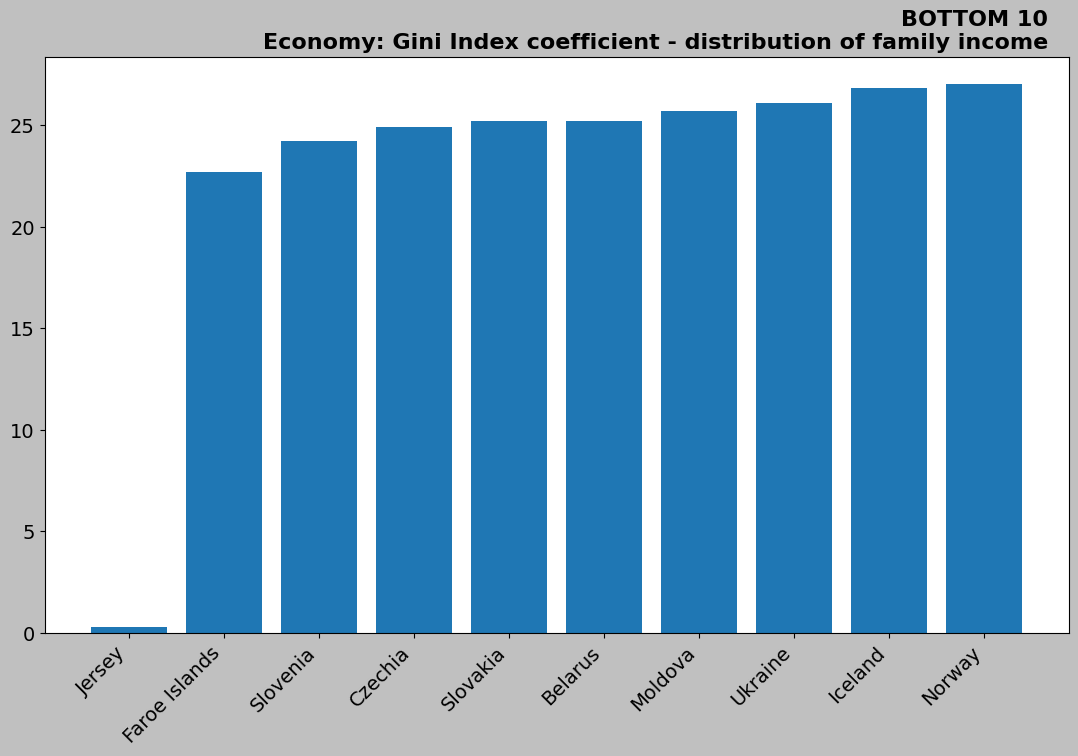

Economy: Gini Index coefficient - distribution of family income


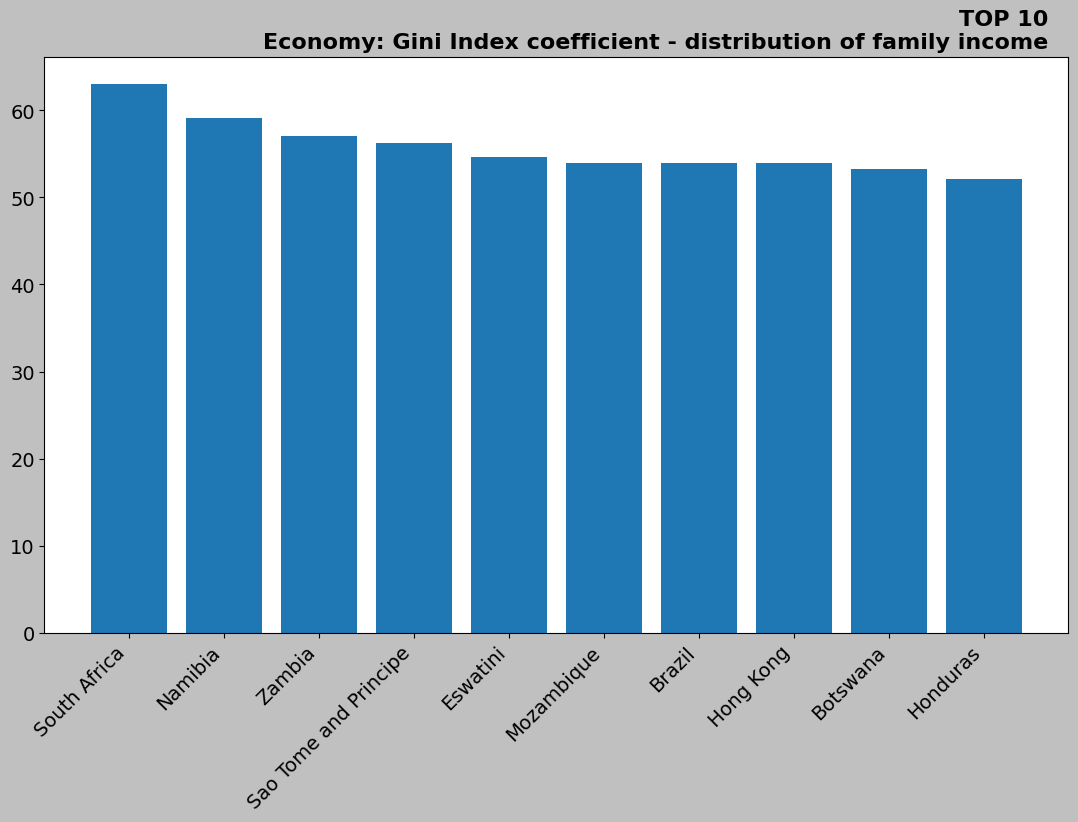

Economy: GDP - composition, by sector of origin - services


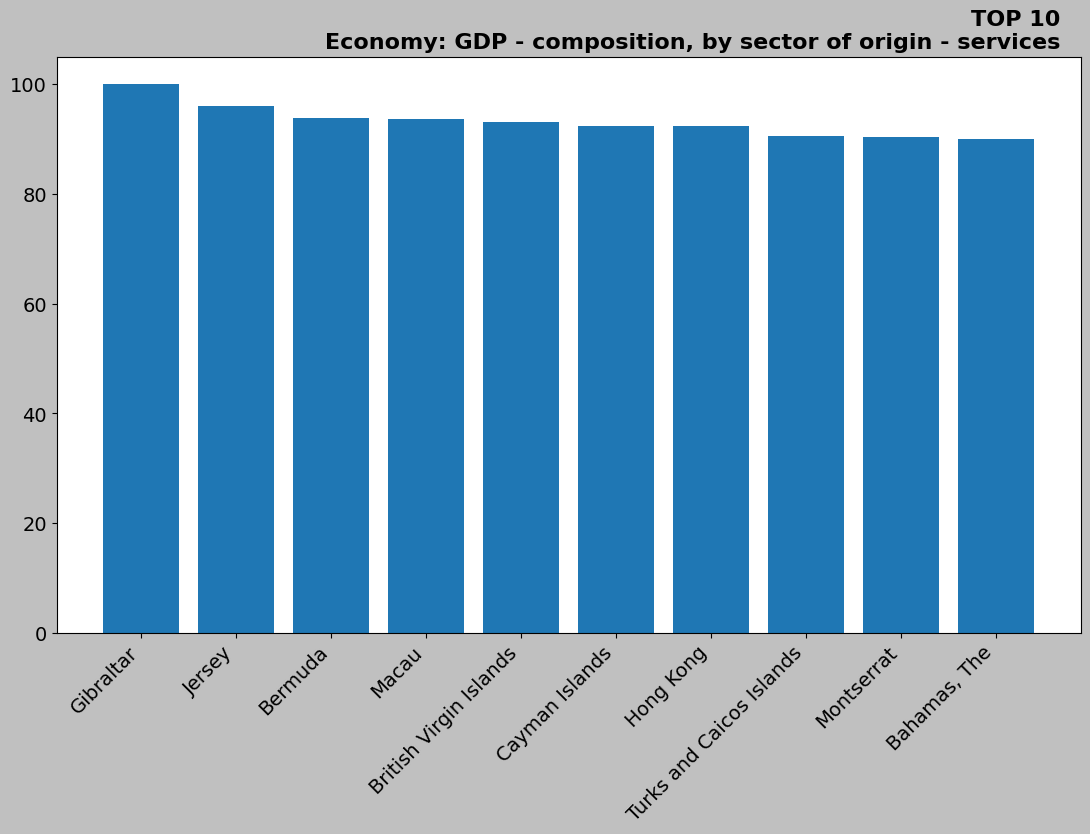

Economy: GDP - composition, by end use - government consumption


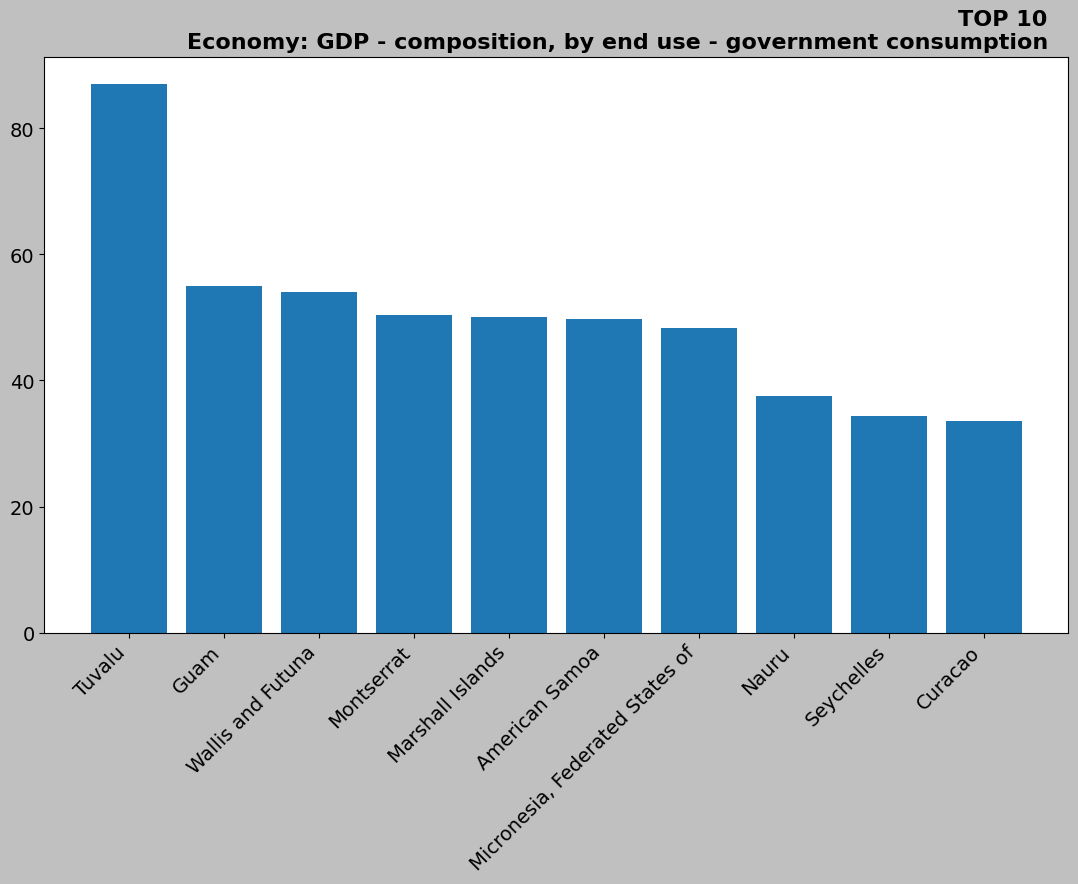

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
Economy: GDP - composition, by end use - government consumption


CTRY_i                           CTRY_n  Z_VAL  E_VAL              O_STR
189     238                           Tuvalu  7.103 87.000    87% (2016 est.)
77       93                             Guam  3.786 55.000    55% (2016 est.)
201     251                Wallis and Futuna  3.682 54.000         54% (2005)
125     157                       Montserrat  3.309 50.400  50.4% (2017 est.)
117     147                 Marshall Islands  3.268 50.000    50% (2016 est.)
2         3                   American Samoa  3.236 49.700  49.7% (2016 est.)
121     151  Micronesia, Federated States of  3.102 48.400  48.4% (2016 est.)

Economy: GDP - composition, by end use - imports of goods and services


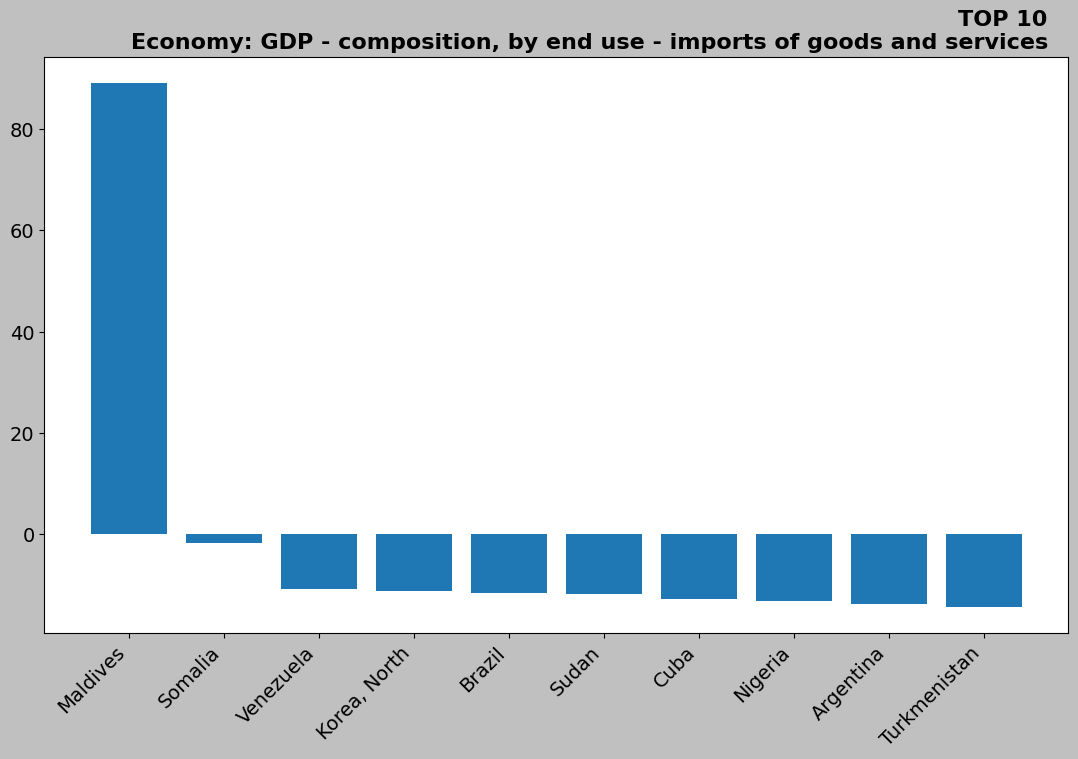

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
Economy: GDP - composition, by end use - imports of goods and services


CTRY_i       CTRY_n  Z_VAL    E_VAL                O_STR
115     144     Maldives  4.758   89.000      89% (2016 est.)
151     188  Puerto Rico -2.808 -129.800  -129.8% (2017 est.)
167     208    Singapore -3.476 -149.100  -149.1% (2017 est.)
160     201   San Marino -3.621 -153.300       -153.3% (2011)
83      103    Hong Kong -4.790 -187.100  -187.1% (2017 est.)
110     139   Luxembourg -5.029 -194.000    -194% (2017 est.)

Economy: Industrial production growth rate


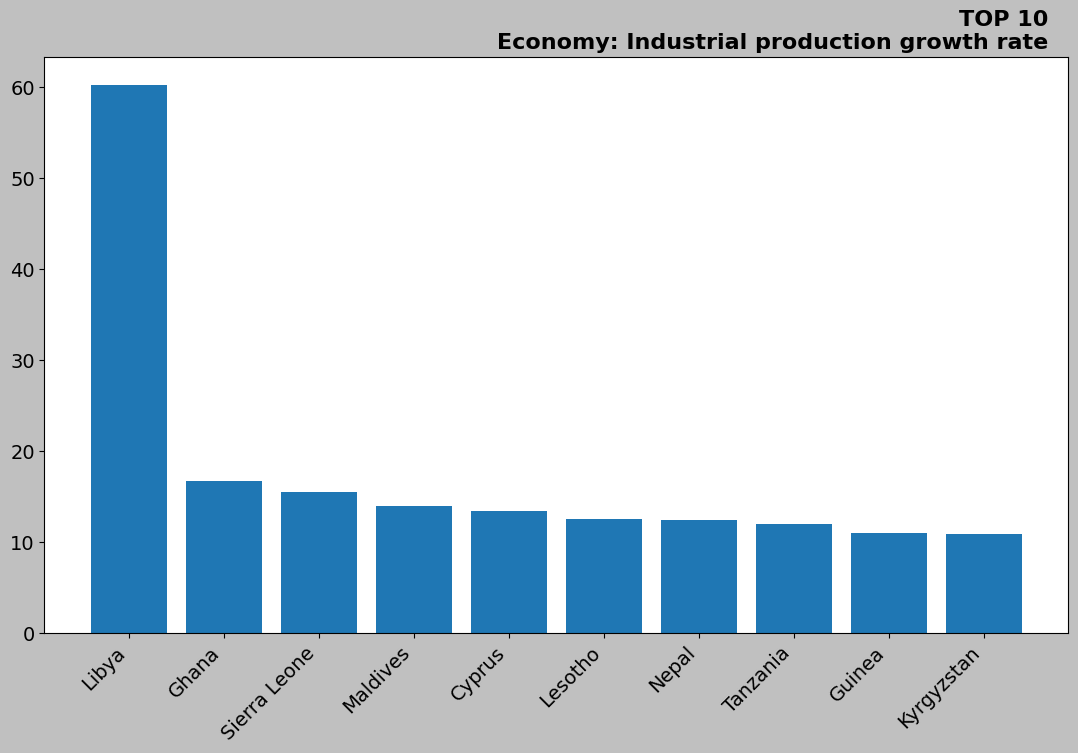

Z_SCORES OUTSIDE >+/<-[ 2.5 ] for non-NaNs in:
Economy: Industrial production growth rate


CTRY_i      CTRY_n  Z_VAL   E_VAL               O_STR
105     136       Libya  8.694  60.300   60.3% (2017 est.)
122     157  Montserrat -3.694 -21.000    -21% (2017 est.)
102     133     Lebanon -3.709 -21.100  -21.1% (2017 est.)
185     238      Tuvalu -4.471 -26.100  -26.1% (2012 est.)

In [38]:
# The most-equal countries have a strong representation of East 
# Eurpoean countries, along with Social Democracy commentators' darling, 
#   Norway. Jersey and Faroe would need to be more closely vetted.
showMax( 'Economy: Gini Index coefficient - distribution of family income',
    df, asc=True )

# The least-equal countries most strongly feature Southern African nations.
showMax( 'Economy: Gini Index coefficient - distribution of family income',
    df )

# not hard to see where all the accountants live
ft = 'Economy: GDP - composition, by sector of origin - services'
showMax( ft, df )

# why is GDP-by-gov-consump t10 purely small island-states?
ft = 'Economy: GDP - composition, by end use - government consumption'
showMax( ft, df )
_ = zThresh( dfN, ft, 2.5, dfOR, ctrDct )

# gdp-by-imports: maldives only positive, and vastly so [...]
# 
ft = 'Economy: GDP - composition, by end use - imports of goods and services'
showMax( ft, df )
_ = zThresh( dfN, ft, 2.5, dfOR, ctrDct )

# libya experiencing the largest indust. growth by fair
# 
ft = 'Economy: Industrial production growth rate'
showMax( ft, df )
_ = zThresh( dfN, ft, 2.5, dfOR, ctrDct )

#### GEOGRAPHY AND ENVIRONMENT

Geography: Area - total


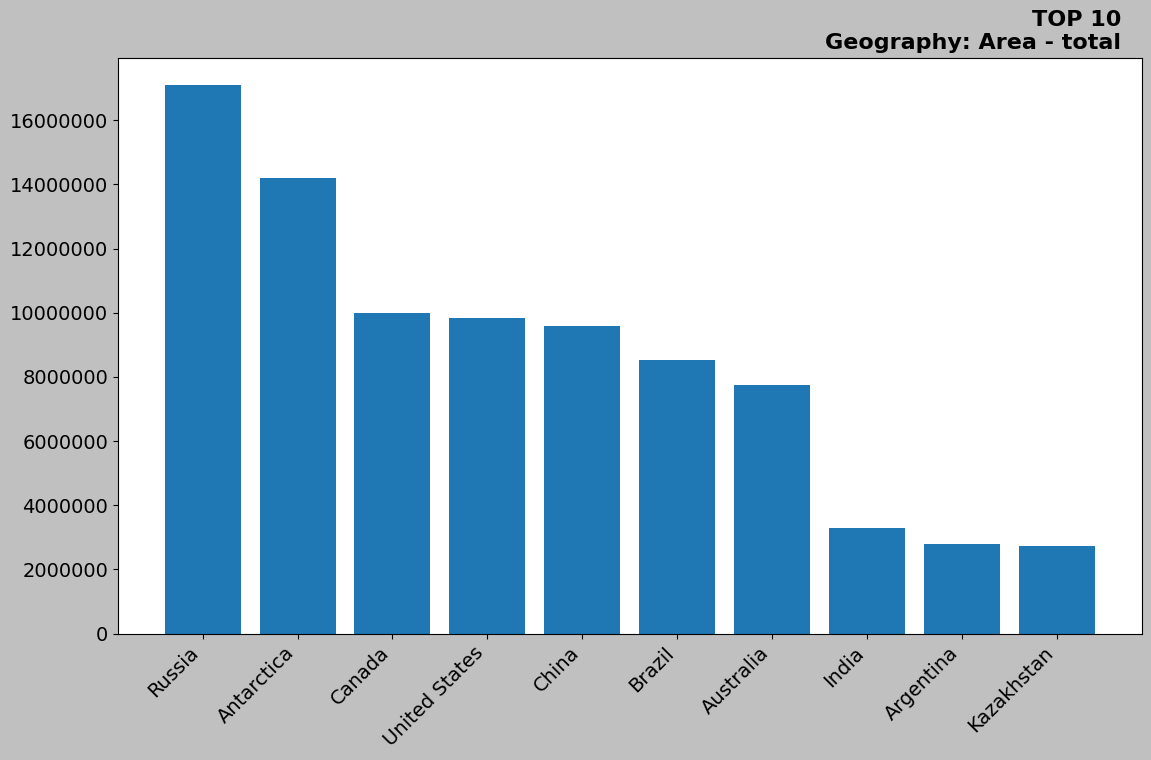

Water-area ratio


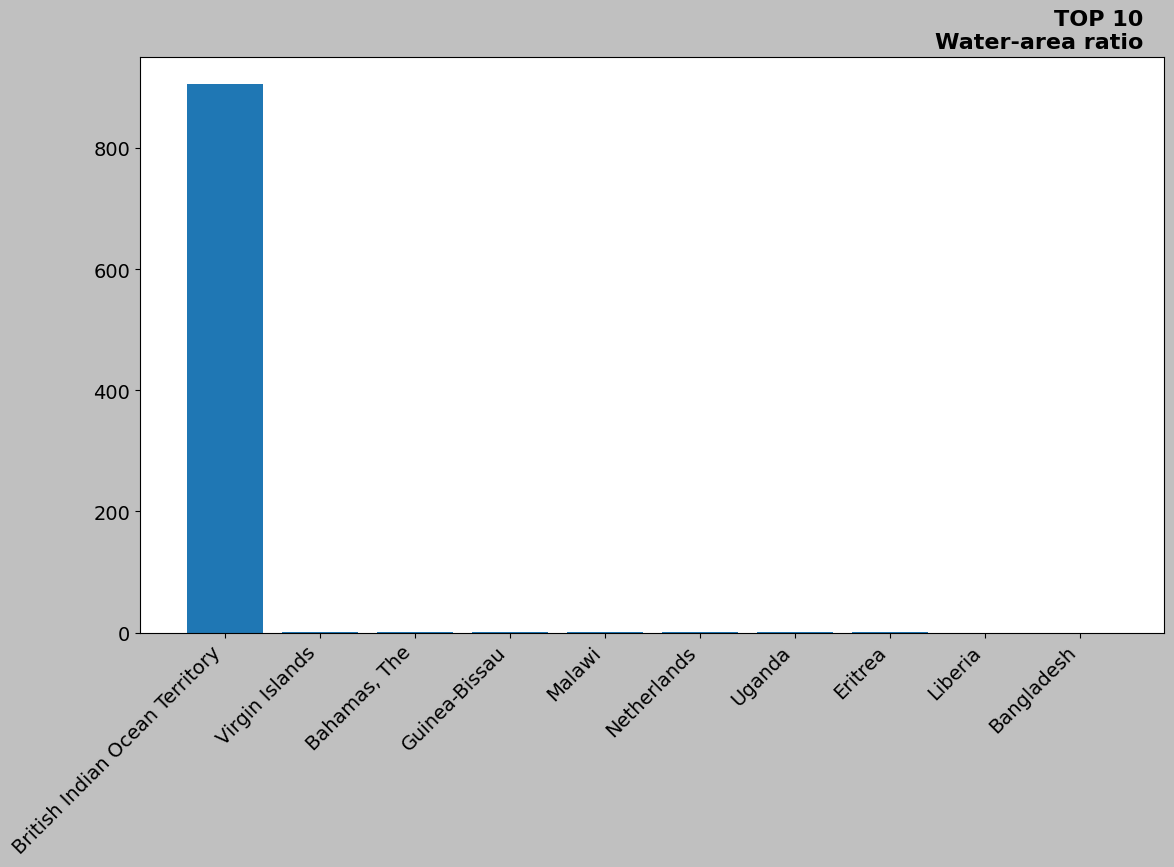

In [39]:
# largest countries. 
showMax( 'Geography: Area - total', df )

# highest percent water area
df[ 'Water-area ratio' ] = (
    df[ 'Geography: Area - water' ] /
    df[ 'Geography: Area - total' ])
showMax( 'Water-area ratio', df )

The British Indian Ocean territory value here is an outlier arising from an
apparent inconsistency or ambiguity in geographic description - the territory 
is designated across a very disparate grouping of islands which include many
whole or partial atolls with large inner bodies of water. Some interesting 
reading both for observers of colonialism and for ongoing events in the 
projection of sovereign power across large sea vectors:

##### British Indian Ocean Territory
![British_Indian_Ocean_Territory](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/British_Indian_Ocean_Territory_in_United_Kingdom.svg/1466px-British_Indian_Ocean_Territory_in_United_Kingdom.svg.png)

WIKI: 
>The only inhabitants are British and U.S. military personnel and associated 
contractors, who collectively number around 3,000 (2018 figures). The 
forced removal of Chagossians from the Chagos Archipelago occurred between 
1968 and 1973. [...] Today, the exiled Chagossians are still trying 
to return, saying that the forced expulsion and dispossession was unlawful, 
but the UK government has repeatedly denied them the right of return. The 
islands are off-limits to Chagossians, casual tourists, and the media.

Water-area ratio


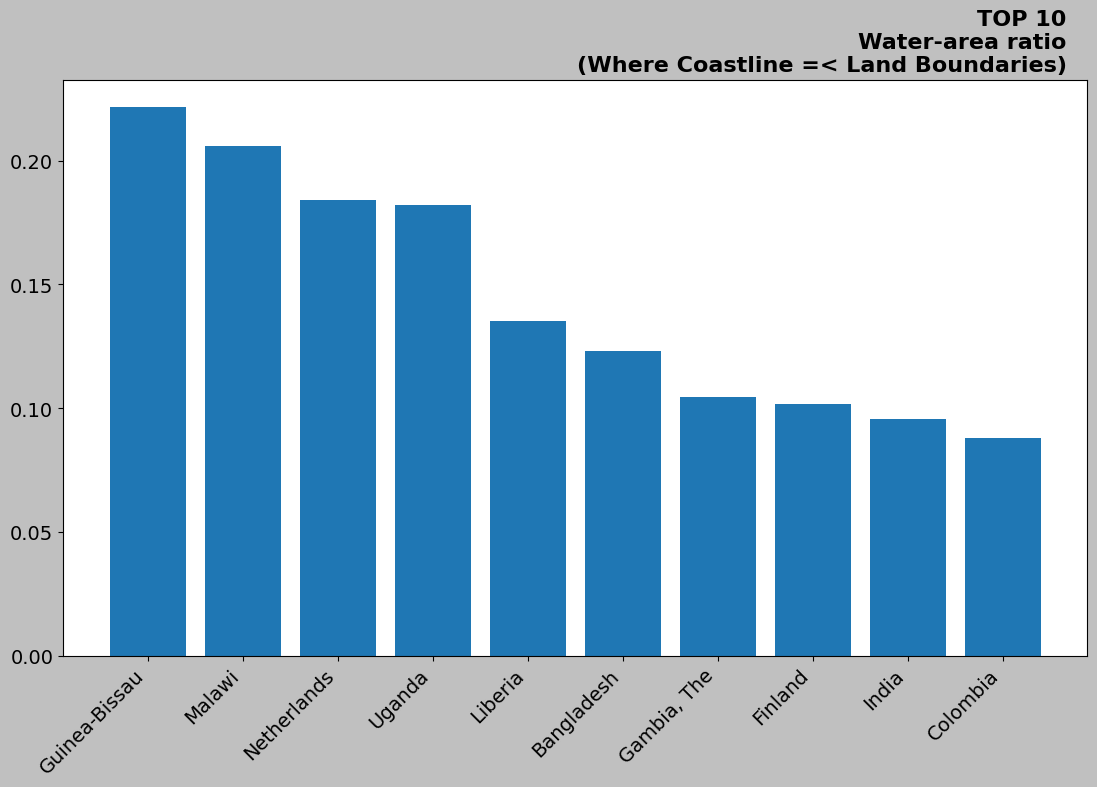

In [40]:
showMax( 'Water-area ratio',
    df[ df[ 'Geography: Land boundaries - total' ] >=
        df[ 'Geography: Coastline' ] ],
    sub="Where Coastline =< Land Boundaries" )

Excluding BIOT as an outlier should reveal a more intuitive distribution.
Better yet, to avoid catching so many islands, let's filter down to countries 
whose coastline is no longer than their land boundaries with other countries.

Water-area ratio


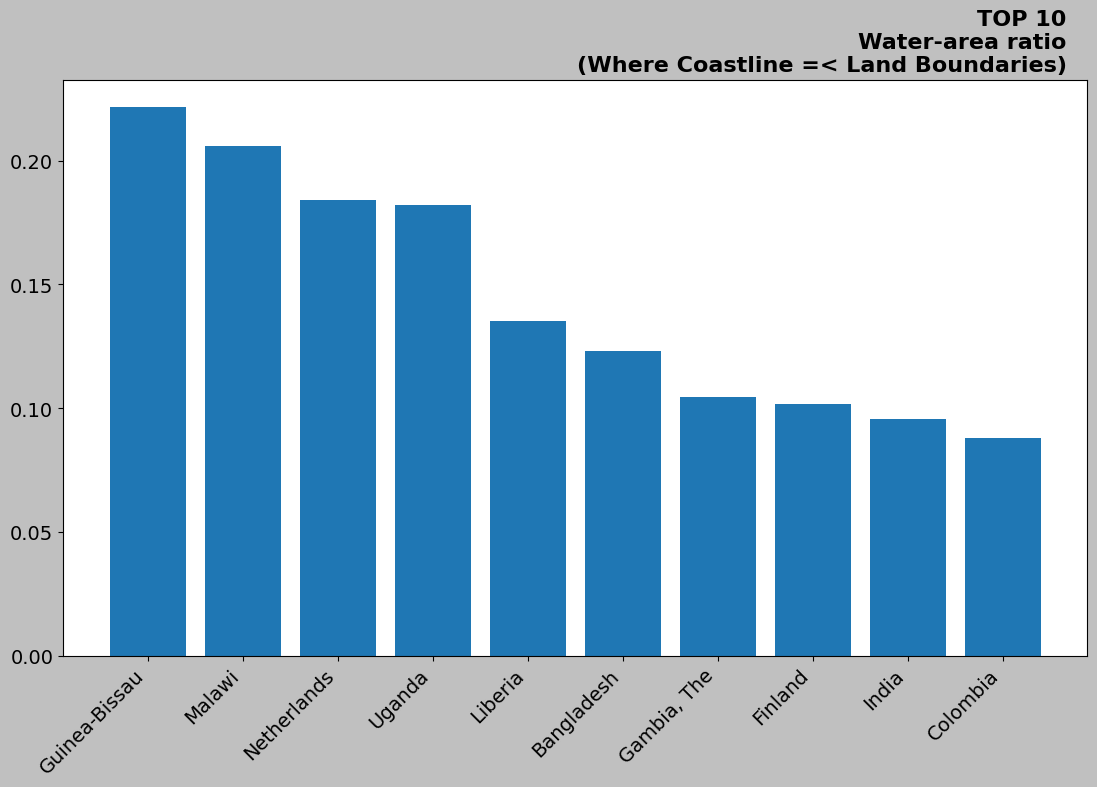

In [41]:
showMax( 'Water-area ratio',
    df[ df[ 'Geography: Land boundaries - total' ] >=
        df[ 'Geography: Coastline' ] ],
    sub="Where Coastline =< Land Boundaries" )

##### The coastline paradox
All coastlines are infinitely long, at least if you keep decreasing the unit of 
measurement. The "longest coast" could (at least logically) change for some 
smaller unit, given that it might may discover an underlying "flatness" in the 
reigning longest coastline, while discovering an underlying "texture" in the 
land boundary of another territory which produces a greater overall length
(see [here](https://medium.com/@drewjosselyn/fun-with-fractals-using-fractals-to-measure-the-coastline-length-of-one-of-canadas-most-iconic-16c3266af782)).

Nonetheless, at any scale, given the extent and countour of Canada's polar coast,
it seems likely remain out in front at any unit of measurement.

Geography: Coastline


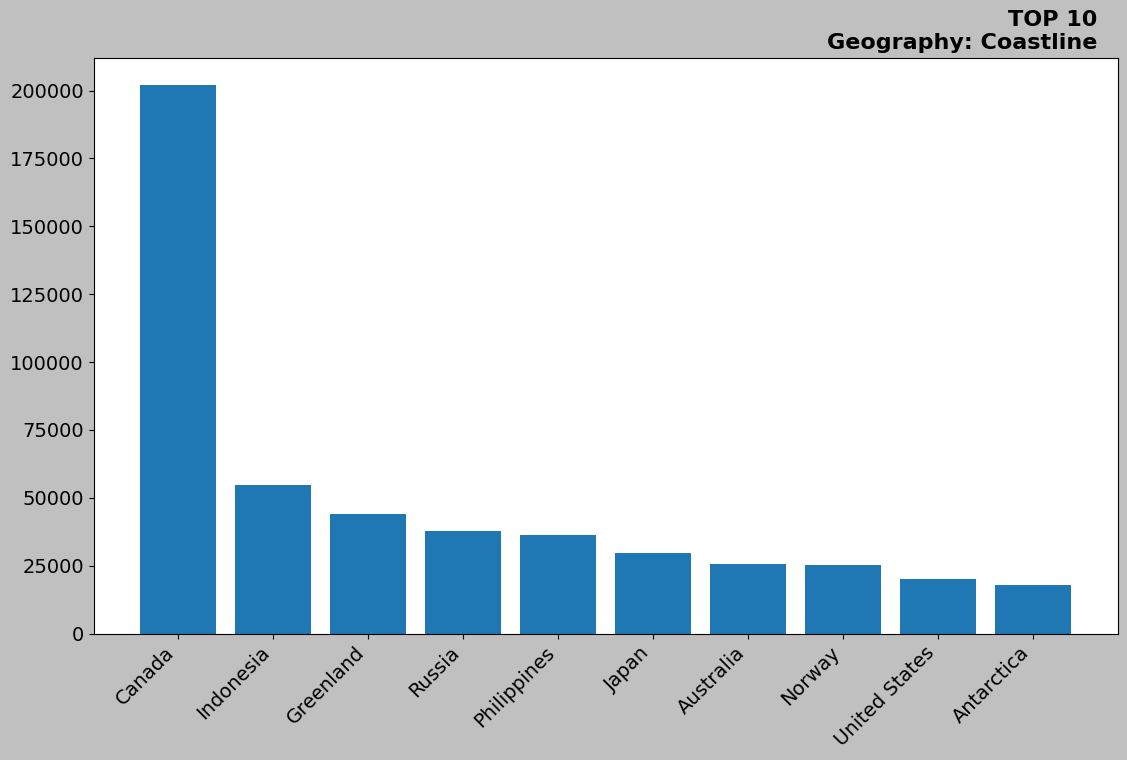

In [42]:
showMax( 'Geography: Coastline', df )

Elevation difference

Maximum elevation difference


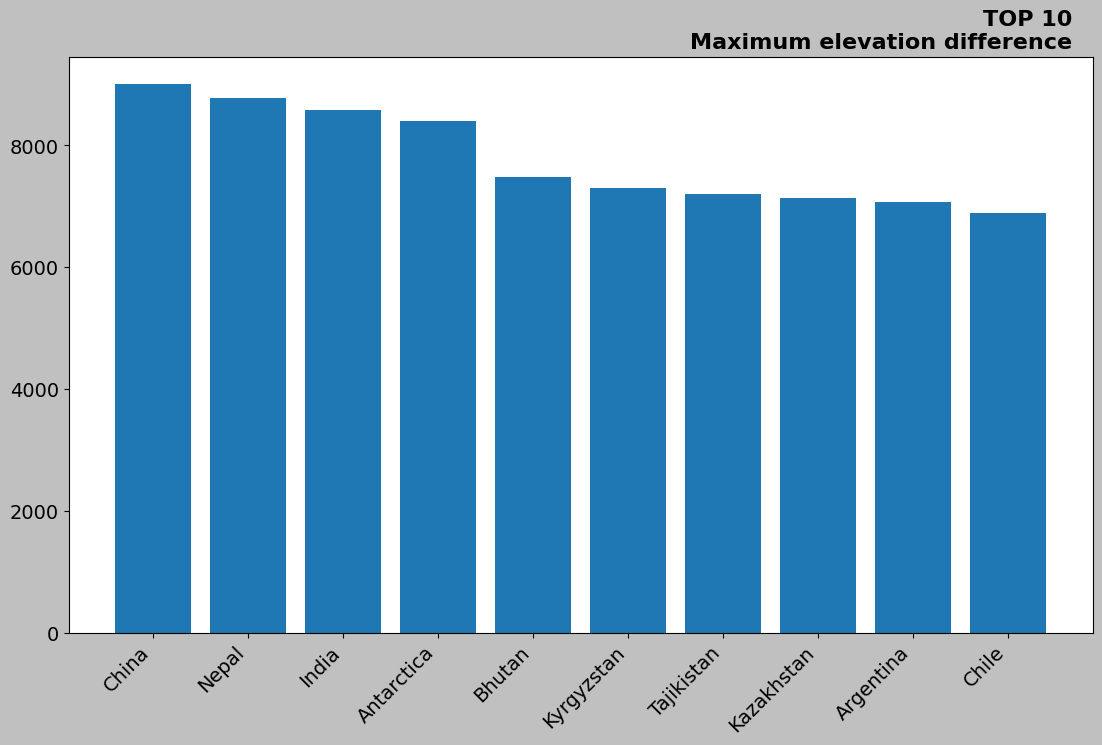

In [43]:
df[ 'Maximum elevation difference' ] = (
    df[ 'Geography: Elevation - highest point' ] -
    df[ 'Geography: Elevation - lowest point' ])
showMax( 'Maximum elevation difference', df )

Countries with the largest difference between their lowest and highest point.
While the China-Nepal border dissects Siggamartha's highest point, China 
itself has a lower minimum elevation than Nepal.

Flattest places in the world: no point on natural ground is at an ascent of
more of than five meters from any other point. At #4 in the world, Pakistan's 
current floods are devastating partly due to this marked flatness.

Cayman Islands is easiest on the hips with a M.E.D of one meter.

Maximum elevation difference


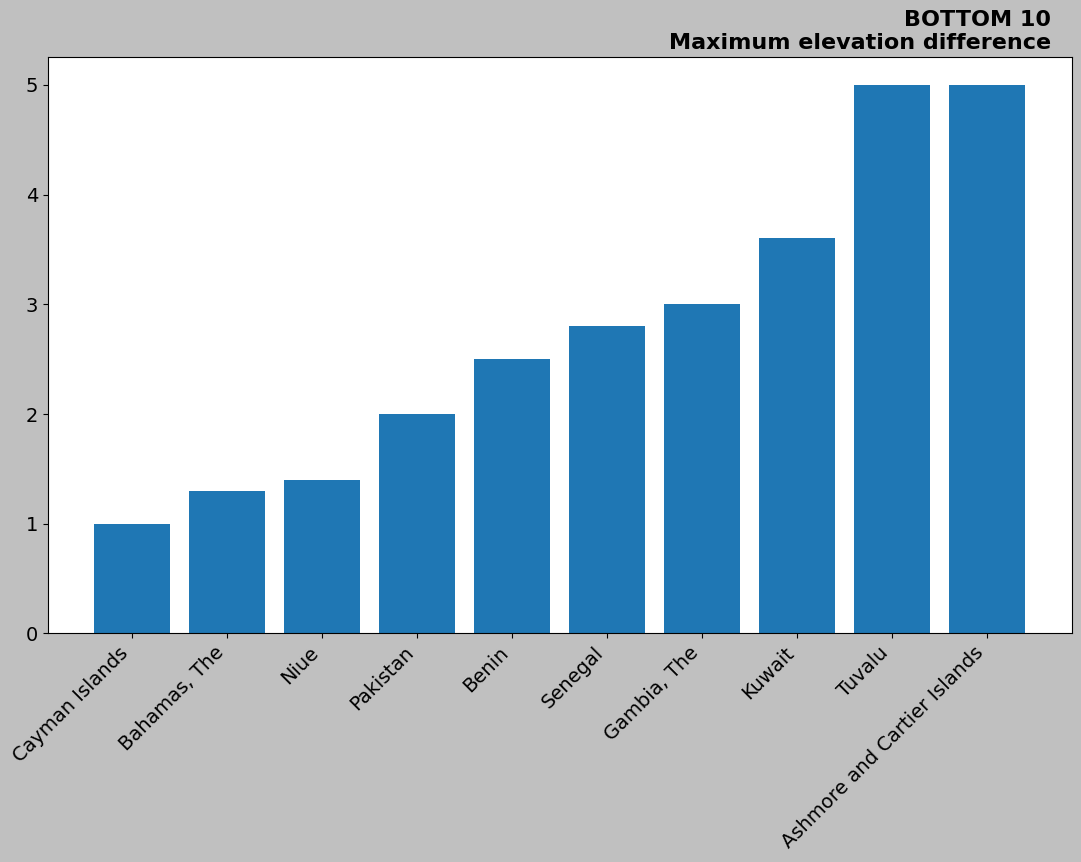

In [44]:
showMax( 'Maximum elevation difference', df, asc=True )

Environment: Land use - forest


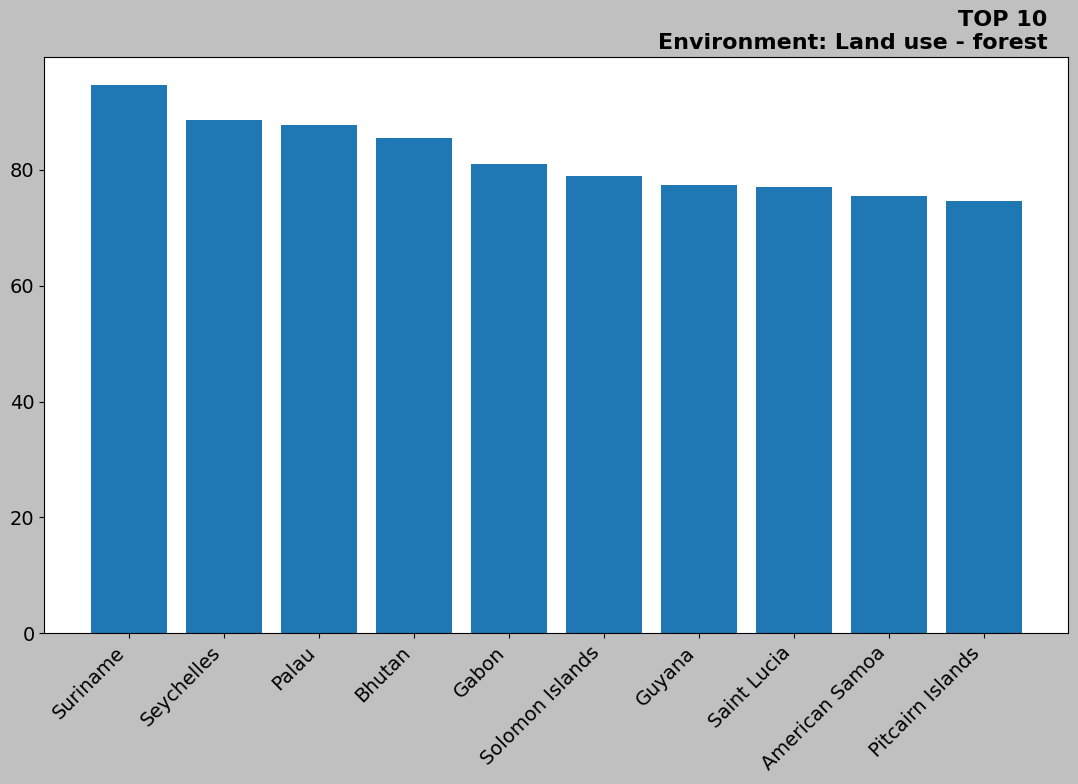

With value of [ 2.36 ], Suriname is 173th-highest for:
'Environment: Revenue from forest resources - forest revenues'
(out of total 256 ranked)


In [45]:
# A pleasant pit-stop in the forests of Suriname:
showMax( 'Environment: Land use - forest', df )

# interestingly, Suriname does very little to leverage this as a resource 
#   advantage - Suriname's rank in %rev Forst rsrc is 174th.

getRank( df, 'Suriname',
    'Environment: Revenue from forest resources - forest revenues' )

# correl/sctr?

Environment: Urbanization - urban population


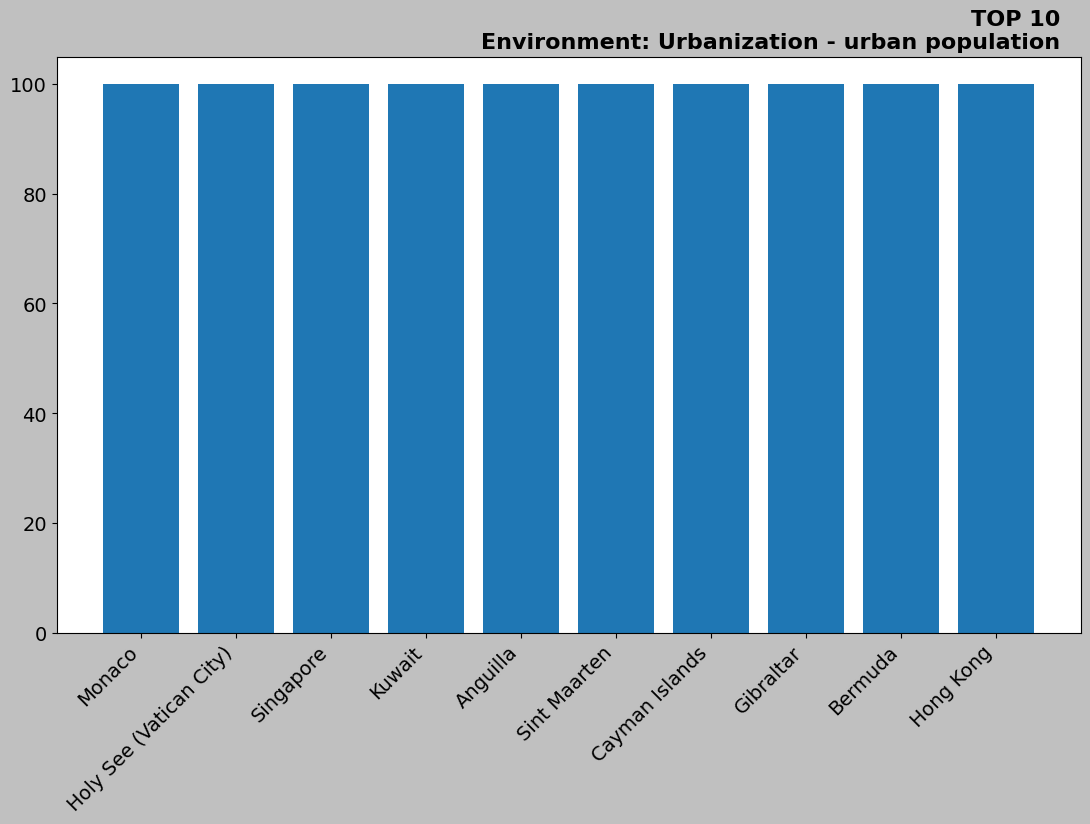

Environment: Urbanization - urban population


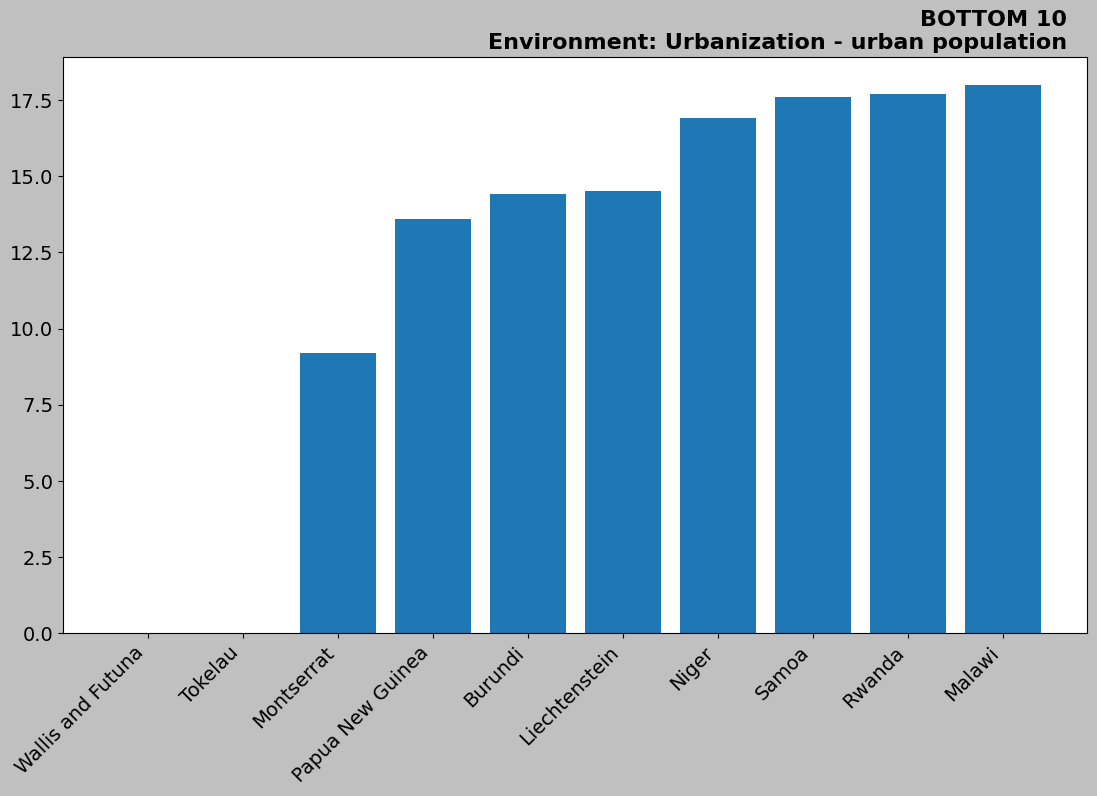

In [46]:
#   Fairly even, City-States understandably dominating the top 10. 
showMax( 'Environment: Urbanization - urban population', df )
showMax( 'Environment: Urbanization - urban population', df, asc=True )

# Of the least-urbanised, several are pacific territories with relatively 
#   unfamiliar names: Wallis and Futuna (FR), Montserrat (UK) and Tokelau (NZ). 
#   To help with attribution, if not decolonization, I submit that the UK and 
#   French territories swap names.

# Liechtenstein... is also there.
# "It is a testimony to the mere political expediency of the purchase that the Princes of Liechtenstein did not visit 
#   their new principality for almost 100 years." [citation needed]

Water withdrawal exposure to trade


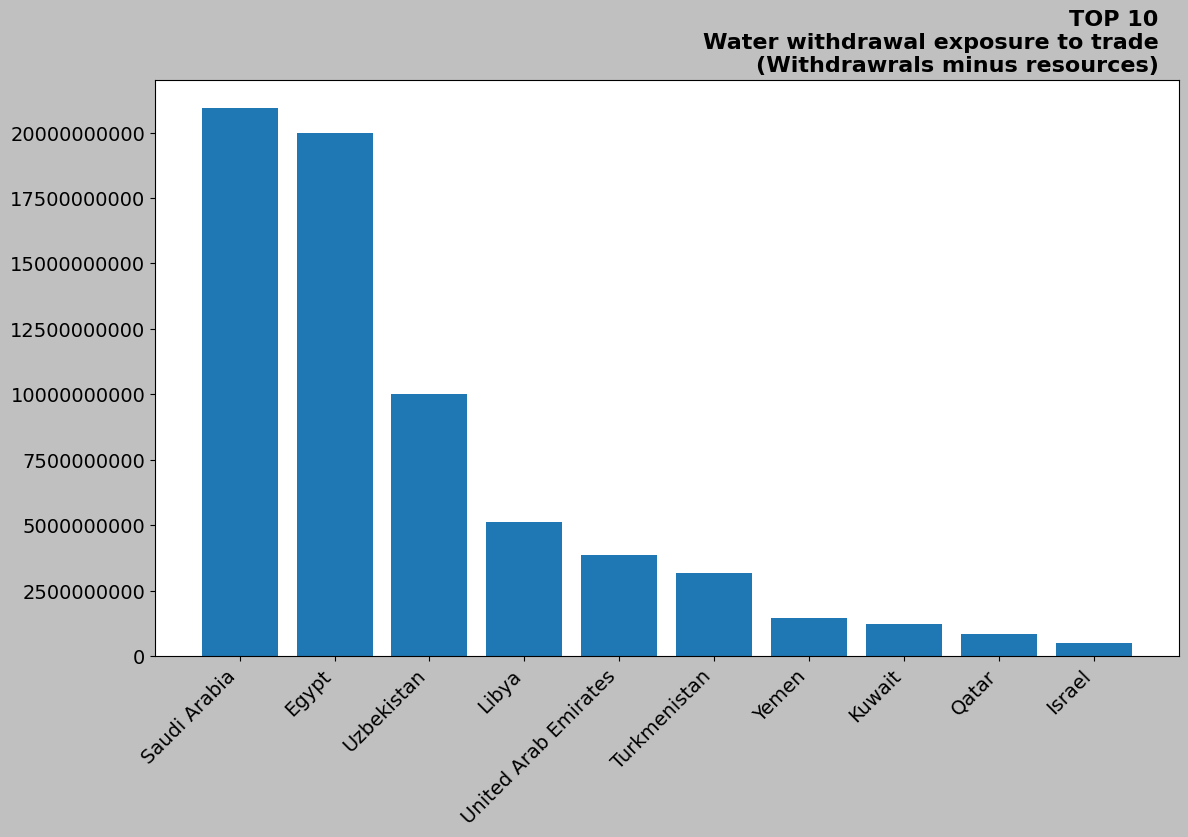

Water withdrawal exposure to trade


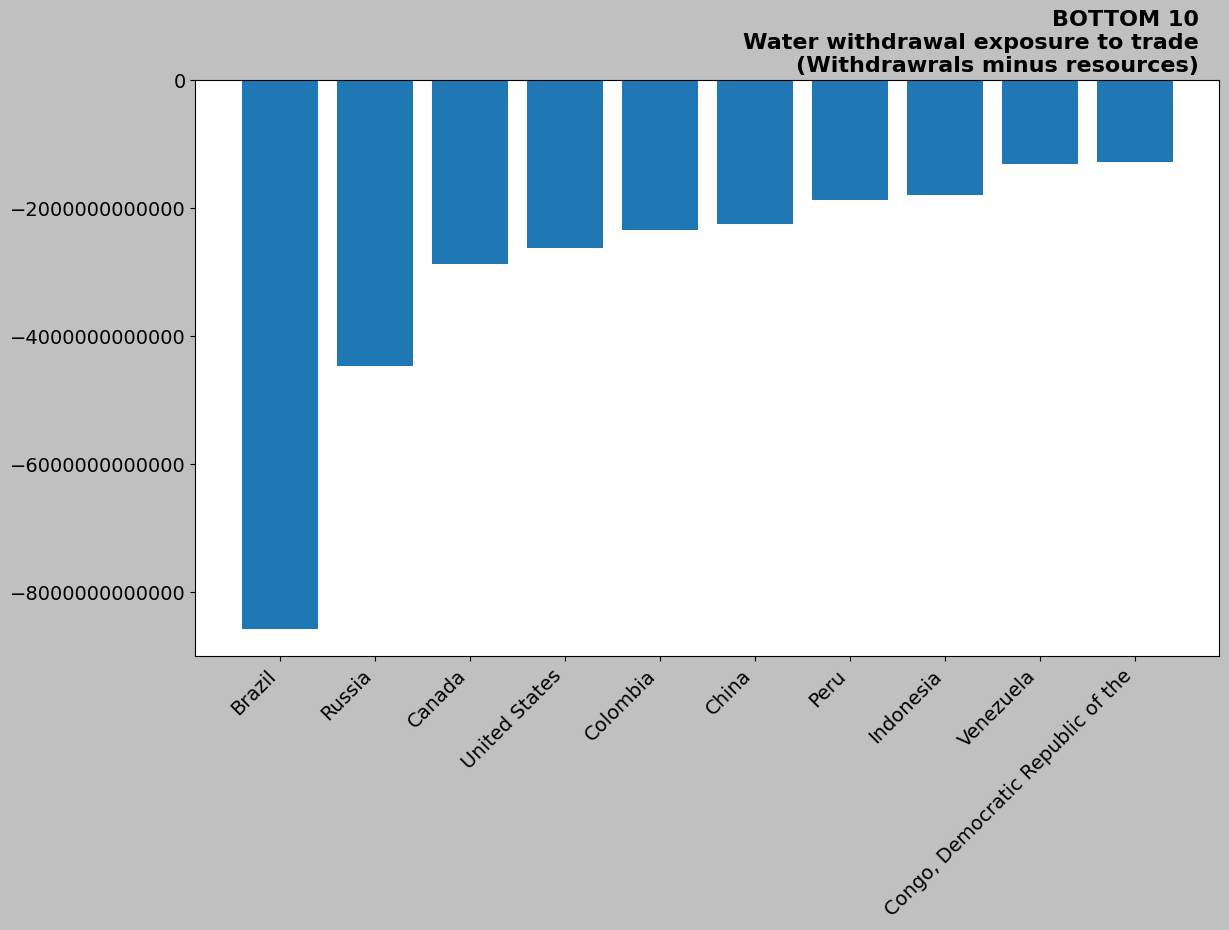

In [47]:
# Who are the most and least trade-reliant for water? (Hi there, Middle East)
# Withdrawrals (municipal, industrial and agricultural) minus renewable sources
df[ 'Water withdrawal exposure to trade' ] = (
    (df[ 'Environment: Total water withdrawal - municipal' ] +
     df[ 'Environment: Total water withdrawal - industrial' ] +
     df[ 'Environment: Total water withdrawal - agricultural' ]) -
    df[ 'Environment: Total renewable water resources' ])

showMax( 'Water withdrawal exposure to trade', df,
    sub="Withdrawrals minus resources" )

# Brazil is sitting happy there around the Amazon. Russia and Canada just 
# melt vast amounts of snow.
showMax( 'Water withdrawal exposure to trade', df, asc=True,
    sub="Withdrawrals minus resources" )

Irrigated-area ratio


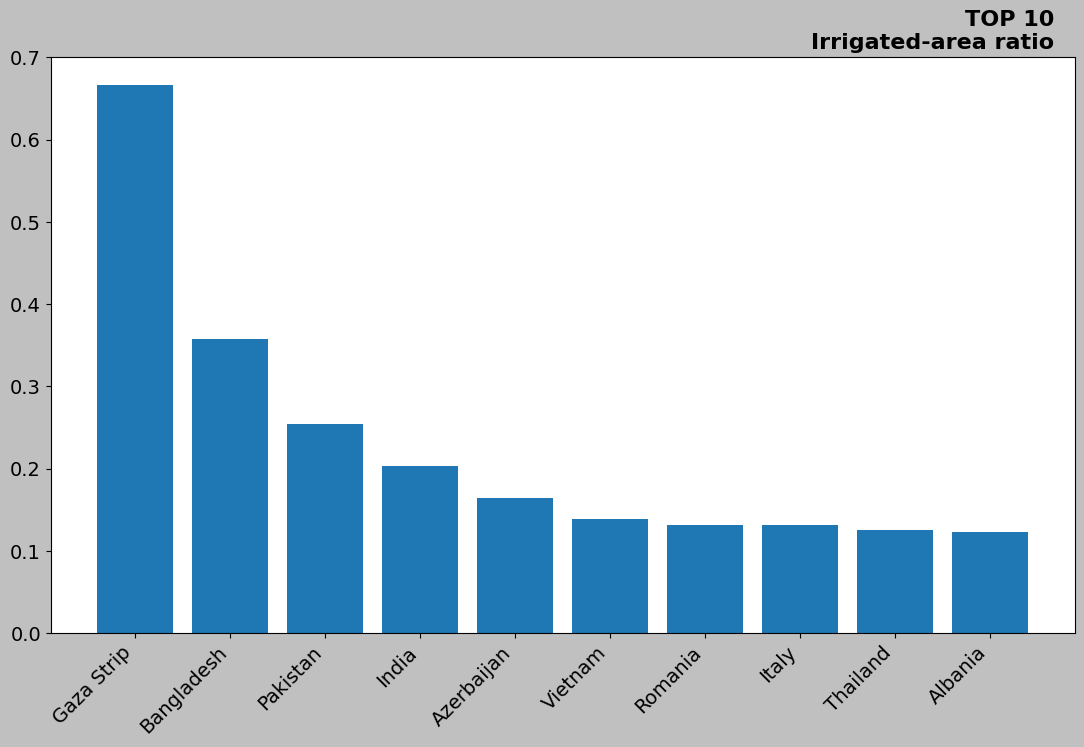

Irrigated area in Gaza Strip is 240.0 sqkm
Total area of Gaza Strip is 360.0 sqkm


In [48]:
# Ratio of irrigated land to total land

df[ 'Irrigated-area ratio' ] = (
    df[ 'Geography: Irrigated land' ] /
    df[ 'Geography: Area - total' ])
showMax( 'Irrigated-area ratio', df )

print( f"Irrigated area in Gaza Strip is "
       f"{getVal( df, 'Gaza Strip', 'Geography: Irrigated land' )} sqkm" )

print( f"Total area of Gaza Strip is "
       f"{getVal( df, 'Gaza Strip', 'Geography: Area - total' )} sqkm" )

Many members of this T10 may not surprise, as familiar origins of agricultural 
commodities, but the Gaza Strip may conjure a more arid image. The rank comes 
down to proportion and population: irrigation, as a [vital element of food production](https://socialsciences.mcmaster.ca/kubursi/ebooks/water.htm), 
takes up 240 of the territory's total 360 square kilometers, which is the third 
most densely populated territory in the world.

<font color='red'> In fact, population density and irrigated area ratio... [SCATTER]
</font>

Government: National heritage - total World Heritage Sites


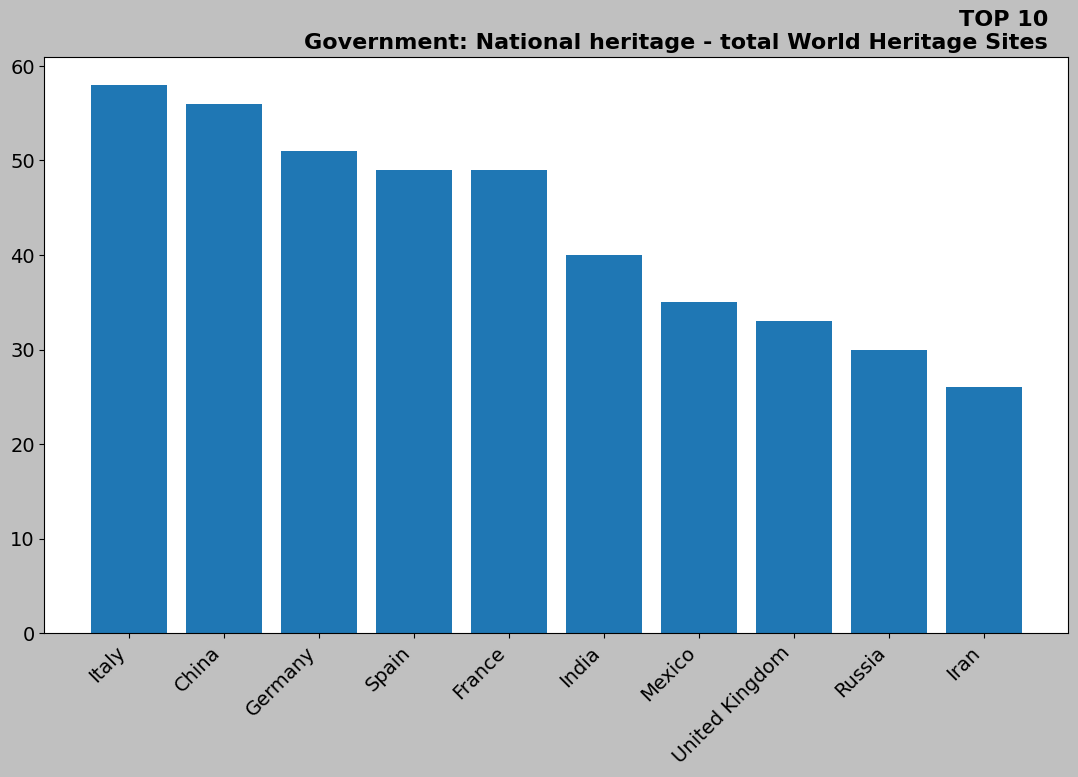

In [49]:
showMax( 'Government: National heritage - total World Heritage Sites', df )
# the anti-empire question: what qualifies as world heritage? 
# -> All t10 is high-GDP (corrob.)

In [50]:
# In the course of this study, small island groups (many with colonial 
# names) I'm not familiar with keep showing up. Would like to dive into more 
# detail on each of these.

# the Kooky Islands Krew (ctIslands)
#   appears frequently on the bottom/top ten because it is takes less
#   of an event in global terms to have a proportionately large effect
#   on the small sample, be it a population, an area total and so on. 

kookyIslands = [
    'Anguilla',
    'Ashmore and Cartier Islands',
    'British Indian Ocean Territory',
    'British Virgin Islands',
    'Cape Verde',
    'Cayman Islands',
    'Cocos (Keeling) Islands',
    'Comoros',
    'Faroe Islands',
    'Montserrat',
    'Northern Mariana Islands',
    'Saint Barthelemy',
    'Saint Kitts and Nevis',
    'Saint Lucia',
    'Saint Pierre and Miquelon',
    'Saint Vincent and the Grenadines',
    'San Marino',
    'Sao Tome and Principe',
    'Tokelau',
    'Turks and Caicos Islands',
    'Wallis and Futuna' ]

In [51]:
# Things that China is in the top-ten/5/3/1 of
# (Who else are the "most top 10/5/3/1" countries?)
# combine bottom-tens somehow?

In [52]:
# FINALIZING:

# Add positional bar colour-gradient to barplots
#   https://stackoverflow.com/questions/60220089/how-to-add-color-gradients-according-to-y-value-to-a-bar-plot
# Generate unitDct which vis. fetches for feature by column key
# Group t10s and scatterplots by subject.
# move all/most defs to imports, except where important for process comm.